# Fast Bayesian estimation of SARIMAX models

## Introduction

This notebook will show how to use fast Bayesian methods to estimate SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) models. These methods can also be parallelized across multiple cores.

Here, fast methods means a version of Hamiltonian Monte Carlo called the No-U-Turn Sampler (NUTS) developed by Hoffmann and Gelman: see [Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. Journal of Machine Learning Research, 15(1), 1593-1623.](https://arxiv.org/abs/1111.4246). As they say, "the cost of HMC per independent sample from a target distribution of dimension $D$ is roughly $\mathcal{O}(D^{5/4})$, which stands in sharp contrast with the $\mathcal{O}(D^{2})$ cost of random-walk Metropolis". So for problems of larger dimension, the time-saving with HMC is significant. However it does require the gradient, or Jacobian, of the model to be provided.

This notebook will combine the Python libraries [statsmodels](https://www.statsmodels.org/stable/index.html), which does econometrics, and [PyMC3](https://docs.pymc.io/), which is for Bayesian estimation, to perform fast Bayesian estimation of a simple SARIMAX model, in this case an ARMA(1, 1) model for US CPI.

Note that, for simple models like AR(p), base PyMC3 is a quicker way to fit a model; there's an [example here](https://docs.pymc.io/notebooks/AR.html). The advantage of using statsmodels is that it gives access to methods that can solve a vast range of statespace models.

The model we'll solve is given by

$$
y_t = \phi y_{t-1} + \varepsilon_t + \theta_1 \varepsilon_{t-1}, \qquad \varepsilon_t \sim N(0, \sigma^2)
$$

with 1 auto-regressive term and 1 moving average term. In statespace form it is written as:

$$
\begin{align}
y_t & = \underbrace{\begin{bmatrix} 1 & \theta_1 \end{bmatrix}}_{Z} \underbrace{\begin{bmatrix} \alpha_{1,t} \\ \alpha_{2,t} \end{bmatrix}}_{\alpha_t} \\
    \begin{bmatrix} \alpha_{1,t+1} \\ \alpha_{2,t+1} \end{bmatrix} & = \underbrace{\begin{bmatrix}
        \phi & 0 \\
        1      & 0     \\
    \end{bmatrix}}_{T} \begin{bmatrix} \alpha_{1,t} \\ \alpha_{2,t} \end{bmatrix} +
    \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{R} \underbrace{\varepsilon_{t+1}}_{\eta_t} \\
\end{align}
$$

The code will follow these steps:
1. Import external dependencies
2. Download and plot the data on US CPI
3. Simple maximum likelihood estimation (MLE) as an example
4. Definitions of helper functions to provide tensors to the library doing Bayesian estimation
5. Bayesian estimation via NUTS
6. Application to US CPI series

Finally, Appendix A shows how to re-use the helper functions from step (4) to estimate a different state space model, `UnobservedComponents`, using the same Bayesian methods.

### 1. Import external dependencies

In [1]:
%matplotlib inline
import theano
import theano.tensor as tt
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

### 2. Download and plot the data on US CPI

We'll get the data from FRED:

In [2]:
cpi = DataReader('CPIAUCNS', 'fred', start='1971-01', end='2018-12')
cpi.index = pd.DatetimeIndex(cpi.index, freq='MS')

# Define the inflation series that we'll use in analysis
inf = np.log(cpi).resample('QS').mean().diff()[1:] * 400
print(inf.head())

            CPIAUCNS
DATE                
1971-04-01  4.316424
1971-07-01  4.279518
1971-10-01  1.956799
1972-01-01  2.917767
1972-04-01  3.219096


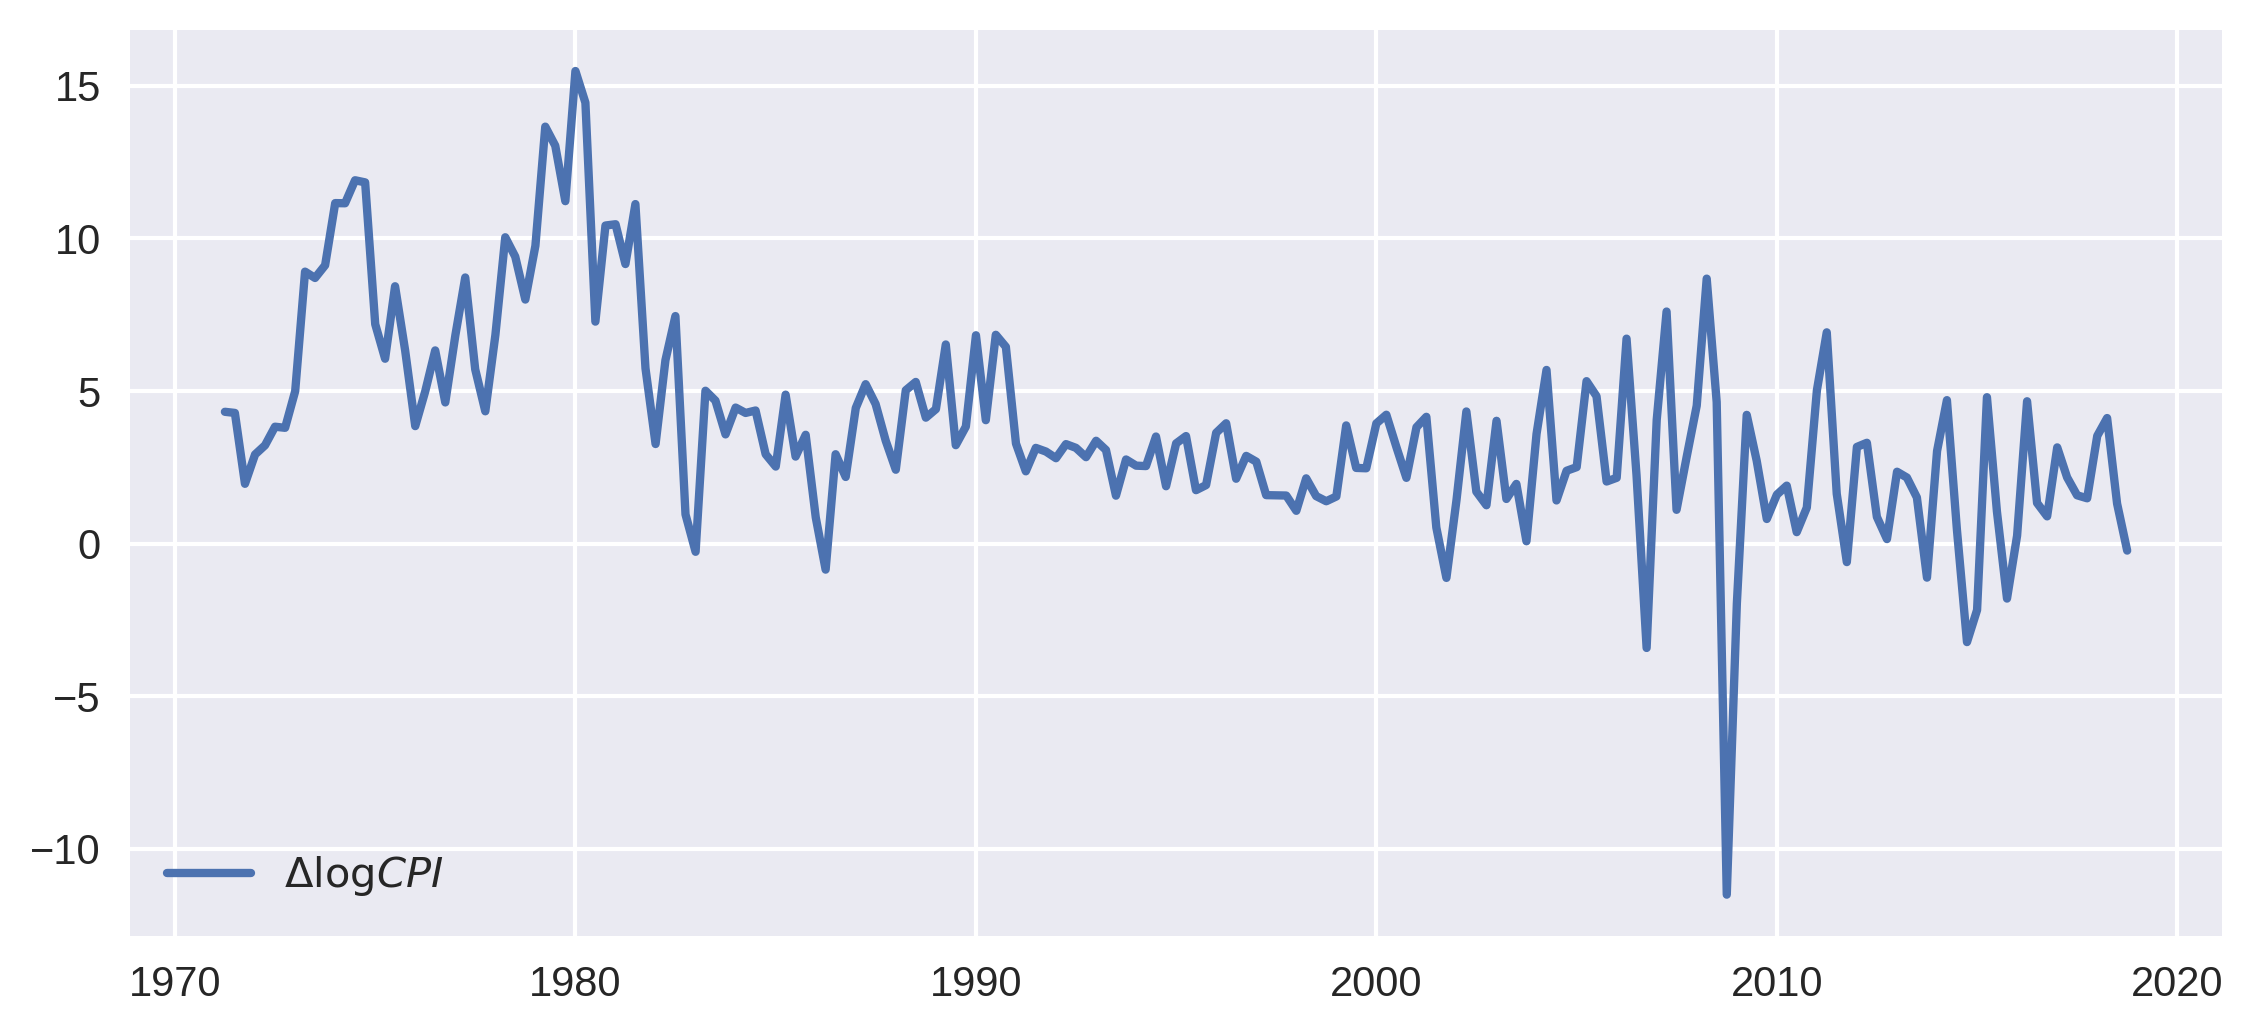

In [3]:
# Plot the series 
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
ax.plot(inf.index, inf, label=r'$\Delta \log CPI$', lw=2)
ax.legend(loc='lower left')
plt.show()

### 3. Fit the model with maximum likelihood

Statsmodels does all of the hard work of this for us - creating and fitting the model takes just two lines of code. The model order parameters correspond to auto-regressive, difference, and moving average orders respectively.

In [4]:
# Create an SARIMAX model instance - here we use it to estimate
# the parameters via MLE using the `fit` method, but we can
# also re-use it below for the Bayesian estimation
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 0, 1))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

                               SARIMAX Results                                
Dep. Variable:               CPIAUCNS   No. Observations:                  191
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -448.685
Date:                Tue, 02 Feb 2021   AIC                            903.370
Time:                        06:55:38   BIC                            913.127
Sample:                    04-01-1971   HQIC                           907.322
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9785      0.015     64.545      0.000       0.949       1.008
ma.L1         -0.6342      0.057    -11.073      0.000      -0.747      -0.522
sigma2         6.3682      0.323     19.695      0.0

It's a good fit. We can also get the series of one-step ahead predictions and plot it next to the actual data, along with a confidence band.


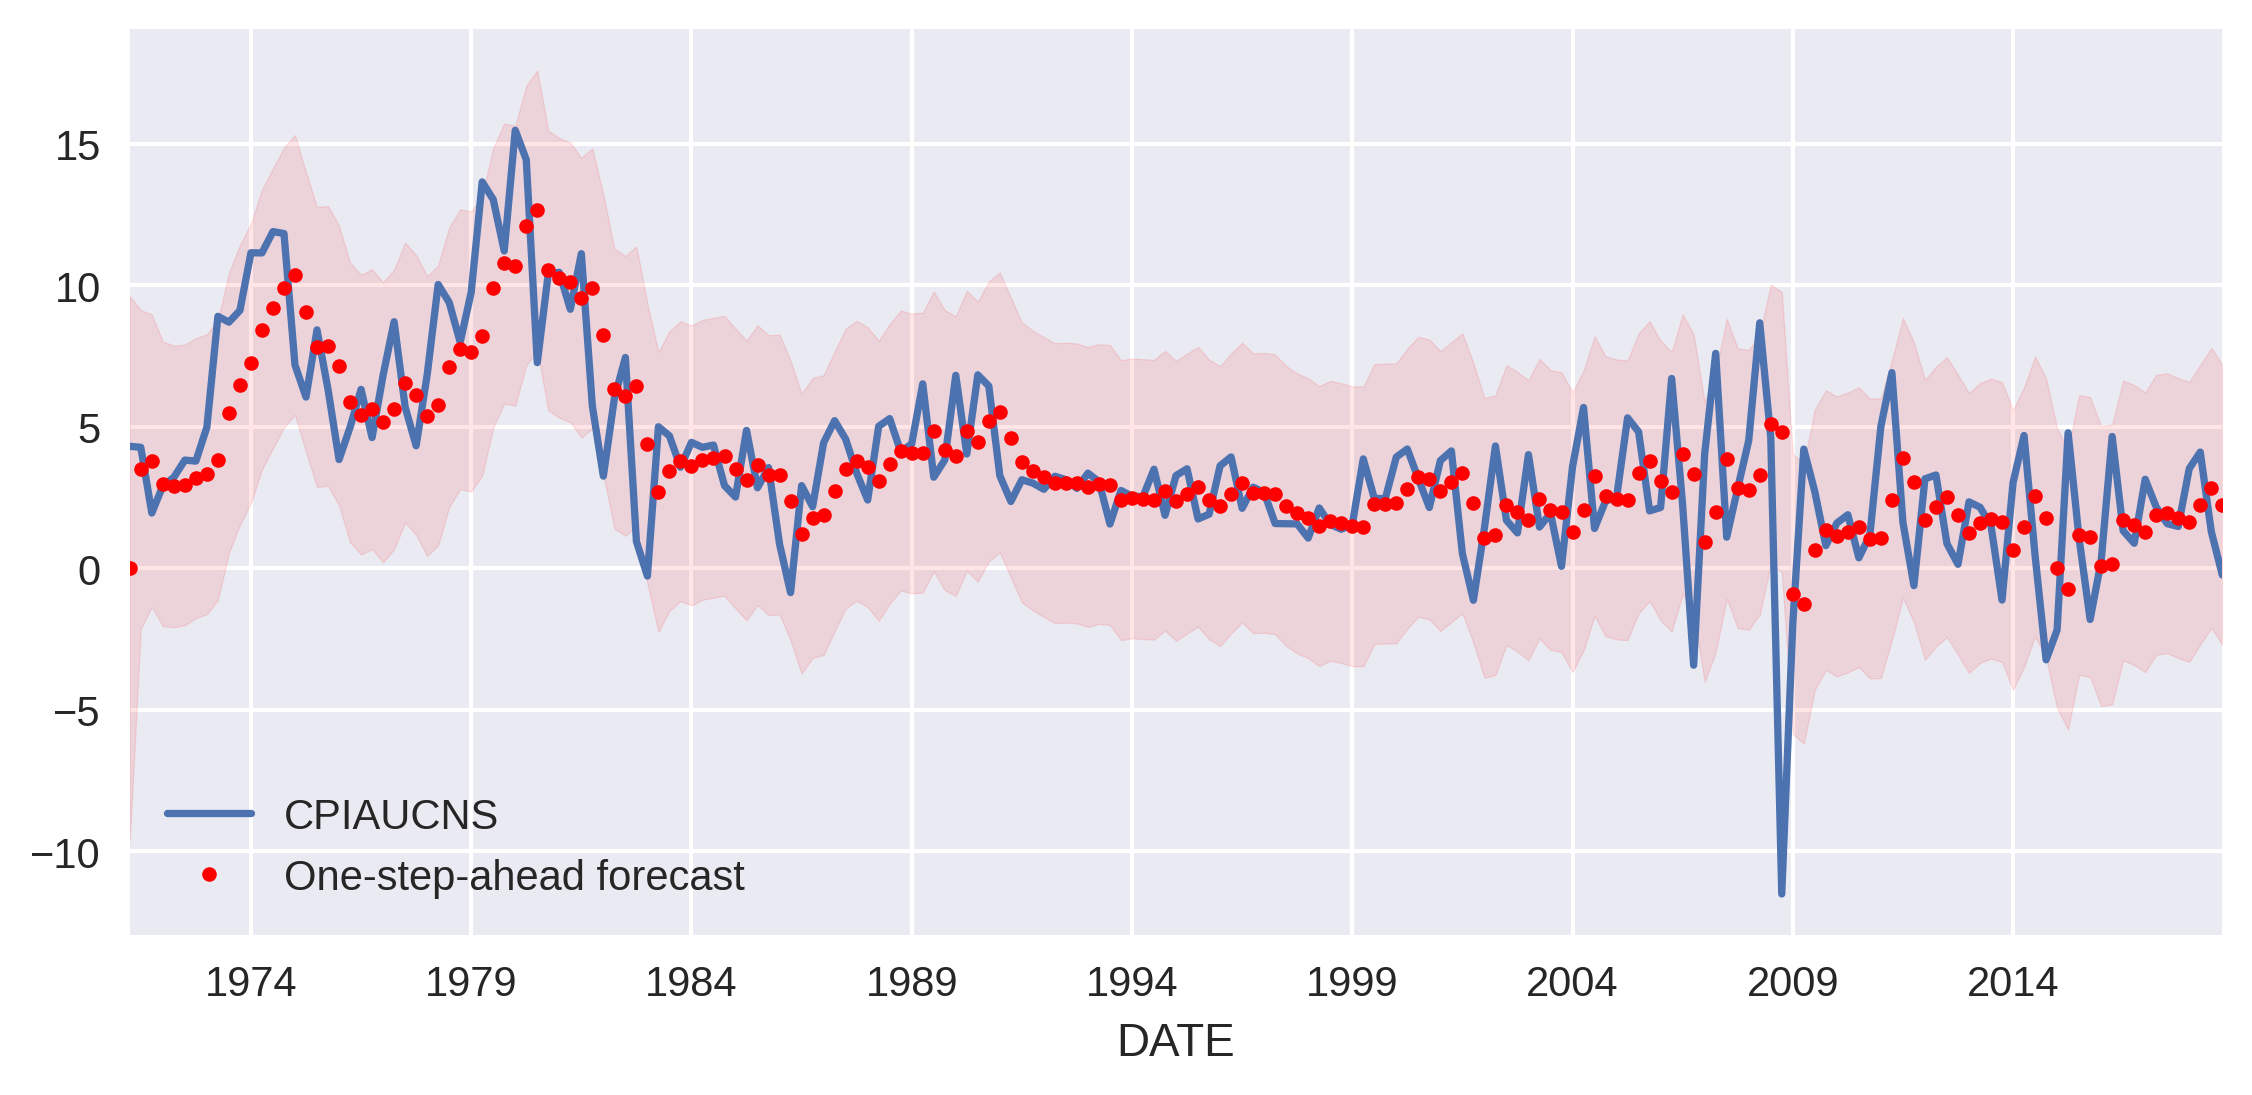

In [5]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci['lower CPIAUCNS']
upper = predict_mle_ci['upper CPIAUCNS']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
inf.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_mle.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_mle_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
plt.show()

### 4. Helper functions to provide tensors to the library doing Bayesian estimation

We're almost on to the magic but there are a few preliminaries. Feel free to skip this section if you're not interested in the technical details.

### Technical Details

PyMC3 is a Bayesian estimation library ("Probabilistic Programming in Python: Bayesian Modeling and Probabilistic Machine Learning with Theano") that is a) fast and b) optimized for Bayesian machine learning, for instance [Bayesian neural networks](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html). To do all of this, it is built on top of a Theano, a library that aims to evaluate tensors very efficiently and provide symbolic differentiation (necessary for any kind of deep learning). It is the symbolic differentiation that means PyMC3 can use NUTS on any problem formulated within PyMC3.

We are not formulating a problem directly in PyMC3; we're using statsmodels to specify the statespace model and solve it with the Kalman filter. So we need to put the plumbing of statsmodels and PyMC3 together, which means wrapping the statsmodels SARIMAX model object in a Theano-flavored wrapper before passing information to PyMC3 for estimation.

Because of this, we can't use the Theano auto-differentiation directly. Happily, statsmodels SARIMAX objects have a method to return the Jacobian evaluated at the parameter values. We'll be making use of this to provide gradients so that we can use NUTS.

#### Defining helper functions to translate models into a PyMC3 friendly form

First, we'll create the Theano wrappers. They will be in the form of 'Ops', operation objects, that 'perform' particular tasks. They are initialized with a statsmodels `model` instance.

Although this code may look somewhat opaque, it is generic for any state space model in statsmodels.

In [6]:
class Loglike(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        theta, = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out

    
class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        theta, = inputs
        outputs[0][0] = self.model.score(theta)

### 5. Bayesian estimation with NUTS

The next step is to set the parameters for the Bayesian estimation, specify our priors, and run it.

In [7]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600   # number of "burn-in points" (which will be discarded)

Now for the fun part! There are three parameters to estimate: $\phi$, $\theta_1$, and $\sigma$. We'll use uninformative uniform priors for the first two, and an inverse gamma for the last one. Then we'll run the inference optionally using as many computer cores as I have.

In [8]:
# Construct an instance of the Theano wrapper defined above, which
# will allow PyMC3 to compute the likelihood and Jacobian in a way
# that it can make use of. Here we are using the same model instance
# created earlier for MLE analysis (we could also create a new model
# instance if we preferred)
loglike = Loglike(mod)

with pm.Model():
    # Priors
    arL1 = pm.Uniform('ar.L1', -0.99, 0.99)
    maL1 = pm.Uniform('ma.L1', -0.99, 0.99)
    sigma2 = pm.InverseGamma('sigma2', 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: loglike(v), observed={'v': theta})
    
    # Draw samples
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True, cores=4)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma2, ma.L1, ar.L1]


Sampling 4 chains, 0 divergences:   0%|          | 0/14400 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 10/14400 [00:00<02:24, 99.68draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 20/14400 [00:00<02:27, 97.78draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 30/14400 [00:00<02:28, 97.02draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 40/14400 [00:00<04:13, 56.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 48/14400 [00:00<05:56, 40.26draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 54/14400 [00:01<06:53, 34.68draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 59/14400 [00:01<07:03, 33.84draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/14400 [00:01<09:16, 25.78draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/14400 [00:01<08:58, 26.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 76/14400 [00:01<06:40, 35.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 81/14400 [00:02<08:26, 28.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 85/14400 [00:02<08:16, 28.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 89/14400 [00:02<09:14, 25.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 93/14400 [00:02<10:14, 23.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 99/14400 [00:02<08:11, 29.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 103/14400 [00:03<08:28, 28.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 107/14400 [00:03<07:51, 30.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 112/14400 [00:03<07:02, 33.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 116/14400 [00:03<06:48, 34.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 120/14400 [00:03<08:15, 28.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 124/14400 [00:03<08:32, 27.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/14400 [00:03<06:02, 39.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/14400 [00:03<06:35, 36.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/14400 [00:04<07:09, 33.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/14400 [00:04<07:18, 32.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/14400 [00:04<07:47, 30.48draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 157/14400 [00:04<07:12, 32.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/14400 [00:04<06:33, 36.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 170/14400 [00:04<05:38, 41.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 175/14400 [00:05<06:42, 35.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 179/14400 [00:05<06:41, 35.39draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 185/14400 [00:05<05:49, 40.68draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 190/14400 [00:05<05:39, 41.88draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 195/14400 [00:05<05:36, 42.23draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 200/14400 [00:05<05:49, 40.58draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 205/14400 [00:05<06:20, 37.26draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 209/14400 [00:05<07:12, 32.80draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 213/14400 [00:06<07:49, 30.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 217/14400 [00:06<07:25, 31.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 222/14400 [00:06<06:58, 33.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 231/14400 [00:06<05:39, 41.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 237/14400 [00:06<05:12, 45.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 243/14400 [00:06<04:57, 47.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 249/14400 [00:06<04:47, 49.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 258/14400 [00:06<04:11, 56.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 264/14400 [00:07<04:17, 54.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 270/14400 [00:07<04:27, 52.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 276/14400 [00:07<04:21, 54.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 282/14400 [00:07<04:21, 54.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 288/14400 [00:07<04:45, 49.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 296/14400 [00:07<04:16, 55.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 302/14400 [00:07<04:28, 52.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 309/14400 [00:07<04:16, 54.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 315/14400 [00:08<04:27, 52.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 324/14400 [00:08<03:59, 58.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 332/14400 [00:08<03:42, 63.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 339/14400 [00:08<04:07, 56.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 345/14400 [00:08<04:26, 52.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 352/14400 [00:08<04:06, 56.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 358/14400 [00:08<04:22, 53.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 364/14400 [00:08<04:21, 53.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 370/14400 [00:09<04:41, 49.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 376/14400 [00:09<04:29, 52.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 382/14400 [00:09<04:28, 52.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 388/14400 [00:09<04:36, 50.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 394/14400 [00:09<04:26, 52.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 400/14400 [00:09<05:31, 42.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 405/14400 [00:09<05:40, 41.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 413/14400 [00:09<04:50, 48.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 420/14400 [00:10<04:24, 52.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 426/14400 [00:10<04:23, 52.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 432/14400 [00:10<04:23, 53.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 438/14400 [00:10<04:27, 52.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 446/14400 [00:10<04:06, 56.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 453/14400 [00:10<03:55, 59.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 461/14400 [00:10<03:36, 64.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 468/14400 [00:10<04:18, 53.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 476/14400 [00:11<03:56, 58.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 483/14400 [00:11<04:33, 50.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 489/14400 [00:11<05:16, 43.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 494/14400 [00:11<05:11, 44.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 500/14400 [00:11<05:00, 46.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 508/14400 [00:11<04:26, 52.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 515/14400 [00:11<04:06, 56.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 521/14400 [00:12<04:45, 48.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 528/14400 [00:12<04:33, 50.77draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 534/14400 [00:12<04:27, 51.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 540/14400 [00:12<05:30, 41.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 545/14400 [00:12<06:28, 35.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 549/14400 [00:12<06:20, 36.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 554/14400 [00:12<05:54, 39.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 559/14400 [00:13<06:23, 36.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 565/14400 [00:13<05:52, 39.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 572/14400 [00:13<05:06, 45.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 577/14400 [00:13<04:58, 46.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 582/14400 [00:13<05:14, 43.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 589/14400 [00:13<04:35, 50.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 595/14400 [00:13<04:25, 51.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 601/14400 [00:13<04:15, 54.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 609/14400 [00:13<03:50, 59.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 617/14400 [00:14<03:36, 63.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 625/14400 [00:14<03:27, 66.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 633/14400 [00:14<03:20, 68.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 640/14400 [00:14<03:23, 67.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 647/14400 [00:14<03:23, 67.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 654/14400 [00:14<03:42, 61.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 661/14400 [00:14<04:17, 53.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 667/14400 [00:14<04:21, 52.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 673/14400 [00:15<04:29, 50.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 679/14400 [00:15<04:30, 50.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 685/14400 [00:15<04:21, 52.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 691/14400 [00:15<04:43, 48.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 696/14400 [00:15<04:43, 48.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 705/14400 [00:15<04:02, 56.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 713/14400 [00:15<03:57, 57.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 721/14400 [00:15<03:51, 59.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 727/14400 [00:15<03:51, 59.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 733/14400 [00:16<03:51, 59.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 740/14400 [00:16<03:44, 60.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 747/14400 [00:16<04:00, 56.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 754/14400 [00:16<03:46, 60.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 761/14400 [00:16<03:58, 57.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 768/14400 [00:16<03:46, 60.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 775/14400 [00:16<03:42, 61.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 783/14400 [00:16<03:26, 65.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 790/14400 [00:17<04:07, 55.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 797/14400 [00:17<03:55, 57.71draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 804/14400 [00:17<04:21, 51.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 810/14400 [00:17<04:17, 52.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 816/14400 [00:17<04:17, 52.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 824/14400 [00:17<04:08, 54.66draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 830/14400 [00:17<04:09, 54.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 836/14400 [00:17<04:10, 54.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 843/14400 [00:18<04:12, 53.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 849/14400 [00:18<04:41, 48.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 856/14400 [00:18<04:17, 52.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 862/14400 [00:18<04:21, 51.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 869/14400 [00:18<04:15, 52.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 875/14400 [00:18<04:39, 48.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 880/14400 [00:18<04:48, 46.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 885/14400 [00:18<05:06, 44.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 891/14400 [00:19<05:10, 43.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 896/14400 [00:19<05:16, 42.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 902/14400 [00:19<05:00, 44.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 909/14400 [00:19<04:45, 47.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 916/14400 [00:19<04:34, 49.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 922/14400 [00:19<04:28, 50.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 928/14400 [00:19<04:52, 45.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 933/14400 [00:19<04:47, 46.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 940/14400 [00:20<04:20, 51.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 946/14400 [00:20<05:07, 43.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 951/14400 [00:20<05:13, 42.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 956/14400 [00:20<05:30, 40.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 961/14400 [00:20<05:16, 42.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 966/14400 [00:20<05:03, 44.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 971/14400 [00:20<05:20, 41.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 976/14400 [00:20<05:07, 43.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 981/14400 [00:21<05:32, 40.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 987/14400 [00:21<05:21, 41.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 992/14400 [00:21<05:07, 43.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 998/14400 [00:21<05:27, 40.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1003/14400 [00:21<05:13, 42.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1008/14400 [00:21<05:01, 44.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1016/14400 [00:21<04:20, 51.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1022/14400 [00:21<04:19, 51.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1028/14400 [00:22<05:06, 43.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1033/14400 [00:22<05:10, 43.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1038/14400 [00:22<05:05, 43.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1044/14400 [00:22<04:45, 46.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1049/14400 [00:22<05:19, 41.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1054/14400 [00:22<05:40, 39.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1059/14400 [00:22<05:58, 37.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1065/14400 [00:23<05:24, 41.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1070/14400 [00:23<05:32, 40.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1075/14400 [00:23<05:32, 40.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1080/14400 [00:23<05:17, 41.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1085/14400 [00:23<05:12, 42.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1090/14400 [00:23<05:28, 40.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1095/14400 [00:23<05:10, 42.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1103/14400 [00:23<04:19, 51.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1109/14400 [00:23<04:12, 52.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1116/14400 [00:24<04:20, 50.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1122/14400 [00:24<04:22, 50.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1128/14400 [00:24<04:24, 50.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1134/14400 [00:24<04:46, 46.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1139/14400 [00:24<05:22, 41.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1144/14400 [00:24<05:26, 40.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1151/14400 [00:24<04:41, 47.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1156/14400 [00:25<05:07, 43.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1162/14400 [00:25<04:48, 45.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1169/14400 [00:25<04:22, 50.49draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1175/14400 [00:25<04:42, 46.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1180/14400 [00:25<04:52, 45.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1188/14400 [00:25<04:21, 50.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1195/14400 [00:25<04:04, 54.07draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1202/14400 [00:25<03:52, 56.88draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1208/14400 [00:26<04:29, 49.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1214/14400 [00:26<04:26, 49.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1220/14400 [00:26<04:16, 51.46draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1226/14400 [00:26<04:13, 52.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1232/14400 [00:26<04:51, 45.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1237/14400 [00:26<05:42, 38.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1243/14400 [00:26<05:14, 41.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1248/14400 [00:27<05:58, 36.68draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1253/14400 [00:27<05:39, 38.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1258/14400 [00:27<06:17, 34.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1263/14400 [00:27<06:06, 35.84draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1269/14400 [00:27<05:23, 40.62draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1274/14400 [00:27<05:43, 38.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1280/14400 [00:27<05:15, 41.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1285/14400 [00:28<05:33, 39.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1290/14400 [00:28<05:58, 36.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1294/14400 [00:28<05:59, 36.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1298/14400 [00:28<06:24, 34.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1302/14400 [00:28<07:08, 30.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1306/14400 [00:28<06:52, 31.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1311/14400 [00:28<06:05, 35.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1315/14400 [00:28<06:51, 31.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1319/14400 [00:29<06:44, 32.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1323/14400 [00:29<07:44, 28.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1328/14400 [00:29<07:24, 29.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1334/14400 [00:29<06:01, 36.10draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1338/14400 [00:29<05:59, 36.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1343/14400 [00:29<05:40, 38.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1348/14400 [00:29<05:57, 36.47draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1352/14400 [00:30<05:55, 36.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1356/14400 [00:30<05:54, 36.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1360/14400 [00:30<05:48, 37.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1364/14400 [00:30<05:49, 37.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1370/14400 [00:30<05:09, 42.08draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1376/14400 [00:30<04:37, 46.86draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1382/14400 [00:30<04:18, 50.36draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1388/14400 [00:30<05:02, 42.99draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1393/14400 [00:31<05:57, 36.38draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1398/14400 [00:31<05:57, 36.34draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1403/14400 [00:31<05:42, 37.91draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1411/14400 [00:31<04:47, 45.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1416/14400 [00:31<04:58, 43.46draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1422/14400 [00:31<04:34, 47.21draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1427/14400 [00:31<04:51, 44.46draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1433/14400 [00:31<04:44, 45.51draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1438/14400 [00:31<04:41, 46.10draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1443/14400 [00:32<05:05, 42.38draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1450/14400 [00:32<04:31, 47.62draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1456/14400 [00:32<04:15, 50.64draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1462/14400 [00:32<05:02, 42.77draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1467/14400 [00:32<04:51, 44.35draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1472/14400 [00:32<05:45, 37.38draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1477/14400 [00:32<05:59, 35.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1481/14400 [00:33<06:01, 35.69draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1486/14400 [00:33<05:37, 38.27draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1490/14400 [00:33<06:17, 34.17draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1495/14400 [00:33<05:44, 37.46draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1499/14400 [00:33<05:46, 37.23draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1507/14400 [00:33<04:39, 46.08draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1515/14400 [00:33<03:54, 54.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1522/14400 [00:33<03:40, 58.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1528/14400 [00:34<03:45, 56.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1536/14400 [00:34<03:34, 60.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1543/14400 [00:34<04:07, 51.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1552/14400 [00:34<03:30, 60.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1559/14400 [00:34<03:37, 58.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1566/14400 [00:34<03:59, 53.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1572/14400 [00:34<04:08, 51.62draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1578/14400 [00:35<05:13, 40.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1583/14400 [00:35<05:11, 41.11draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1588/14400 [00:35<05:49, 36.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1594/14400 [00:35<05:11, 41.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1603/14400 [00:35<04:11, 50.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1611/14400 [00:35<03:42, 57.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1618/14400 [00:35<03:35, 59.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1625/14400 [00:35<03:49, 55.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1633/14400 [00:36<03:34, 59.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1640/14400 [00:36<03:34, 59.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1647/14400 [00:36<03:46, 56.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1653/14400 [00:36<03:45, 56.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1659/14400 [00:36<04:02, 52.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1665/14400 [00:36<04:23, 48.37draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1670/14400 [00:36<04:23, 48.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1675/14400 [00:36<04:24, 48.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1680/14400 [00:37<04:32, 46.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1685/14400 [00:37<04:35, 46.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1692/14400 [00:37<04:11, 50.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1699/14400 [00:37<03:56, 53.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1705/14400 [00:37<04:00, 52.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1711/14400 [00:37<04:10, 50.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1717/14400 [00:37<04:06, 51.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1724/14400 [00:37<04:11, 50.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1731/14400 [00:37<03:53, 54.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1739/14400 [00:38<03:33, 59.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1746/14400 [00:38<03:29, 60.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1753/14400 [00:38<03:27, 60.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1760/14400 [00:38<03:33, 59.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1766/14400 [00:38<03:49, 54.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1772/14400 [00:38<04:00, 52.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1778/14400 [00:38<04:21, 48.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1783/14400 [00:38<04:31, 46.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1788/14400 [00:39<05:24, 38.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1793/14400 [00:39<05:18, 39.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1798/14400 [00:39<05:01, 41.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1803/14400 [00:39<05:06, 41.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1811/14400 [00:39<04:20, 48.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1816/14400 [00:39<04:23, 47.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1821/14400 [00:39<04:29, 46.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1826/14400 [00:39<04:44, 44.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1831/14400 [00:40<04:37, 45.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1836/14400 [00:40<04:37, 45.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1841/14400 [00:40<05:00, 41.80draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1846/14400 [00:40<04:59, 41.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1852/14400 [00:40<04:35, 45.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1858/14400 [00:40<04:19, 48.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1866/14400 [00:40<03:41, 56.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1872/14400 [00:40<03:58, 52.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1878/14400 [00:41<03:58, 52.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1884/14400 [00:41<03:58, 52.51draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1891/14400 [00:41<03:42, 56.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1897/14400 [00:41<04:10, 49.91draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1905/14400 [00:41<04:08, 50.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1911/14400 [00:41<04:29, 46.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1918/14400 [00:41<04:03, 51.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1924/14400 [00:41<04:08, 50.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1930/14400 [00:42<04:52, 42.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1937/14400 [00:42<04:28, 46.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1942/14400 [00:42<04:38, 44.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1947/14400 [00:42<05:16, 39.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1952/14400 [00:42<05:12, 39.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1957/14400 [00:42<04:56, 41.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1963/14400 [00:42<04:36, 44.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1968/14400 [00:42<04:34, 45.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1973/14400 [00:43<04:56, 41.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1979/14400 [00:43<04:39, 44.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1984/14400 [00:43<04:49, 42.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1989/14400 [00:43<04:53, 42.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1997/14400 [00:43<04:09, 49.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2003/14400 [00:43<04:30, 45.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2008/14400 [00:43<04:33, 45.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2013/14400 [00:43<04:36, 44.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2019/14400 [00:44<04:17, 48.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2024/14400 [00:44<05:10, 39.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2029/14400 [00:44<05:04, 40.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2034/14400 [00:44<05:03, 40.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2041/14400 [00:44<04:22, 47.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2047/14400 [00:44<04:18, 47.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2053/14400 [00:44<04:05, 50.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2060/14400 [00:44<03:45, 54.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2066/14400 [00:45<04:48, 42.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2071/14400 [00:45<04:46, 43.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2076/14400 [00:45<05:12, 39.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2085/14400 [00:45<04:12, 48.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2091/14400 [00:45<04:02, 50.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2097/14400 [00:45<03:58, 51.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2103/14400 [00:45<03:58, 51.63draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2110/14400 [00:46<03:48, 53.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2116/14400 [00:46<03:59, 51.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2122/14400 [00:46<03:59, 51.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2128/14400 [00:46<04:24, 46.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2136/14400 [00:46<03:51, 52.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2142/14400 [00:46<04:40, 43.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2147/14400 [00:46<04:45, 42.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2152/14400 [00:46<04:40, 43.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2159/14400 [00:47<04:14, 48.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2164/14400 [00:47<04:37, 44.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2170/14400 [00:47<04:25, 45.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2175/14400 [00:47<04:21, 46.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2180/14400 [00:47<04:32, 44.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2185/14400 [00:47<04:28, 45.50draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2190/14400 [00:47<04:26, 45.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2195/14400 [00:47<04:33, 44.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2203/14400 [00:48<03:48, 53.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2213/14400 [00:48<03:08, 64.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2220/14400 [00:48<03:26, 59.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2227/14400 [00:48<03:23, 59.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2235/14400 [00:48<03:13, 62.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2242/14400 [00:48<03:18, 61.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2249/14400 [00:48<03:50, 52.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2255/14400 [00:48<03:58, 50.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2262/14400 [00:49<03:44, 53.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2268/14400 [00:49<03:51, 52.39draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2275/14400 [00:49<03:51, 52.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2282/14400 [00:49<03:46, 53.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2290/14400 [00:49<03:34, 56.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2296/14400 [00:49<03:50, 52.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2302/14400 [00:49<03:53, 51.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2308/14400 [00:49<04:01, 50.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2314/14400 [00:50<03:52, 52.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2320/14400 [00:50<03:57, 50.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2328/14400 [00:50<03:27, 58.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2334/14400 [00:50<03:42, 54.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2340/14400 [00:50<03:55, 51.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2346/14400 [00:50<03:49, 52.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2352/14400 [00:50<03:45, 53.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2359/14400 [00:50<03:29, 57.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2365/14400 [00:50<03:59, 50.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2371/14400 [00:51<04:14, 47.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2380/14400 [00:51<03:31, 56.75draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2389/14400 [00:51<03:16, 61.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2396/14400 [00:51<03:41, 54.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2402/14400 [00:51<03:51, 51.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2408/14400 [00:51<04:19, 46.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2413/14400 [00:51<04:26, 44.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2420/14400 [00:52<04:03, 49.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2426/14400 [00:52<04:25, 45.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2431/14400 [00:52<04:26, 44.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2437/14400 [00:52<04:11, 47.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2443/14400 [00:52<04:01, 49.51draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2450/14400 [00:52<03:40, 54.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2456/14400 [00:52<03:59, 49.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2462/14400 [00:52<04:12, 47.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2469/14400 [00:53<03:49, 52.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2475/14400 [00:53<04:10, 47.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2480/14400 [00:53<04:14, 46.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2485/14400 [00:53<04:29, 44.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2491/14400 [00:53<04:19, 45.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2498/14400 [00:53<03:53, 51.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2505/14400 [00:53<03:42, 53.54draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2514/14400 [00:53<03:12, 61.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2522/14400 [00:54<03:03, 64.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2529/14400 [00:54<03:20, 59.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2537/14400 [00:54<03:13, 61.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2544/14400 [00:54<03:09, 62.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2551/14400 [00:54<03:07, 63.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2558/14400 [00:54<03:32, 55.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2565/14400 [00:54<03:27, 57.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2572/14400 [00:54<03:17, 59.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2579/14400 [00:55<03:38, 54.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2587/14400 [00:55<03:16, 60.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2594/14400 [00:55<03:15, 60.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2601/14400 [00:55<03:13, 61.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2609/14400 [00:55<03:14, 60.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2616/14400 [00:55<03:17, 59.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2623/14400 [00:55<03:14, 60.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2631/14400 [00:55<03:01, 64.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2638/14400 [00:55<03:02, 64.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2647/14400 [00:56<02:50, 68.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2655/14400 [00:56<03:01, 64.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2662/14400 [00:56<02:59, 65.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2669/14400 [00:56<03:09, 61.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2678/14400 [00:56<03:05, 63.14draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2685/14400 [00:56<03:17, 59.26draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2693/14400 [00:56<03:25, 57.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2699/14400 [00:56<03:23, 57.59draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2705/14400 [00:57<03:25, 56.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2713/14400 [00:57<03:12, 60.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2720/14400 [00:57<03:05, 63.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2727/14400 [00:57<03:17, 58.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2733/14400 [00:57<03:17, 59.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2739/14400 [00:57<03:30, 55.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2745/14400 [00:57<03:45, 51.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2751/14400 [00:57<04:07, 47.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2757/14400 [00:58<04:05, 47.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2763/14400 [00:58<03:51, 50.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2769/14400 [00:58<03:49, 50.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2775/14400 [00:58<03:47, 51.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2782/14400 [00:58<03:37, 53.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2790/14400 [00:58<03:33, 54.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2797/14400 [00:58<03:21, 57.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2803/14400 [00:58<03:28, 55.65draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2813/14400 [00:59<03:01, 63.70draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2820/14400 [00:59<03:13, 59.94draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2827/14400 [00:59<03:30, 55.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2834/14400 [00:59<03:18, 58.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2841/14400 [00:59<03:19, 57.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2847/14400 [00:59<03:29, 55.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2854/14400 [00:59<03:19, 57.93draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2860/14400 [00:59<03:33, 54.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2866/14400 [01:00<03:44, 51.39draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2872/14400 [01:00<03:47, 50.61draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2878/14400 [01:00<04:02, 47.53draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2883/14400 [01:00<04:38, 41.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2892/14400 [01:00<03:48, 50.42draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2898/14400 [01:00<03:42, 51.68draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2906/14400 [01:00<03:19, 57.63draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2912/14400 [01:00<03:18, 57.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2921/14400 [01:01<03:04, 62.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2928/14400 [01:01<03:03, 62.48draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2937/14400 [01:01<02:53, 66.01draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2945/14400 [01:01<02:54, 65.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2953/14400 [01:01<03:01, 62.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2962/14400 [01:01<02:47, 68.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2969/14400 [01:01<02:48, 67.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2976/14400 [01:01<02:56, 64.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2983/14400 [01:01<03:10, 59.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2990/14400 [01:02<03:14, 58.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2998/14400 [01:02<03:23, 56.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3004/14400 [01:02<03:32, 53.74draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3012/14400 [01:02<03:10, 59.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3019/14400 [01:02<03:20, 56.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3028/14400 [01:02<03:03, 62.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3035/14400 [01:02<03:12, 59.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3041/14400 [01:02<03:16, 57.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3047/14400 [01:03<03:25, 55.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3053/14400 [01:03<03:52, 48.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3061/14400 [01:03<03:27, 54.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3067/14400 [01:03<03:50, 49.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3073/14400 [01:03<03:43, 50.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3079/14400 [01:03<03:50, 49.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3085/14400 [01:03<04:04, 46.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3090/14400 [01:04<04:10, 45.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3096/14400 [01:04<03:58, 47.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3102/14400 [01:04<03:52, 48.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3107/14400 [01:04<04:21, 43.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3112/14400 [01:04<04:26, 42.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3119/14400 [01:04<04:06, 45.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3126/14400 [01:04<03:43, 50.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3133/14400 [01:04<03:23, 55.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3140/14400 [01:05<03:10, 59.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3147/14400 [01:05<03:04, 61.04draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3154/14400 [01:05<03:19, 56.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3160/14400 [01:05<03:25, 54.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3168/14400 [01:05<03:17, 56.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3176/14400 [01:05<03:16, 57.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3182/14400 [01:05<03:24, 54.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3188/14400 [01:05<03:31, 52.98draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3195/14400 [01:06<03:29, 53.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3201/14400 [01:06<03:34, 52.23draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3207/14400 [01:06<03:47, 49.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3212/14400 [01:06<04:00, 46.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3217/14400 [01:06<04:00, 46.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3223/14400 [01:06<03:54, 47.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3228/14400 [01:06<04:09, 44.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3234/14400 [01:06<04:01, 46.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▎       | 3240/14400 [01:06<03:53, 47.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3245/14400 [01:07<03:55, 47.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3250/14400 [01:07<03:53, 47.76draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3256/14400 [01:07<03:51, 48.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3261/14400 [01:07<03:51, 48.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3266/14400 [01:07<03:58, 46.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3272/14400 [01:07<03:42, 50.03draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3278/14400 [01:07<03:52, 47.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3285/14400 [01:07<03:29, 53.03draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3292/14400 [01:07<03:12, 57.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3298/14400 [01:08<03:11, 57.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3304/14400 [01:08<03:19, 55.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3310/14400 [01:08<03:17, 56.03draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3316/14400 [01:08<03:27, 53.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3322/14400 [01:08<03:23, 54.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3328/14400 [01:08<03:45, 49.03draws/s]

Sampling 4 chains, 1 divergences:  23%|██▎       | 3328/14400 [01:08<03:45, 49.03draws/s]

Sampling 4 chains, 1 divergences:  23%|██▎       | 3334/14400 [01:08<03:46, 48.78draws/s]

Sampling 4 chains, 1 divergences:  23%|██▎       | 3342/14400 [01:08<03:30, 52.44draws/s]

Sampling 4 chains, 1 divergences:  23%|██▎       | 3348/14400 [01:09<03:24, 54.15draws/s]

Sampling 4 chains, 1 divergences:  23%|██▎       | 3354/14400 [01:09<03:18, 55.68draws/s]

Sampling 4 chains, 1 divergences:  23%|██▎       | 3360/14400 [01:09<03:15, 56.54draws/s]

Sampling 4 chains, 1 divergences:  23%|██▎       | 3366/14400 [01:09<03:14, 56.86draws/s]

Sampling 4 chains, 1 divergences:  23%|██▎       | 3374/14400 [01:09<02:56, 62.49draws/s]

Sampling 4 chains, 1 divergences:  23%|██▎       | 3381/14400 [01:09<03:03, 60.07draws/s]

Sampling 4 chains, 1 divergences:  24%|██▎       | 3388/14400 [01:09<03:01, 60.51draws/s]

Sampling 4 chains, 1 divergences:  24%|██▎       | 3395/14400 [01:09<02:54, 63.00draws/s]

Sampling 4 chains, 1 divergences:  24%|██▎       | 3402/14400 [01:09<02:55, 62.68draws/s]

Sampling 4 chains, 1 divergences:  24%|██▎       | 3409/14400 [01:10<02:56, 62.24draws/s]

Sampling 4 chains, 1 divergences:  24%|██▎       | 3416/14400 [01:10<03:00, 60.88draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3423/14400 [01:10<03:19, 54.96draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3430/14400 [01:10<03:09, 57.79draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3436/14400 [01:10<03:18, 55.13draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3443/14400 [01:10<03:19, 55.02draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3451/14400 [01:10<03:00, 60.50draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3458/14400 [01:10<03:05, 58.90draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3464/14400 [01:11<03:08, 57.96draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3472/14400 [01:11<02:56, 61.97draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3480/14400 [01:11<02:46, 65.47draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3487/14400 [01:11<02:59, 60.63draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3494/14400 [01:11<03:14, 56.12draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3501/14400 [01:11<03:03, 59.32draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3508/14400 [01:11<03:13, 56.40draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3515/14400 [01:11<03:08, 57.78draws/s]

Sampling 4 chains, 1 divergences:  24%|██▍       | 3523/14400 [01:12<03:13, 56.12draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3532/14400 [01:12<02:51, 63.40draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3539/14400 [01:12<02:51, 63.43draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3546/14400 [01:12<03:15, 55.41draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3552/14400 [01:12<03:22, 53.59draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3558/14400 [01:12<03:29, 51.78draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3564/14400 [01:12<03:23, 53.25draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3570/14400 [01:12<03:21, 53.75draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3577/14400 [01:12<03:11, 56.50draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3583/14400 [01:13<03:23, 53.10draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3591/14400 [01:13<03:07, 57.69draws/s]

Sampling 4 chains, 1 divergences:  25%|██▍       | 3597/14400 [01:13<03:24, 52.86draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3603/14400 [01:13<03:33, 50.62draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3612/14400 [01:13<03:18, 54.40draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3620/14400 [01:13<03:04, 58.54draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3626/14400 [01:13<03:07, 57.37draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3632/14400 [01:14<03:31, 51.02draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3638/14400 [01:14<03:44, 48.04draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3645/14400 [01:14<03:21, 53.31draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3651/14400 [01:14<03:38, 49.18draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3657/14400 [01:14<03:34, 50.15draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3663/14400 [01:14<03:44, 47.75draws/s]

Sampling 4 chains, 1 divergences:  25%|██▌       | 3668/14400 [01:14<03:50, 46.50draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3676/14400 [01:14<03:17, 54.40draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3683/14400 [01:14<03:09, 56.60draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3690/14400 [01:15<03:07, 57.16draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3696/14400 [01:15<03:08, 56.74draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3703/14400 [01:15<03:03, 58.37draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3709/14400 [01:15<03:15, 54.79draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3715/14400 [01:15<03:11, 55.71draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3722/14400 [01:15<03:07, 56.89draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3728/14400 [01:15<03:24, 52.21draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3734/14400 [01:15<03:19, 53.54draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3743/14400 [01:16<02:51, 62.27draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3750/14400 [01:16<03:05, 57.27draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3757/14400 [01:16<03:05, 57.34draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3764/14400 [01:16<03:07, 56.69draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3771/14400 [01:16<03:02, 58.24draws/s]

Sampling 4 chains, 1 divergences:  26%|██▌       | 3778/14400 [01:16<03:02, 58.34draws/s]

Sampling 4 chains, 1 divergences:  26%|██▋       | 3786/14400 [01:16<02:57, 59.78draws/s]

Sampling 4 chains, 1 divergences:  26%|██▋       | 3793/14400 [01:16<03:21, 52.71draws/s]

Sampling 4 chains, 1 divergences:  26%|██▋       | 3800/14400 [01:17<03:07, 56.47draws/s]

Sampling 4 chains, 1 divergences:  26%|██▋       | 3806/14400 [01:17<03:11, 55.29draws/s]

Sampling 4 chains, 1 divergences:  26%|██▋       | 3813/14400 [01:17<03:12, 55.04draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3821/14400 [01:17<02:57, 59.58draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3829/14400 [01:17<02:46, 63.40draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3836/14400 [01:17<02:59, 58.91draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3843/14400 [01:17<03:02, 57.81draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3849/14400 [01:17<03:12, 54.80draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3855/14400 [01:18<03:08, 55.84draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3862/14400 [01:18<03:04, 56.98draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3869/14400 [01:18<02:57, 59.33draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3877/14400 [01:18<02:44, 63.95draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3884/14400 [01:18<02:40, 65.44draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3892/14400 [01:18<02:45, 63.33draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3899/14400 [01:18<02:56, 59.62draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3906/14400 [01:18<03:20, 52.37draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3912/14400 [01:19<03:52, 45.03draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3918/14400 [01:19<03:38, 48.03draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3924/14400 [01:19<03:50, 45.40draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3929/14400 [01:19<03:56, 44.22draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3936/14400 [01:19<03:29, 49.95draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3942/14400 [01:19<03:21, 51.97draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3948/14400 [01:19<03:32, 49.23draws/s]

Sampling 4 chains, 1 divergences:  27%|██▋       | 3954/14400 [01:19<03:27, 50.30draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 3960/14400 [01:20<03:53, 44.76draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 3965/14400 [01:20<04:08, 41.95draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 3970/14400 [01:20<04:13, 41.15draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 3975/14400 [01:20<04:29, 38.75draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 3981/14400 [01:20<04:14, 40.95draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 3988/14400 [01:20<03:42, 46.71draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 3993/14400 [01:20<03:39, 47.33draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 3999/14400 [01:20<03:31, 49.29draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4005/14400 [01:21<03:26, 50.25draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4012/14400 [01:21<03:06, 55.55draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4019/14400 [01:21<03:17, 52.47draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4025/14400 [01:21<03:17, 52.46draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4031/14400 [01:21<03:12, 53.96draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4038/14400 [01:21<03:02, 56.64draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4045/14400 [01:21<03:06, 55.41draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4051/14400 [01:21<03:38, 47.34draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4058/14400 [01:22<03:31, 48.86draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4064/14400 [01:22<03:32, 48.53draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4069/14400 [01:22<03:39, 47.02draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4074/14400 [01:22<03:41, 46.68draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4079/14400 [01:22<04:08, 41.49draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4085/14400 [01:22<03:54, 43.96draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4090/14400 [01:22<03:50, 44.64draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4095/14400 [01:22<03:51, 44.57draws/s]

Sampling 4 chains, 1 divergences:  28%|██▊       | 4100/14400 [01:23<03:56, 43.50draws/s]

Sampling 4 chains, 1 divergences:  29%|██▊       | 4105/14400 [01:23<03:49, 44.94draws/s]

Sampling 4 chains, 1 divergences:  29%|██▊       | 4110/14400 [01:23<03:52, 44.22draws/s]

Sampling 4 chains, 1 divergences:  29%|██▊       | 4115/14400 [01:23<03:46, 45.37draws/s]

Sampling 4 chains, 1 divergences:  29%|██▊       | 4120/14400 [01:23<04:00, 42.69draws/s]

Sampling 4 chains, 1 divergences:  29%|██▊       | 4125/14400 [01:23<03:52, 44.13draws/s]

Sampling 4 chains, 1 divergences:  29%|██▊       | 4132/14400 [01:23<03:42, 46.18draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4141/14400 [01:23<03:18, 51.75draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4149/14400 [01:24<03:05, 55.23draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4156/14400 [01:24<02:54, 58.64draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4162/14400 [01:24<02:58, 57.23draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4168/14400 [01:24<03:08, 54.15draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4175/14400 [01:24<02:57, 57.65draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4182/14400 [01:24<03:11, 53.38draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4188/14400 [01:24<03:14, 52.54draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4194/14400 [01:24<03:27, 49.10draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4199/14400 [01:24<03:38, 46.74draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4204/14400 [01:25<03:50, 44.21draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4209/14400 [01:25<03:52, 43.82draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4214/14400 [01:25<03:53, 43.61draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4219/14400 [01:25<03:59, 42.45draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4228/14400 [01:25<03:12, 52.87draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4234/14400 [01:25<03:09, 53.56draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4240/14400 [01:25<03:06, 54.62draws/s]

Sampling 4 chains, 1 divergences:  29%|██▉       | 4246/14400 [01:25<03:17, 51.41draws/s]

Sampling 4 chains, 1 divergences:  30%|██▉       | 4253/14400 [01:26<03:11, 53.06draws/s]

Sampling 4 chains, 1 divergences:  30%|██▉       | 4260/14400 [01:26<03:07, 53.96draws/s]

Sampling 4 chains, 1 divergences:  30%|██▉       | 4266/14400 [01:26<03:04, 54.97draws/s]

Sampling 4 chains, 1 divergences:  30%|██▉       | 4272/14400 [01:26<03:18, 51.11draws/s]

Sampling 4 chains, 1 divergences:  30%|██▉       | 4279/14400 [01:26<03:14, 52.05draws/s]

Sampling 4 chains, 1 divergences:  30%|██▉       | 4285/14400 [01:26<03:12, 52.64draws/s]

Sampling 4 chains, 1 divergences:  30%|██▉       | 4292/14400 [01:26<03:07, 53.95draws/s]

Sampling 4 chains, 1 divergences:  30%|██▉       | 4301/14400 [01:26<02:43, 61.72draws/s]

Sampling 4 chains, 1 divergences:  30%|██▉       | 4308/14400 [01:27<02:46, 60.61draws/s]

Sampling 4 chains, 1 divergences:  30%|██▉       | 4315/14400 [01:27<02:49, 59.41draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4322/14400 [01:27<02:42, 62.03draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4329/14400 [01:27<02:53, 57.90draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4336/14400 [01:27<02:46, 60.50draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4343/14400 [01:27<02:52, 58.33draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4350/14400 [01:27<03:04, 54.37draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4356/14400 [01:27<03:01, 55.34draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4362/14400 [01:28<03:11, 52.50draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4368/14400 [01:28<03:06, 53.84draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4375/14400 [01:28<03:14, 51.57draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4382/14400 [01:28<03:00, 55.37draws/s]

Sampling 4 chains, 1 divergences:  30%|███       | 4388/14400 [01:28<03:09, 52.83draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4397/14400 [01:28<02:47, 59.88draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4404/14400 [01:28<02:42, 61.69draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4411/14400 [01:28<02:51, 58.19draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4419/14400 [01:28<02:42, 61.55draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4426/14400 [01:29<02:37, 63.48draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4433/14400 [01:29<02:55, 56.92draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4441/14400 [01:29<02:45, 60.11draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4448/14400 [01:29<03:08, 52.86draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4454/14400 [01:29<03:08, 52.90draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4460/14400 [01:29<03:02, 54.55draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4466/14400 [01:29<03:01, 54.63draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4474/14400 [01:29<02:54, 57.00draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4481/14400 [01:30<02:46, 59.53draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4488/14400 [01:30<02:58, 55.55draws/s]

Sampling 4 chains, 1 divergences:  31%|███       | 4496/14400 [01:30<02:43, 60.68draws/s]

Sampling 4 chains, 1 divergences:  31%|███▏      | 4503/14400 [01:30<02:58, 55.46draws/s]

Sampling 4 chains, 1 divergences:  31%|███▏      | 4510/14400 [01:30<02:49, 58.39draws/s]

Sampling 4 chains, 1 divergences:  31%|███▏      | 4517/14400 [01:30<02:52, 57.43draws/s]

Sampling 4 chains, 1 divergences:  31%|███▏      | 4523/14400 [01:30<03:27, 47.59draws/s]

Sampling 4 chains, 1 divergences:  31%|███▏      | 4529/14400 [01:31<03:39, 45.05draws/s]

Sampling 4 chains, 1 divergences:  31%|███▏      | 4534/14400 [01:31<03:36, 45.57draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4539/14400 [01:31<03:38, 45.12draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4544/14400 [01:31<03:41, 44.52draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4549/14400 [01:31<03:40, 44.76draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4557/14400 [01:31<03:05, 53.02draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4565/14400 [01:31<02:52, 57.10draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4571/14400 [01:31<02:54, 56.37draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4577/14400 [01:31<03:04, 53.36draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4585/14400 [01:32<02:49, 57.81draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4593/14400 [01:32<02:44, 59.57draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4599/14400 [01:32<02:45, 59.27draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4605/14400 [01:32<02:52, 56.67draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4611/14400 [01:32<03:10, 51.51draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4617/14400 [01:32<03:34, 45.57draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4622/14400 [01:32<03:38, 44.67draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4627/14400 [01:32<03:37, 44.98draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4633/14400 [01:33<03:28, 46.83draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4638/14400 [01:33<03:33, 45.82draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4644/14400 [01:33<03:25, 47.53draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4649/14400 [01:33<03:49, 42.56draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4656/14400 [01:33<03:26, 47.14draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4663/14400 [01:33<03:13, 50.25draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4670/14400 [01:33<03:00, 54.05draws/s]

Sampling 4 chains, 1 divergences:  32%|███▏      | 4677/14400 [01:33<02:58, 54.44draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4683/14400 [01:34<03:07, 51.71draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4689/14400 [01:34<03:16, 49.45draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4694/14400 [01:34<03:43, 43.49draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4700/14400 [01:34<03:25, 47.16draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4707/14400 [01:34<03:09, 51.24draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4713/14400 [01:34<03:01, 53.51draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4719/14400 [01:34<03:12, 50.26draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4725/14400 [01:34<03:06, 51.76draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4732/14400 [01:35<02:52, 55.93draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4739/14400 [01:35<02:43, 58.98draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4745/14400 [01:35<02:46, 58.06draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4751/14400 [01:35<02:45, 58.13draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4757/14400 [01:35<03:05, 51.93draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4765/14400 [01:35<02:45, 58.23draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4771/14400 [01:35<02:45, 58.16draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4777/14400 [01:35<02:45, 58.27draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4783/14400 [01:35<02:46, 57.66draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4789/14400 [01:36<02:55, 54.62draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4795/14400 [01:36<02:57, 54.15draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4801/14400 [01:36<03:16, 48.97draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4807/14400 [01:36<03:15, 49.18draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4813/14400 [01:36<03:20, 47.75draws/s]

Sampling 4 chains, 1 divergences:  33%|███▎      | 4819/14400 [01:36<03:35, 44.52draws/s]

Sampling 4 chains, 1 divergences:  34%|███▎      | 4824/14400 [01:36<03:35, 44.38draws/s]

Sampling 4 chains, 1 divergences:  34%|███▎      | 4831/14400 [01:36<03:24, 46.69draws/s]

Sampling 4 chains, 1 divergences:  34%|███▎      | 4838/14400 [01:37<03:20, 47.57draws/s]

Sampling 4 chains, 1 divergences:  34%|███▎      | 4843/14400 [01:37<03:22, 47.23draws/s]

Sampling 4 chains, 1 divergences:  34%|███▎      | 4849/14400 [01:37<03:14, 49.14draws/s]

Sampling 4 chains, 1 divergences:  34%|███▎      | 4854/14400 [01:37<03:30, 45.45draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4863/14400 [01:37<02:52, 55.20draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4870/14400 [01:37<02:50, 55.84draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4876/14400 [01:37<02:51, 55.44draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4882/14400 [01:37<02:54, 54.55draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4888/14400 [01:38<03:02, 52.09draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4894/14400 [01:38<03:19, 47.74draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4901/14400 [01:38<03:06, 50.94draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4907/14400 [01:38<03:11, 49.66draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4915/14400 [01:38<02:49, 55.90draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4922/14400 [01:38<02:39, 59.48draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4930/14400 [01:38<02:40, 58.94draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4938/14400 [01:38<02:30, 62.70draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4947/14400 [01:38<02:17, 68.57draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4955/14400 [01:39<02:12, 71.02draws/s]

Sampling 4 chains, 1 divergences:  34%|███▍      | 4963/14400 [01:39<02:16, 69.37draws/s]

Sampling 4 chains, 1 divergences:  35%|███▍      | 4972/14400 [01:39<02:07, 73.74draws/s]

Sampling 4 chains, 1 divergences:  35%|███▍      | 4981/14400 [01:39<02:04, 75.95draws/s]

Sampling 4 chains, 1 divergences:  35%|███▍      | 4989/14400 [01:39<02:08, 73.17draws/s]

Sampling 4 chains, 1 divergences:  35%|███▍      | 4997/14400 [01:39<02:15, 69.45draws/s]

Sampling 4 chains, 1 divergences:  35%|███▍      | 5005/14400 [01:39<02:13, 70.64draws/s]

Sampling 4 chains, 1 divergences:  35%|███▍      | 5013/14400 [01:39<02:18, 67.88draws/s]

Sampling 4 chains, 1 divergences:  35%|███▍      | 5020/14400 [01:40<02:25, 64.40draws/s]

Sampling 4 chains, 1 divergences:  35%|███▍      | 5027/14400 [01:40<02:37, 59.63draws/s]

Sampling 4 chains, 1 divergences:  35%|███▍      | 5034/14400 [01:40<02:33, 61.14draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5041/14400 [01:40<02:37, 59.39draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5047/14400 [01:40<02:47, 55.82draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5053/14400 [01:40<02:49, 55.16draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5059/14400 [01:40<02:58, 52.34draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5067/14400 [01:40<02:40, 58.21draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5073/14400 [01:41<02:43, 57.02draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5079/14400 [01:41<02:47, 55.65draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5085/14400 [01:41<02:46, 56.08draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5091/14400 [01:41<02:43, 57.05draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5098/14400 [01:41<02:33, 60.70draws/s]

Sampling 4 chains, 1 divergences:  35%|███▌      | 5105/14400 [01:41<02:51, 54.33draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5112/14400 [01:41<02:45, 56.22draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5119/14400 [01:41<02:46, 55.70draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5125/14400 [01:41<02:44, 56.55draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5131/14400 [01:42<02:43, 56.79draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5137/14400 [01:42<02:45, 55.80draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5143/14400 [01:42<02:43, 56.61draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5150/14400 [01:42<02:39, 58.01draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5160/14400 [01:42<02:24, 63.80draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5167/14400 [01:42<02:46, 55.49draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5173/14400 [01:42<02:48, 54.62draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5179/14400 [01:42<02:45, 55.74draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5185/14400 [01:43<02:55, 52.53draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5191/14400 [01:43<03:14, 47.37draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5197/14400 [01:43<03:15, 47.02draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5203/14400 [01:43<03:04, 49.77draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5209/14400 [01:43<03:10, 48.15draws/s]

Sampling 4 chains, 1 divergences:  36%|███▌      | 5214/14400 [01:43<03:11, 47.90draws/s]

Sampling 4 chains, 1 divergences:  36%|███▋      | 5221/14400 [01:43<02:54, 52.72draws/s]

Sampling 4 chains, 1 divergences:  36%|███▋      | 5227/14400 [01:43<02:50, 53.76draws/s]

Sampling 4 chains, 1 divergences:  36%|███▋      | 5233/14400 [01:44<03:15, 46.89draws/s]

Sampling 4 chains, 1 divergences:  36%|███▋      | 5240/14400 [01:44<02:56, 52.01draws/s]

Sampling 4 chains, 1 divergences:  36%|███▋      | 5246/14400 [01:44<03:03, 49.90draws/s]

Sampling 4 chains, 1 divergences:  36%|███▋      | 5252/14400 [01:44<03:00, 50.70draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5258/14400 [01:44<03:11, 47.83draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5263/14400 [01:44<03:37, 42.06draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5268/14400 [01:44<03:49, 39.74draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5273/14400 [01:44<03:52, 39.23draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5278/14400 [01:45<04:01, 37.84draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5283/14400 [01:45<03:51, 39.31draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5288/14400 [01:45<03:59, 38.08draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5294/14400 [01:45<03:31, 43.09draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5301/14400 [01:45<03:18, 45.93draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5308/14400 [01:45<02:56, 51.66draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5314/14400 [01:45<02:52, 52.70draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5321/14400 [01:45<02:45, 54.89draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5327/14400 [01:46<02:56, 51.50draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5333/14400 [01:46<02:53, 52.37draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5339/14400 [01:46<03:18, 45.65draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5344/14400 [01:46<03:15, 46.23draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5351/14400 [01:46<03:06, 48.51draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5359/14400 [01:46<02:49, 53.20draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5366/14400 [01:46<02:42, 55.45draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5372/14400 [01:46<02:40, 56.39draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5378/14400 [01:47<02:42, 55.68draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5385/14400 [01:47<02:48, 53.41draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5393/14400 [01:47<02:36, 57.58draws/s]

Sampling 4 chains, 1 divergences:  37%|███▋      | 5399/14400 [01:47<02:52, 52.27draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5406/14400 [01:47<02:43, 54.85draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5412/14400 [01:47<02:41, 55.81draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5419/14400 [01:47<02:35, 57.65draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5425/14400 [01:47<02:53, 51.87draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5432/14400 [01:48<02:41, 55.55draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5438/14400 [01:48<02:54, 51.40draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5444/14400 [01:48<03:21, 44.43draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5449/14400 [01:48<03:19, 44.86draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5456/14400 [01:48<03:06, 48.07draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5461/14400 [01:48<03:06, 47.84draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5467/14400 [01:48<03:10, 46.97draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5474/14400 [01:48<02:49, 52.62draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5481/14400 [01:49<02:38, 56.29draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5489/14400 [01:49<02:27, 60.24draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5496/14400 [01:49<02:34, 57.64draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5503/14400 [01:49<02:34, 57.73draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5511/14400 [01:49<02:30, 58.92draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5518/14400 [01:49<02:36, 56.66draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5524/14400 [01:49<02:46, 53.40draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5530/14400 [01:49<03:01, 48.74draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5537/14400 [01:50<02:47, 52.92draws/s]

Sampling 4 chains, 1 divergences:  38%|███▊      | 5543/14400 [01:50<02:56, 50.30draws/s]

Sampling 4 chains, 1 divergences:  39%|███▊      | 5549/14400 [01:50<02:52, 51.36draws/s]

Sampling 4 chains, 1 divergences:  39%|███▊      | 5555/14400 [01:50<03:12, 45.99draws/s]

Sampling 4 chains, 1 divergences:  39%|███▊      | 5562/14400 [01:50<02:58, 49.50draws/s]

Sampling 4 chains, 1 divergences:  39%|███▊      | 5569/14400 [01:50<02:46, 53.17draws/s]

Sampling 4 chains, 1 divergences:  39%|███▊      | 5576/14400 [01:50<02:39, 55.20draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5582/14400 [01:50<02:40, 54.80draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5589/14400 [01:51<02:36, 56.43draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5597/14400 [01:51<02:23, 61.52draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5604/14400 [01:51<02:54, 50.31draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5610/14400 [01:51<03:01, 48.48draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5617/14400 [01:51<02:45, 53.10draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5623/14400 [01:51<02:41, 54.42draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5629/14400 [01:51<02:56, 49.63draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5635/14400 [01:51<02:54, 50.33draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5641/14400 [01:52<03:00, 48.46draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5646/14400 [01:52<03:03, 47.68draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5651/14400 [01:52<03:05, 47.08draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5656/14400 [01:52<03:22, 43.23draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5662/14400 [01:52<03:06, 46.74draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5667/14400 [01:52<03:13, 45.23draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5672/14400 [01:52<03:24, 42.73draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5677/14400 [01:52<03:21, 43.18draws/s]

Sampling 4 chains, 1 divergences:  39%|███▉      | 5683/14400 [01:52<03:05, 46.97draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5688/14400 [01:53<03:10, 45.78draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5694/14400 [01:53<02:58, 48.78draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5699/14400 [01:53<03:11, 45.47draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5704/14400 [01:53<03:06, 46.63draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5712/14400 [01:53<02:42, 53.57draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5718/14400 [01:53<02:48, 51.59draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5724/14400 [01:53<02:49, 51.17draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5730/14400 [01:53<02:42, 53.22draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5737/14400 [01:54<02:29, 57.77draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5743/14400 [01:54<02:32, 56.64draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5749/14400 [01:54<02:36, 55.31draws/s]

Sampling 4 chains, 1 divergences:  40%|███▉      | 5755/14400 [01:54<02:37, 55.02draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5761/14400 [01:54<02:38, 54.38draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5767/14400 [01:54<03:13, 44.52draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5773/14400 [01:54<03:10, 45.22draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5779/14400 [01:54<03:02, 47.13draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5784/14400 [01:55<03:03, 47.00draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5790/14400 [01:55<02:59, 48.07draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5797/14400 [01:55<02:45, 51.97draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5803/14400 [01:55<03:02, 47.04draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5808/14400 [01:55<03:13, 44.34draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5817/14400 [01:55<02:38, 54.07draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5825/14400 [01:55<02:23, 59.96draws/s]

Sampling 4 chains, 1 divergences:  40%|████      | 5832/14400 [01:55<02:20, 61.12draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5839/14400 [01:55<02:18, 61.90draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5847/14400 [01:56<02:11, 64.90draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5855/14400 [01:56<02:03, 68.93draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5862/14400 [01:56<02:05, 68.07draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5870/14400 [01:56<02:02, 69.68draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5878/14400 [01:56<02:10, 65.45draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5885/14400 [01:56<02:21, 60.15draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5892/14400 [01:56<02:16, 62.56draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5899/14400 [01:56<02:13, 63.48draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5906/14400 [01:56<02:17, 61.85draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5913/14400 [01:57<02:21, 59.99draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5920/14400 [01:57<02:23, 58.95draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5926/14400 [01:57<02:24, 58.46draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5932/14400 [01:57<02:25, 58.37draws/s]

Sampling 4 chains, 1 divergences:  41%|████      | 5939/14400 [01:57<02:21, 59.66draws/s]

Sampling 4 chains, 1 divergences:  41%|████▏     | 5945/14400 [01:57<02:25, 57.97draws/s]

Sampling 4 chains, 1 divergences:  41%|████▏     | 5952/14400 [01:57<02:20, 60.14draws/s]

Sampling 4 chains, 1 divergences:  41%|████▏     | 5959/14400 [01:57<02:24, 58.37draws/s]

Sampling 4 chains, 1 divergences:  41%|████▏     | 5966/14400 [01:58<02:18, 60.92draws/s]

Sampling 4 chains, 1 divergences:  41%|████▏     | 5973/14400 [01:58<02:17, 61.43draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 5980/14400 [01:58<02:20, 59.85draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 5987/14400 [01:58<02:35, 54.02draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 5994/14400 [01:58<02:34, 54.58draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6000/14400 [01:58<02:32, 55.15draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6008/14400 [01:58<02:22, 58.79draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6014/14400 [01:58<02:27, 56.67draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6020/14400 [01:58<02:31, 55.40draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6026/14400 [01:59<02:33, 54.56draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6032/14400 [01:59<03:02, 45.73draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6037/14400 [01:59<03:12, 43.41draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6042/14400 [01:59<03:06, 44.81draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6048/14400 [01:59<02:58, 46.77draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6053/14400 [01:59<03:07, 44.58draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6058/14400 [01:59<03:12, 43.31draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6063/14400 [01:59<03:06, 44.58draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6069/14400 [02:00<03:04, 45.10draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6075/14400 [02:00<03:14, 42.79draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6080/14400 [02:00<03:23, 40.96draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6085/14400 [02:00<03:18, 41.83draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6091/14400 [02:00<03:01, 45.70draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6097/14400 [02:00<02:52, 48.10draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6102/14400 [02:00<03:08, 43.99draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6107/14400 [02:00<03:08, 43.95draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6112/14400 [02:01<03:05, 44.60draws/s]

Sampling 4 chains, 1 divergences:  42%|████▏     | 6117/14400 [02:01<03:01, 45.56draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6123/14400 [02:01<03:01, 45.60draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6130/14400 [02:01<02:49, 48.72draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6137/14400 [02:01<02:34, 53.64draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6143/14400 [02:01<02:34, 53.55draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6149/14400 [02:01<02:31, 54.31draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6156/14400 [02:01<02:26, 56.18draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6162/14400 [02:02<02:33, 53.67draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6172/14400 [02:02<02:13, 61.76draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6179/14400 [02:02<02:15, 60.64draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6187/14400 [02:02<02:06, 64.92draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6194/14400 [02:02<02:09, 63.38draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6201/14400 [02:02<02:25, 56.17draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6207/14400 [02:02<02:27, 55.64draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6214/14400 [02:02<02:22, 57.48draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6220/14400 [02:03<02:30, 54.39draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6226/14400 [02:03<02:38, 51.59draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6232/14400 [02:03<02:34, 52.95draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6239/14400 [02:03<02:34, 52.84draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6245/14400 [02:03<02:31, 53.72draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6251/14400 [02:03<02:32, 53.31draws/s]

Sampling 4 chains, 1 divergences:  43%|████▎     | 6258/14400 [02:03<02:21, 57.68draws/s]

Sampling 4 chains, 1 divergences:  44%|████▎     | 6265/14400 [02:03<02:14, 60.57draws/s]

Sampling 4 chains, 1 divergences:  44%|████▎     | 6272/14400 [02:03<02:13, 60.89draws/s]

Sampling 4 chains, 1 divergences:  44%|████▎     | 6279/14400 [02:04<02:20, 57.81draws/s]

Sampling 4 chains, 1 divergences:  44%|████▎     | 6285/14400 [02:04<02:41, 50.20draws/s]

Sampling 4 chains, 1 divergences:  44%|████▎     | 6292/14400 [02:04<02:50, 47.67draws/s]

Sampling 4 chains, 1 divergences:  44%|████▎     | 6297/14400 [02:04<02:54, 46.55draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6302/14400 [02:04<02:54, 46.34draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6308/14400 [02:04<02:44, 49.26draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6314/14400 [02:04<02:51, 47.05draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6321/14400 [02:04<02:37, 51.20draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6329/14400 [02:05<02:23, 56.10draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6335/14400 [02:05<02:25, 55.41draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6343/14400 [02:05<02:22, 56.35draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6350/14400 [02:05<02:21, 57.01draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6358/14400 [02:05<02:17, 58.61draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6364/14400 [02:05<02:23, 55.86draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6370/14400 [02:05<02:54, 45.93draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6375/14400 [02:05<02:52, 46.59draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6380/14400 [02:06<02:55, 45.64draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6386/14400 [02:06<02:57, 45.24draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6394/14400 [02:06<02:41, 49.49draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6399/14400 [02:06<02:52, 46.27draws/s]

Sampling 4 chains, 1 divergences:  44%|████▍     | 6406/14400 [02:06<02:36, 51.02draws/s]

Sampling 4 chains, 1 divergences:  45%|████▍     | 6413/14400 [02:06<02:30, 53.00draws/s]

Sampling 4 chains, 1 divergences:  45%|████▍     | 6420/14400 [02:06<02:21, 56.58draws/s]

Sampling 4 chains, 1 divergences:  45%|████▍     | 6426/14400 [02:06<02:21, 56.18draws/s]

Sampling 4 chains, 1 divergences:  45%|████▍     | 6432/14400 [02:07<02:27, 53.93draws/s]

Sampling 4 chains, 1 divergences:  45%|████▍     | 6438/14400 [02:07<02:26, 54.51draws/s]

Sampling 4 chains, 1 divergences:  45%|████▍     | 6445/14400 [02:07<02:18, 57.49draws/s]

Sampling 4 chains, 1 divergences:  45%|████▍     | 6454/14400 [02:07<02:15, 58.69draws/s]

Sampling 4 chains, 1 divergences:  45%|████▍     | 6460/14400 [02:07<02:15, 58.65draws/s]

Sampling 4 chains, 1 divergences:  45%|████▍     | 6468/14400 [02:07<02:10, 60.93draws/s]

Sampling 4 chains, 1 divergences:  45%|████▍     | 6475/14400 [02:07<02:05, 63.18draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6482/14400 [02:07<02:10, 60.65draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6490/14400 [02:07<02:04, 63.37draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6497/14400 [02:08<02:01, 64.95draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6504/14400 [02:08<02:14, 58.66draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6510/14400 [02:08<02:22, 55.52draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6517/14400 [02:08<02:14, 58.76draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6523/14400 [02:08<02:14, 58.62draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6531/14400 [02:08<02:04, 63.17draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6538/14400 [02:08<02:19, 56.20draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6544/14400 [02:08<02:31, 51.81draws/s]

Sampling 4 chains, 1 divergences:  45%|████▌     | 6550/14400 [02:09<02:38, 49.62draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6556/14400 [02:09<02:43, 47.92draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6561/14400 [02:09<02:48, 46.62draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6566/14400 [02:09<02:46, 47.17draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6574/14400 [02:09<02:35, 50.48draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6581/14400 [02:09<02:21, 55.36draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6587/14400 [02:09<02:27, 53.10draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6595/14400 [02:09<02:11, 59.38draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6602/14400 [02:10<02:18, 56.48draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6608/14400 [02:10<02:21, 55.03draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6614/14400 [02:10<02:19, 55.75draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6621/14400 [02:10<02:26, 53.09draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6627/14400 [02:10<02:24, 53.66draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6633/14400 [02:10<02:35, 49.97draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6640/14400 [02:10<02:41, 48.19draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6647/14400 [02:10<02:35, 49.74draws/s]

Sampling 4 chains, 1 divergences:  46%|████▌     | 6654/14400 [02:11<02:24, 53.65draws/s]

Sampling 4 chains, 1 divergences:  46%|████▋     | 6660/14400 [02:11<02:33, 50.49draws/s]

Sampling 4 chains, 1 divergences:  46%|████▋     | 6666/14400 [02:11<02:41, 47.91draws/s]

Sampling 4 chains, 1 divergences:  46%|████▋     | 6674/14400 [02:11<02:28, 51.98draws/s]

Sampling 4 chains, 1 divergences:  46%|████▋     | 6680/14400 [02:11<02:31, 51.07draws/s]

Sampling 4 chains, 1 divergences:  46%|████▋     | 6686/14400 [02:11<02:27, 52.47draws/s]

Sampling 4 chains, 1 divergences:  46%|████▋     | 6692/14400 [02:11<02:22, 54.00draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6698/14400 [02:11<02:22, 54.04draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6704/14400 [02:12<02:19, 54.98draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6712/14400 [02:12<02:07, 60.34draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6720/14400 [02:12<02:08, 59.63draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6730/14400 [02:12<01:51, 68.66draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6737/14400 [02:12<02:06, 60.36draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6744/14400 [02:12<02:20, 54.48draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6751/14400 [02:12<02:23, 53.26draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6759/14400 [02:12<02:10, 58.62draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6766/14400 [02:13<02:14, 56.91draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6774/14400 [02:13<02:13, 56.95draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6780/14400 [02:13<02:18, 55.21draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6786/14400 [02:13<02:21, 53.76draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6792/14400 [02:13<02:19, 54.39draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6798/14400 [02:13<02:22, 53.31draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6805/14400 [02:13<02:19, 54.46draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6812/14400 [02:13<02:10, 58.25draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6820/14400 [02:14<01:59, 63.19draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6827/14400 [02:14<02:10, 57.94draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6833/14400 [02:14<02:10, 58.03draws/s]

Sampling 4 chains, 1 divergences:  47%|████▋     | 6839/14400 [02:14<02:19, 54.13draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6846/14400 [02:14<02:19, 53.98draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6852/14400 [02:14<02:21, 53.44draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6858/14400 [02:14<02:25, 51.67draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6864/14400 [02:14<02:27, 51.19draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6870/14400 [02:14<02:22, 52.85draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6876/14400 [02:15<02:18, 54.17draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6883/14400 [02:15<02:14, 56.05draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6889/14400 [02:15<02:15, 55.31draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6896/14400 [02:15<02:07, 58.74draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6902/14400 [02:15<02:13, 56.21draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6909/14400 [02:15<02:10, 57.44draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6915/14400 [02:15<02:10, 57.28draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6922/14400 [02:15<02:03, 60.67draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6929/14400 [02:15<01:58, 63.11draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6936/14400 [02:16<02:05, 59.50draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6943/14400 [02:16<02:07, 58.44draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6949/14400 [02:16<02:08, 57.94draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6955/14400 [02:16<02:21, 52.46draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6962/14400 [02:16<02:11, 56.68draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6968/14400 [02:16<02:14, 55.33draws/s]

Sampling 4 chains, 1 divergences:  48%|████▊     | 6976/14400 [02:16<02:06, 58.56draws/s]

Sampling 4 chains, 1 divergences:  49%|████▊     | 6985/14400 [02:16<02:07, 58.10draws/s]

Sampling 4 chains, 1 divergences:  49%|████▊     | 6992/14400 [02:17<02:05, 59.18draws/s]

Sampling 4 chains, 1 divergences:  49%|████▊     | 6998/14400 [02:17<02:06, 58.66draws/s]

Sampling 4 chains, 1 divergences:  49%|████▊     | 7004/14400 [02:17<02:10, 56.52draws/s]

Sampling 4 chains, 1 divergences:  49%|████▊     | 7012/14400 [02:17<02:01, 60.97draws/s]

Sampling 4 chains, 1 divergences:  49%|████▊     | 7019/14400 [02:17<02:05, 58.81draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7025/14400 [02:17<02:06, 58.08draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7032/14400 [02:17<02:08, 57.25draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7038/14400 [02:17<02:14, 54.88draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7044/14400 [02:18<02:43, 44.99draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7049/14400 [02:18<02:45, 44.30draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7054/14400 [02:18<02:53, 42.36draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7060/14400 [02:18<02:44, 44.69draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7068/14400 [02:18<02:22, 51.29draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7074/14400 [02:18<02:18, 53.01draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7080/14400 [02:18<02:20, 52.14draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7086/14400 [02:18<02:30, 48.59draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7092/14400 [02:19<02:45, 44.12draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7097/14400 [02:19<02:40, 45.45draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7104/14400 [02:19<02:31, 48.09draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7109/14400 [02:19<02:31, 47.97draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7116/14400 [02:19<02:20, 52.01draws/s]

Sampling 4 chains, 1 divergences:  49%|████▉     | 7122/14400 [02:19<02:19, 52.01draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7129/14400 [02:19<02:08, 56.66draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7135/14400 [02:19<02:15, 53.52draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7141/14400 [02:20<02:11, 55.13draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7149/14400 [02:20<02:01, 59.48draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7155/14400 [02:20<02:05, 57.83draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7161/14400 [02:20<02:09, 55.75draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7167/14400 [02:20<02:10, 55.58draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7173/14400 [02:20<02:15, 53.46draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7179/14400 [02:20<02:25, 49.72draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7185/14400 [02:20<02:28, 48.75draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7190/14400 [02:20<02:27, 48.84draws/s]

Sampling 4 chains, 1 divergences:  50%|████▉     | 7195/14400 [02:21<02:31, 47.62draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7200/14400 [02:21<02:35, 46.32draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7205/14400 [02:21<02:41, 44.58draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7211/14400 [02:21<02:33, 46.74draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7218/14400 [02:21<02:16, 52.75draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7225/14400 [02:21<02:08, 55.95draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7232/14400 [02:21<02:02, 58.29draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7238/14400 [02:21<02:05, 57.11draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7245/14400 [02:21<02:02, 58.49draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7251/14400 [02:22<02:26, 48.68draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7257/14400 [02:22<02:31, 47.10draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7263/14400 [02:22<02:29, 47.74draws/s]

Sampling 4 chains, 1 divergences:  50%|█████     | 7269/14400 [02:22<02:21, 50.33draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7275/14400 [02:22<02:20, 50.75draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7281/14400 [02:22<02:20, 50.59draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7287/14400 [02:22<02:46, 42.76draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7292/14400 [02:23<02:49, 41.83draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7297/14400 [02:23<02:42, 43.77draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7302/14400 [02:23<02:46, 42.64draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7307/14400 [02:23<03:01, 38.99draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7314/14400 [02:23<02:34, 45.99draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7320/14400 [02:23<02:25, 48.52draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7326/14400 [02:23<02:53, 40.86draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7332/14400 [02:23<02:37, 44.84draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7337/14400 [02:24<02:43, 43.22draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7342/14400 [02:24<02:51, 41.10draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7347/14400 [02:24<02:48, 41.79draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7352/14400 [02:24<02:42, 43.46draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7358/14400 [02:24<02:36, 44.98draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7363/14400 [02:24<02:33, 45.70draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7370/14400 [02:24<02:18, 50.80draws/s]

Sampling 4 chains, 1 divergences:  51%|█████     | 7376/14400 [02:24<02:14, 52.06draws/s]

Sampling 4 chains, 1 divergences:  51%|█████▏    | 7382/14400 [02:25<02:27, 47.45draws/s]

Sampling 4 chains, 1 divergences:  51%|█████▏    | 7390/14400 [02:25<02:11, 53.31draws/s]

Sampling 4 chains, 1 divergences:  51%|█████▏    | 7396/14400 [02:25<02:19, 50.19draws/s]

Sampling 4 chains, 1 divergences:  51%|█████▏    | 7402/14400 [02:25<02:26, 47.74draws/s]

Sampling 4 chains, 1 divergences:  51%|█████▏    | 7410/14400 [02:25<02:09, 54.15draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7417/14400 [02:25<02:00, 58.03draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7423/14400 [02:25<02:07, 54.62draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7429/14400 [02:25<02:07, 54.88draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7436/14400 [02:26<02:04, 55.92draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7443/14400 [02:26<01:59, 58.16draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7449/14400 [02:26<02:04, 55.78draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7456/14400 [02:26<02:05, 55.37draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7463/14400 [02:26<02:13, 51.94draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7469/14400 [02:26<02:13, 51.86draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7475/14400 [02:26<02:11, 52.81draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7481/14400 [02:26<02:09, 53.46draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7487/14400 [02:27<02:39, 43.41draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7492/14400 [02:27<02:38, 43.57draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7499/14400 [02:27<02:18, 49.78draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7506/14400 [02:27<02:06, 54.47draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7512/14400 [02:27<02:07, 54.01draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7518/14400 [02:27<02:14, 51.24draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7525/14400 [02:27<02:05, 54.59draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7531/14400 [02:27<02:09, 52.98draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7537/14400 [02:27<02:20, 48.99draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7543/14400 [02:28<02:30, 45.64draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7548/14400 [02:28<02:31, 45.09draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7554/14400 [02:28<02:22, 48.03draws/s]

Sampling 4 chains, 1 divergences:  52%|█████▏    | 7559/14400 [02:28<02:36, 43.79draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7564/14400 [02:28<02:36, 43.69draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7571/14400 [02:28<02:21, 48.33draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7577/14400 [02:28<02:18, 49.35draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7582/14400 [02:28<02:27, 46.11draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7588/14400 [02:29<02:18, 49.05draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7593/14400 [02:29<02:18, 49.22draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7598/14400 [02:29<02:23, 47.37draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7603/14400 [02:29<02:24, 47.19draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7608/14400 [02:29<02:22, 47.50draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7614/14400 [02:29<02:14, 50.41draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7620/14400 [02:29<02:21, 47.87draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7625/14400 [02:29<02:20, 48.20draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7630/14400 [02:30<02:47, 40.47draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7635/14400 [02:30<02:46, 40.62draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7641/14400 [02:30<02:46, 40.54draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7646/14400 [02:30<02:51, 39.28draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7651/14400 [02:30<02:49, 39.93draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7656/14400 [02:30<02:50, 39.53draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7660/14400 [02:30<02:54, 38.73draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7665/14400 [02:30<02:43, 41.13draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7670/14400 [02:31<03:11, 35.06draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7674/14400 [02:31<03:09, 35.58draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7678/14400 [02:31<03:06, 36.06draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7682/14400 [02:31<03:02, 36.75draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7689/14400 [02:31<02:31, 44.20draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7694/14400 [02:31<02:29, 44.86draws/s]

Sampling 4 chains, 1 divergences:  53%|█████▎    | 7702/14400 [02:31<02:21, 47.46draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▎    | 7710/14400 [02:31<02:03, 54.20draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▎    | 7716/14400 [02:32<02:01, 55.07draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▎    | 7722/14400 [02:32<02:05, 53.29draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▎    | 7728/14400 [02:32<02:04, 53.41draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▎    | 7734/14400 [02:32<02:02, 54.59draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7741/14400 [02:32<01:57, 56.67draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7748/14400 [02:32<01:56, 57.17draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7754/14400 [02:32<02:06, 52.42draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7761/14400 [02:32<02:06, 52.46draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7768/14400 [02:32<01:59, 55.71draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7775/14400 [02:33<01:51, 59.32draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7782/14400 [02:33<01:57, 56.22draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7788/14400 [02:33<01:57, 56.37draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7794/14400 [02:33<02:10, 50.44draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7802/14400 [02:33<02:01, 54.23draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7808/14400 [02:33<02:28, 44.37draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7814/14400 [02:33<02:25, 45.37draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7819/14400 [02:34<02:27, 44.61draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7824/14400 [02:34<02:28, 44.29draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7831/14400 [02:34<02:10, 50.27draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7837/14400 [02:34<02:25, 45.10draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7842/14400 [02:34<02:28, 44.07draws/s]

Sampling 4 chains, 1 divergences:  54%|█████▍    | 7847/14400 [02:34<02:28, 43.99draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7852/14400 [02:34<02:25, 44.87draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7857/14400 [02:34<02:30, 43.36draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7862/14400 [02:35<02:35, 41.96draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7867/14400 [02:35<02:33, 42.48draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7872/14400 [02:35<02:30, 43.24draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7880/14400 [02:35<02:04, 52.32draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7886/14400 [02:35<02:18, 47.18draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7892/14400 [02:35<02:13, 48.70draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7901/14400 [02:35<01:52, 57.59draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7907/14400 [02:35<01:56, 55.73draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7913/14400 [02:35<01:55, 56.20draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▍    | 7919/14400 [02:36<01:58, 54.83draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7925/14400 [02:36<02:10, 49.70draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7931/14400 [02:36<02:12, 48.72draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7936/14400 [02:36<02:30, 43.03draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7941/14400 [02:36<02:28, 43.41draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7947/14400 [02:36<02:22, 45.24draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7952/14400 [02:36<02:29, 43.02draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7958/14400 [02:36<02:16, 47.10draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7963/14400 [02:37<02:28, 43.25draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7970/14400 [02:37<02:08, 50.00draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7976/14400 [02:37<02:23, 44.79draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7983/14400 [02:37<02:12, 48.29draws/s]

Sampling 4 chains, 1 divergences:  55%|█████▌    | 7989/14400 [02:37<02:16, 47.07draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 7995/14400 [02:37<02:15, 47.41draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8002/14400 [02:37<02:06, 50.69draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8009/14400 [02:37<01:55, 55.12draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8015/14400 [02:38<02:00, 52.94draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8021/14400 [02:38<02:16, 46.75draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8026/14400 [02:38<02:16, 46.63draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8031/14400 [02:38<02:20, 45.30draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8037/14400 [02:38<02:29, 42.46draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8043/14400 [02:38<02:20, 45.12draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8052/14400 [02:38<02:02, 51.79draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8059/14400 [02:38<01:52, 56.24draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8065/14400 [02:39<01:50, 57.20draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8071/14400 [02:39<01:56, 54.40draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8077/14400 [02:39<01:59, 52.92draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8083/14400 [02:39<01:59, 52.89draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8089/14400 [02:39<02:01, 52.01draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▌    | 8095/14400 [02:39<01:56, 53.89draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▋    | 8102/14400 [02:39<01:48, 57.90draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▋    | 8110/14400 [02:39<01:45, 59.58draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▋    | 8116/14400 [02:40<01:51, 56.48draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▋    | 8122/14400 [02:40<01:49, 57.29draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▋    | 8128/14400 [02:40<01:49, 57.40draws/s]

Sampling 4 chains, 1 divergences:  56%|█████▋    | 8135/14400 [02:40<01:48, 57.79draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8141/14400 [02:40<01:53, 55.03draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8147/14400 [02:40<01:51, 56.05draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8153/14400 [02:40<01:59, 52.47draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8159/14400 [02:40<01:56, 53.38draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8166/14400 [02:40<01:57, 53.28draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8174/14400 [02:41<01:50, 56.53draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8180/14400 [02:41<01:49, 56.99draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8186/14400 [02:41<01:49, 56.96draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8192/14400 [02:41<01:54, 54.09draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8200/14400 [02:41<01:45, 59.00draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8206/14400 [02:41<01:52, 55.00draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8212/14400 [02:41<01:53, 54.69draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8219/14400 [02:41<01:47, 57.73draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8225/14400 [02:41<01:55, 53.31draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8233/14400 [02:42<01:44, 58.82draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8241/14400 [02:42<01:51, 55.38draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8247/14400 [02:42<01:51, 55.30draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8254/14400 [02:42<01:45, 58.51draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8260/14400 [02:42<01:57, 52.26draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8266/14400 [02:42<01:53, 53.92draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8272/14400 [02:42<02:12, 46.39draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 8277/14400 [02:43<02:16, 44.79draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8283/14400 [02:43<02:16, 44.96draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8288/14400 [02:43<02:21, 43.09draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8293/14400 [02:43<02:24, 42.20draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8300/14400 [02:43<02:13, 45.70draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8308/14400 [02:43<01:54, 53.40draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8315/14400 [02:43<01:54, 53.37draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8321/14400 [02:43<02:00, 50.33draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8327/14400 [02:44<02:03, 49.17draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8332/14400 [02:44<02:04, 48.65draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8337/14400 [02:44<02:17, 44.02draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8343/14400 [02:44<02:13, 45.33draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8348/14400 [02:44<02:11, 46.10draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8353/14400 [02:44<02:19, 43.45draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8358/14400 [02:44<02:19, 43.25draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8363/14400 [02:44<02:28, 40.78draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8368/14400 [02:45<02:22, 42.37draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8374/14400 [02:45<02:19, 43.28draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8379/14400 [02:45<02:17, 43.93draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8384/14400 [02:45<02:19, 43.19draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8390/14400 [02:45<02:12, 45.42draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8396/14400 [02:45<02:03, 48.59draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8402/14400 [02:45<02:01, 49.41draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8409/14400 [02:45<01:49, 54.91draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8415/14400 [02:45<01:48, 55.03draws/s]

Sampling 4 chains, 1 divergences:  58%|█████▊    | 8421/14400 [02:46<01:47, 55.78draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▊    | 8429/14400 [02:46<01:41, 58.94draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▊    | 8435/14400 [02:46<01:43, 57.84draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▊    | 8441/14400 [02:46<01:45, 56.24draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▊    | 8450/14400 [02:46<01:33, 63.72draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▊    | 8457/14400 [02:46<01:40, 59.43draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8464/14400 [02:46<01:36, 61.20draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8471/14400 [02:46<01:46, 55.82draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8477/14400 [02:47<01:48, 54.76draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8483/14400 [02:47<01:46, 55.72draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8489/14400 [02:47<01:44, 56.70draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8498/14400 [02:47<01:34, 62.27draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8505/14400 [02:47<01:36, 61.21draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8512/14400 [02:47<01:39, 59.00draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8519/14400 [02:47<01:40, 58.69draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8526/14400 [02:47<01:40, 58.19draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8532/14400 [02:47<01:49, 53.72draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8540/14400 [02:48<01:44, 56.12draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8546/14400 [02:48<01:43, 56.74draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8553/14400 [02:48<01:41, 57.84draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8560/14400 [02:48<01:41, 57.79draws/s]

Sampling 4 chains, 1 divergences:  59%|█████▉    | 8566/14400 [02:48<01:45, 55.47draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8572/14400 [02:48<01:44, 55.63draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8578/14400 [02:48<01:49, 53.07draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8584/14400 [02:48<02:11, 44.15draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8589/14400 [02:49<02:20, 41.40draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8594/14400 [02:49<02:17, 42.18draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8600/14400 [02:49<02:08, 45.09draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8605/14400 [02:49<02:06, 45.98draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8611/14400 [02:49<01:58, 48.96draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8618/14400 [02:49<02:03, 46.90draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8623/14400 [02:49<02:05, 45.88draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8629/14400 [02:49<02:01, 47.57draws/s]

Sampling 4 chains, 1 divergences:  60%|█████▉    | 8634/14400 [02:50<02:07, 45.15draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8641/14400 [02:50<02:05, 45.82draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8649/14400 [02:50<01:56, 49.34draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8654/14400 [02:50<01:58, 48.37draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8661/14400 [02:50<01:50, 51.79draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8667/14400 [02:50<01:51, 51.47draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8674/14400 [02:50<01:44, 55.05draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8680/14400 [02:50<01:43, 55.14draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8687/14400 [02:51<01:37, 58.55draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8693/14400 [02:51<01:41, 56.47draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8700/14400 [02:51<01:37, 58.39draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8706/14400 [02:51<01:46, 53.29draws/s]

Sampling 4 chains, 1 divergences:  60%|██████    | 8712/14400 [02:51<01:47, 53.15draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8718/14400 [02:51<01:52, 50.35draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8724/14400 [02:51<01:51, 51.01draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8730/14400 [02:51<01:47, 52.55draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8736/14400 [02:51<01:45, 53.43draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8742/14400 [02:52<01:53, 50.02draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8748/14400 [02:52<01:51, 50.67draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8754/14400 [02:52<01:50, 50.90draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8762/14400 [02:52<01:37, 57.95draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8769/14400 [02:52<01:33, 60.40draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8776/14400 [02:52<01:42, 54.98draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8783/14400 [02:52<01:39, 56.31draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8789/14400 [02:52<01:41, 55.46draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8795/14400 [02:53<01:43, 54.37draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8802/14400 [02:53<01:36, 58.08draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8810/14400 [02:53<01:30, 61.54draws/s]

Sampling 4 chains, 1 divergences:  61%|██████    | 8817/14400 [02:53<01:38, 56.61draws/s]

Sampling 4 chains, 1 divergences:  61%|██████▏   | 8824/14400 [02:53<01:38, 56.78draws/s]

Sampling 4 chains, 1 divergences:  61%|██████▏   | 8833/14400 [02:53<01:25, 64.88draws/s]

Sampling 4 chains, 1 divergences:  61%|██████▏   | 8840/14400 [02:53<01:27, 63.40draws/s]

Sampling 4 chains, 1 divergences:  61%|██████▏   | 8847/14400 [02:53<01:35, 58.36draws/s]

Sampling 4 chains, 1 divergences:  61%|██████▏   | 8855/14400 [02:54<01:31, 60.52draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8862/14400 [02:54<01:40, 55.03draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8869/14400 [02:54<01:34, 58.42draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8876/14400 [02:54<01:36, 57.01draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8882/14400 [02:54<01:36, 57.24draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8888/14400 [02:54<01:47, 51.33draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8894/14400 [02:54<01:51, 49.58draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8900/14400 [02:54<01:51, 49.20draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8906/14400 [02:55<01:46, 51.79draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8912/14400 [02:55<01:53, 48.43draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8919/14400 [02:55<01:44, 52.34draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8925/14400 [02:55<01:45, 51.91draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8931/14400 [02:55<01:48, 50.33draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8938/14400 [02:55<01:44, 52.07draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8945/14400 [02:55<01:38, 55.62draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8953/14400 [02:55<01:28, 61.73draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8961/14400 [02:55<01:23, 65.30draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8968/14400 [02:56<01:29, 60.37draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8975/14400 [02:56<01:29, 60.57draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8982/14400 [02:56<01:32, 58.40draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8988/14400 [02:56<01:34, 57.57draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▏   | 8994/14400 [02:56<01:37, 55.33draws/s]

Sampling 4 chains, 1 divergences:  62%|██████▎   | 9000/14400 [02:56<01:40, 53.67draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9006/14400 [02:56<01:44, 51.82draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9012/14400 [02:56<01:47, 50.12draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9020/14400 [02:57<01:36, 55.49draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9026/14400 [02:57<01:40, 53.35draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9032/14400 [02:57<01:51, 48.36draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9037/14400 [02:57<01:53, 47.14draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9044/14400 [02:57<01:47, 49.95draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9050/14400 [02:57<01:43, 51.88draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9056/14400 [02:57<01:53, 46.92draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9064/14400 [02:57<01:44, 50.94draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9070/14400 [02:58<01:40, 52.99draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9076/14400 [02:58<01:39, 53.38draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9082/14400 [02:58<01:55, 45.99draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9087/14400 [02:58<01:54, 46.25draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9096/14400 [02:58<01:33, 56.51draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9102/14400 [02:58<01:39, 53.18draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9110/14400 [02:58<01:33, 56.54draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9118/14400 [02:58<01:25, 61.86draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9125/14400 [02:59<01:28, 59.46draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9132/14400 [02:59<01:26, 60.88draws/s]

Sampling 4 chains, 1 divergences:  63%|██████▎   | 9139/14400 [02:59<01:24, 62.49draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 9147/14400 [02:59<01:21, 64.40draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 9154/14400 [02:59<01:27, 59.72draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 9161/14400 [02:59<01:36, 54.41draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 9167/14400 [02:59<01:56, 45.01draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 9172/14400 [02:59<01:56, 44.69draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▎   | 9177/14400 [03:00<01:54, 45.53draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9183/14400 [03:00<01:55, 45.35draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9190/14400 [03:00<01:50, 47.32draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9195/14400 [03:00<01:48, 47.76draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9201/14400 [03:00<01:44, 49.56draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9207/14400 [03:00<01:48, 47.84draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9212/14400 [03:00<01:48, 47.66draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9217/14400 [03:00<01:56, 44.60draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9223/14400 [03:01<01:53, 45.56draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9228/14400 [03:01<01:59, 43.34draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9234/14400 [03:01<01:49, 47.24draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9239/14400 [03:01<01:52, 45.82draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9244/14400 [03:01<01:54, 44.94draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9249/14400 [03:01<01:52, 45.91draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9255/14400 [03:01<01:43, 49.59draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9261/14400 [03:01<01:40, 51.30draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9267/14400 [03:01<01:40, 51.04draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9273/14400 [03:02<01:53, 45.28draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9280/14400 [03:02<01:39, 51.39draws/s]

Sampling 4 chains, 1 divergences:  64%|██████▍   | 9286/14400 [03:02<01:45, 48.62draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 9293/14400 [03:02<01:35, 53.57draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 9300/14400 [03:02<01:34, 54.06draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 9306/14400 [03:02<01:34, 54.14draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 9315/14400 [03:02<01:27, 58.18draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 9322/14400 [03:02<01:26, 58.67draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 9329/14400 [03:03<01:27, 58.21draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 9335/14400 [03:03<01:27, 57.56draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 9344/14400 [03:03<01:18, 64.63draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 9351/14400 [03:03<01:30, 55.56draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▍   | 9359/14400 [03:03<01:23, 60.64draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 9366/14400 [03:03<01:30, 55.40draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 9373/14400 [03:03<01:26, 58.43draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 9380/14400 [03:03<01:31, 55.14draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 9388/14400 [03:04<01:28, 56.84draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 9396/14400 [03:04<01:21, 61.55draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 9404/14400 [03:04<01:19, 62.87draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 9413/14400 [03:04<01:12, 68.96draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 9421/14400 [03:04<01:12, 68.27draws/s]

Sampling 4 chains, 1 divergences:  65%|██████▌   | 9428/14400 [03:04<01:18, 63.30draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9435/14400 [03:04<01:32, 53.50draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9441/14400 [03:05<01:42, 48.22draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9447/14400 [03:05<01:41, 48.57draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9453/14400 [03:05<01:54, 43.39draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9458/14400 [03:05<01:56, 42.44draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9465/14400 [03:05<01:45, 46.70draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9471/14400 [03:05<01:39, 49.67draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9477/14400 [03:05<01:56, 42.10draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9484/14400 [03:05<01:44, 46.89draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9490/14400 [03:06<01:42, 47.68draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9496/14400 [03:06<01:38, 49.81draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9502/14400 [03:06<01:44, 46.67draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9508/14400 [03:06<01:45, 46.54draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9515/14400 [03:06<01:39, 48.93draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9521/14400 [03:06<01:35, 50.96draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9528/14400 [03:06<01:28, 55.26draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▌   | 9535/14400 [03:06<01:22, 58.92draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 9542/14400 [03:07<01:23, 57.92draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 9548/14400 [03:07<01:27, 55.41draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 9554/14400 [03:07<01:31, 52.79draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 9561/14400 [03:07<01:25, 56.51draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 9567/14400 [03:07<01:29, 54.20draws/s]

Sampling 4 chains, 1 divergences:  66%|██████▋   | 9573/14400 [03:07<01:30, 53.15draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9579/14400 [03:07<01:30, 53.55draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9585/14400 [03:07<01:44, 45.93draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9590/14400 [03:08<01:48, 44.46draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9596/14400 [03:08<01:49, 44.06draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9603/14400 [03:08<01:37, 49.21draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9609/14400 [03:08<01:45, 45.26draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9617/14400 [03:08<01:35, 49.91draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9624/14400 [03:08<01:28, 53.70draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9633/14400 [03:08<01:19, 60.00draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9640/14400 [03:08<01:17, 61.73draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9647/14400 [03:09<01:21, 58.25draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9653/14400 [03:09<01:23, 57.15draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9659/14400 [03:09<01:23, 56.50draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9665/14400 [03:09<01:24, 55.92draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9672/14400 [03:09<01:26, 54.72draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9679/14400 [03:09<01:20, 58.32draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9688/14400 [03:09<01:13, 63.87draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9695/14400 [03:09<01:14, 62.88draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9703/14400 [03:10<01:16, 61.30draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9711/14400 [03:10<01:15, 62.47draws/s]

Sampling 4 chains, 1 divergences:  67%|██████▋   | 9718/14400 [03:10<01:18, 59.34draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9724/14400 [03:10<01:23, 55.85draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9733/14400 [03:10<01:16, 60.91draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9741/14400 [03:10<01:12, 64.53draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9748/14400 [03:10<01:12, 63.85draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9755/14400 [03:10<01:15, 61.80draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9762/14400 [03:11<01:23, 55.31draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9770/14400 [03:11<01:20, 57.81draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9776/14400 [03:11<01:29, 51.70draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9782/14400 [03:11<01:29, 51.33draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9788/14400 [03:11<01:35, 48.29draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9796/14400 [03:11<01:29, 51.38draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9802/14400 [03:11<01:28, 51.97draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9808/14400 [03:11<01:33, 48.85draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9813/14400 [03:12<01:42, 44.95draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9818/14400 [03:12<01:50, 41.41draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9824/14400 [03:12<01:40, 45.49draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9829/14400 [03:12<01:48, 42.12draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9836/14400 [03:12<01:37, 46.85draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9842/14400 [03:12<01:36, 47.41draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9850/14400 [03:12<01:22, 54.92draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9856/14400 [03:12<01:21, 55.88draws/s]

Sampling 4 chains, 1 divergences:  68%|██████▊   | 9862/14400 [03:13<01:22, 54.75draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 9870/14400 [03:13<01:17, 58.45draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 9876/14400 [03:13<01:18, 57.78draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 9884/14400 [03:13<01:12, 62.13draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 9891/14400 [03:13<01:11, 63.32draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▊   | 9898/14400 [03:13<01:15, 59.60draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9905/14400 [03:13<01:16, 58.54draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9911/14400 [03:13<01:26, 51.77draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9919/14400 [03:14<01:16, 58.61draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9926/14400 [03:14<01:13, 61.03draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9935/14400 [03:14<01:13, 60.47draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9944/14400 [03:14<01:06, 66.94draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9952/14400 [03:14<01:04, 69.20draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9960/14400 [03:14<01:08, 64.44draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9967/14400 [03:14<01:13, 60.62draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9974/14400 [03:14<01:20, 54.82draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9980/14400 [03:15<01:18, 55.98draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9986/14400 [03:15<01:34, 46.49draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9992/14400 [03:15<01:30, 48.58draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 9998/14400 [03:15<01:32, 47.80draws/s]

Sampling 4 chains, 1 divergences:  69%|██████▉   | 10005/14400 [03:15<01:29, 49.27draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 10011/14400 [03:15<01:25, 51.26draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 10017/14400 [03:15<01:22, 53.09draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 10025/14400 [03:15<01:13, 59.63draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 10032/14400 [03:15<01:10, 62.32draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 10039/14400 [03:16<01:08, 63.77draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 10046/14400 [03:16<01:09, 62.75draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 10053/14400 [03:16<01:10, 62.02draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 10060/14400 [03:16<01:15, 57.84draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 10066/14400 [03:16<01:15, 57.50draws/s]

Sampling 4 chains, 1 divergences:  70%|██████▉   | 10075/14400 [03:16<01:09, 62.62draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10082/14400 [03:16<01:18, 54.88draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10088/14400 [03:16<01:19, 54.22draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10094/14400 [03:17<01:27, 49.26draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10100/14400 [03:17<01:31, 46.94draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10107/14400 [03:17<01:22, 51.85draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10113/14400 [03:17<01:22, 51.83draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10119/14400 [03:17<01:22, 52.08draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10125/14400 [03:17<01:24, 50.76draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10131/14400 [03:17<01:21, 52.42draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10137/14400 [03:17<01:18, 54.13draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10143/14400 [03:18<01:24, 50.59draws/s]

Sampling 4 chains, 1 divergences:  70%|███████   | 10149/14400 [03:18<01:23, 51.13draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10156/14400 [03:18<01:20, 52.49draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10162/14400 [03:18<01:29, 47.60draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10168/14400 [03:18<01:30, 46.96draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10175/14400 [03:18<01:22, 50.95draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10182/14400 [03:18<01:16, 55.06draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10188/14400 [03:18<01:18, 53.49draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10194/14400 [03:19<01:16, 55.02draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10202/14400 [03:19<01:08, 61.61draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10209/14400 [03:19<01:14, 55.98draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10217/14400 [03:19<01:09, 59.88draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10224/14400 [03:19<01:10, 59.58draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10231/14400 [03:19<01:09, 59.83draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10239/14400 [03:19<01:03, 65.16draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10246/14400 [03:19<01:18, 52.85draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10252/14400 [03:20<01:21, 51.06draws/s]

Sampling 4 chains, 1 divergences:  71%|███████   | 10258/14400 [03:20<01:24, 48.82draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 10264/14400 [03:20<01:34, 43.83draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 10271/14400 [03:20<01:25, 48.21draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 10277/14400 [03:20<01:28, 46.45draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 10283/14400 [03:20<01:28, 46.52draws/s]

Sampling 4 chains, 1 divergences:  71%|███████▏  | 10288/14400 [03:20<01:28, 46.71draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10296/14400 [03:20<01:15, 54.30draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10302/14400 [03:21<01:16, 53.40draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10310/14400 [03:21<01:13, 55.76draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10316/14400 [03:21<01:12, 56.42draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10323/14400 [03:21<01:09, 59.04draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10330/14400 [03:21<01:06, 61.31draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10337/14400 [03:21<01:15, 53.70draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10343/14400 [03:21<01:16, 53.25draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10349/14400 [03:21<01:15, 53.39draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10355/14400 [03:22<01:26, 46.83draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10361/14400 [03:22<01:21, 49.70draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10367/14400 [03:22<01:21, 49.53draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10373/14400 [03:22<01:21, 49.18draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10381/14400 [03:22<01:15, 53.32draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10388/14400 [03:22<01:13, 54.61draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10394/14400 [03:22<01:19, 50.56draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10400/14400 [03:22<01:24, 47.08draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10405/14400 [03:23<01:25, 46.93draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10410/14400 [03:23<01:26, 46.26draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10415/14400 [03:23<01:27, 45.68draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10420/14400 [03:23<01:34, 42.04draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10427/14400 [03:23<01:23, 47.44draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▏  | 10434/14400 [03:23<01:18, 50.60draws/s]

Sampling 4 chains, 1 divergences:  72%|███████▎  | 10440/14400 [03:23<01:27, 45.40draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10445/14400 [03:23<01:26, 45.57draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10450/14400 [03:24<01:30, 43.62draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10456/14400 [03:24<01:25, 45.93draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10461/14400 [03:24<01:29, 43.95draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10468/14400 [03:24<01:24, 46.32draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10473/14400 [03:24<01:23, 47.11draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10479/14400 [03:24<01:20, 48.74draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10486/14400 [03:24<01:17, 50.27draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10494/14400 [03:24<01:10, 55.65draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10500/14400 [03:25<01:16, 51.26draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10508/14400 [03:25<01:11, 54.59draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10514/14400 [03:25<01:10, 54.90draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10522/14400 [03:25<01:03, 61.10draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10529/14400 [03:25<01:01, 63.03draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10536/14400 [03:25<01:03, 61.21draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10543/14400 [03:25<01:03, 60.69draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10550/14400 [03:25<01:09, 55.25draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10556/14400 [03:26<01:10, 54.20draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10562/14400 [03:26<01:14, 51.43draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10568/14400 [03:26<01:16, 49.78draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10574/14400 [03:26<01:28, 43.33draws/s]

Sampling 4 chains, 1 divergences:  73%|███████▎  | 10581/14400 [03:26<01:25, 44.74draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 10587/14400 [03:26<01:20, 47.29draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 10592/14400 [03:26<01:20, 47.23draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 10600/14400 [03:26<01:09, 54.49draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 10607/14400 [03:27<01:08, 55.73draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▎  | 10613/14400 [03:27<01:12, 51.98draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10621/14400 [03:27<01:11, 53.01draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10627/14400 [03:27<01:09, 54.57draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10635/14400 [03:27<01:08, 54.78draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10641/14400 [03:27<01:07, 55.29draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10647/14400 [03:27<01:10, 53.39draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10655/14400 [03:27<01:03, 58.80draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10662/14400 [03:28<01:00, 61.43draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10669/14400 [03:28<01:04, 57.62draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10676/14400 [03:28<01:01, 60.79draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10683/14400 [03:28<00:59, 62.48draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10690/14400 [03:28<00:57, 64.04draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10697/14400 [03:28<01:08, 54.14draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10703/14400 [03:28<01:07, 55.02draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10711/14400 [03:28<01:03, 57.74draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10717/14400 [03:28<01:04, 57.26draws/s]

Sampling 4 chains, 1 divergences:  74%|███████▍  | 10723/14400 [03:29<01:06, 55.37draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10729/14400 [03:29<01:05, 55.80draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10735/14400 [03:29<01:06, 55.38draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10741/14400 [03:29<01:05, 56.10draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10747/14400 [03:29<01:04, 56.23draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10753/14400 [03:29<01:09, 52.12draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10760/14400 [03:29<01:11, 51.20draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10768/14400 [03:29<01:05, 55.56draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10776/14400 [03:30<01:02, 58.13draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10782/14400 [03:30<01:08, 53.04draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10788/14400 [03:30<01:07, 53.32draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10794/14400 [03:30<01:17, 46.47draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▍  | 10799/14400 [03:30<01:16, 46.88draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10804/14400 [03:30<01:20, 44.90draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10809/14400 [03:30<01:24, 42.34draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10815/14400 [03:30<01:26, 41.43draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10820/14400 [03:31<01:23, 42.65draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10827/14400 [03:31<01:18, 45.46draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10832/14400 [03:31<01:19, 44.79draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10837/14400 [03:31<01:18, 45.21draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10844/14400 [03:31<01:16, 46.24draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10851/14400 [03:31<01:08, 51.89draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10857/14400 [03:31<01:09, 50.63draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10863/14400 [03:31<01:15, 46.86draws/s]

Sampling 4 chains, 1 divergences:  75%|███████▌  | 10868/14400 [03:32<01:15, 47.00draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10873/14400 [03:32<01:17, 45.36draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10878/14400 [03:32<01:19, 44.43draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10883/14400 [03:32<01:18, 44.63draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10889/14400 [03:32<01:12, 48.53draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10895/14400 [03:32<01:08, 51.53draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10901/14400 [03:32<01:16, 45.96draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10908/14400 [03:32<01:17, 45.32draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10914/14400 [03:33<01:12, 48.26draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10921/14400 [03:33<01:05, 52.86draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10927/14400 [03:33<01:10, 49.35draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10933/14400 [03:33<01:22, 42.23draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10939/14400 [03:33<01:15, 45.66draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10945/14400 [03:33<01:12, 47.58draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10950/14400 [03:33<01:12, 47.57draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10955/14400 [03:33<01:12, 47.46draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10962/14400 [03:34<01:04, 53.33draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10968/14400 [03:34<01:05, 52.02draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▌  | 10974/14400 [03:34<01:04, 52.80draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 10980/14400 [03:34<01:03, 53.78draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 10986/14400 [03:34<01:11, 47.57draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 10992/14400 [03:34<01:07, 50.29draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 10998/14400 [03:34<01:08, 49.40draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 11004/14400 [03:34<01:06, 50.99draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 11010/14400 [03:34<01:07, 50.00draws/s]

Sampling 4 chains, 1 divergences:  76%|███████▋  | 11016/14400 [03:35<01:08, 49.05draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11021/14400 [03:35<01:18, 43.14draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11026/14400 [03:35<01:15, 44.48draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11031/14400 [03:35<01:18, 43.02draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11037/14400 [03:35<01:12, 46.19draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11043/14400 [03:35<01:11, 47.25draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11052/14400 [03:35<01:00, 55.48draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11059/14400 [03:35<00:57, 58.02draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11067/14400 [03:36<00:52, 63.66draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11074/14400 [03:36<00:52, 62.94draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11081/14400 [03:36<00:53, 62.30draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11088/14400 [03:36<00:54, 61.19draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11095/14400 [03:36<00:54, 60.57draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11102/14400 [03:36<00:53, 61.52draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11109/14400 [03:36<00:58, 56.66draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11115/14400 [03:36<00:57, 57.43draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11122/14400 [03:36<00:54, 59.78draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11129/14400 [03:37<00:56, 57.89draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11135/14400 [03:37<01:01, 53.29draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11141/14400 [03:37<01:00, 54.00draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11147/14400 [03:37<01:01, 53.24draws/s]

Sampling 4 chains, 1 divergences:  77%|███████▋  | 11153/14400 [03:37<01:00, 53.57draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11160/14400 [03:37<00:57, 56.43draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11166/14400 [03:37<01:03, 50.65draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11172/14400 [03:38<01:08, 47.23draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11178/14400 [03:38<01:04, 50.10draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11184/14400 [03:38<01:04, 49.82draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11190/14400 [03:38<01:12, 44.47draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11196/14400 [03:38<01:10, 45.73draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11203/14400 [03:38<01:09, 46.20draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11208/14400 [03:38<01:09, 45.83draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11213/14400 [03:38<01:10, 45.51draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11218/14400 [03:39<01:10, 45.02draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11223/14400 [03:39<01:09, 45.71draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11229/14400 [03:39<01:06, 47.98draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11234/14400 [03:39<01:09, 45.68draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11239/14400 [03:39<01:07, 46.71draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11245/14400 [03:39<01:03, 49.46draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11250/14400 [03:39<01:06, 47.57draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11255/14400 [03:39<01:07, 46.67draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11260/14400 [03:39<01:22, 37.92draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11268/14400 [03:40<01:07, 46.37draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11273/14400 [03:40<01:08, 45.72draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11278/14400 [03:40<01:10, 44.08draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11283/14400 [03:40<01:10, 44.06draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11289/14400 [03:40<01:04, 48.02draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11294/14400 [03:40<01:12, 42.58draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11299/14400 [03:40<01:10, 43.89draws/s]

Sampling 4 chains, 1 divergences:  78%|███████▊  | 11304/14400 [03:40<01:08, 44.92draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 11309/14400 [03:41<01:11, 43.18draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 11314/14400 [03:41<01:10, 43.51draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 11319/14400 [03:41<01:11, 43.29draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 11324/14400 [03:41<01:10, 43.50draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 11330/14400 [03:41<01:07, 45.28draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▊  | 11335/14400 [03:41<01:06, 46.16draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11342/14400 [03:41<01:03, 48.40draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11348/14400 [03:41<00:59, 51.37draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11354/14400 [03:41<01:01, 49.46draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11359/14400 [03:42<01:02, 48.87draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11366/14400 [03:42<00:57, 52.94draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11373/14400 [03:42<00:52, 57.42draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11380/14400 [03:42<00:50, 59.90draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11387/14400 [03:42<00:54, 55.65draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11393/14400 [03:42<00:54, 54.95draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11400/14400 [03:42<00:54, 54.91draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11408/14400 [03:42<00:50, 59.64draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11415/14400 [03:42<00:47, 62.20draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11422/14400 [03:43<00:47, 63.22draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11429/14400 [03:43<00:48, 61.71draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11436/14400 [03:43<00:49, 60.41draws/s]

Sampling 4 chains, 1 divergences:  79%|███████▉  | 11443/14400 [03:43<00:51, 57.19draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11449/14400 [03:43<00:55, 52.83draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11455/14400 [03:43<00:57, 51.38draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11461/14400 [03:43<00:57, 51.24draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11467/14400 [03:43<01:00, 48.26draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11472/14400 [03:44<01:01, 47.97draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11477/14400 [03:44<01:00, 47.94draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11485/14400 [03:44<00:54, 53.33draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11491/14400 [03:44<01:00, 47.82draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11496/14400 [03:44<01:02, 46.82draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11501/14400 [03:44<01:02, 46.52draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11507/14400 [03:44<00:59, 48.79draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11512/14400 [03:44<01:03, 45.17draws/s]

Sampling 4 chains, 1 divergences:  80%|███████▉  | 11517/14400 [03:45<01:07, 42.68draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11522/14400 [03:45<01:06, 43.57draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11527/14400 [03:45<01:06, 43.33draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11533/14400 [03:45<01:00, 47.64draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11538/14400 [03:45<01:04, 44.20draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11544/14400 [03:45<00:59, 47.86draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11550/14400 [03:45<00:56, 50.81draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11556/14400 [03:45<00:55, 51.18draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11562/14400 [03:45<00:56, 49.91draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11568/14400 [03:46<00:59, 47.95draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11573/14400 [03:46<00:59, 47.66draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11578/14400 [03:46<01:03, 44.38draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11584/14400 [03:46<01:01, 45.76draws/s]

Sampling 4 chains, 1 divergences:  80%|████████  | 11589/14400 [03:46<01:00, 46.35draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11594/14400 [03:46<01:02, 44.73draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11601/14400 [03:46<01:02, 44.84draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11608/14400 [03:47<00:59, 46.78draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11614/14400 [03:47<00:59, 46.48draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11620/14400 [03:47<00:59, 46.94draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11626/14400 [03:47<00:58, 47.16draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11632/14400 [03:47<00:56, 48.87draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11638/14400 [03:47<00:53, 51.34draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11644/14400 [03:47<00:55, 49.66draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11650/14400 [03:47<00:56, 48.60draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11656/14400 [03:47<00:55, 49.79draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11662/14400 [03:48<00:55, 49.13draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11667/14400 [03:48<01:00, 45.21draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11673/14400 [03:48<00:57, 47.14draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11678/14400 [03:48<00:59, 45.88draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11685/14400 [03:48<00:57, 47.41draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11691/14400 [03:48<00:54, 49.38draws/s]

Sampling 4 chains, 1 divergences:  81%|████████  | 11696/14400 [03:48<00:55, 48.81draws/s]

Sampling 4 chains, 1 divergences:  81%|████████▏ | 11702/14400 [03:48<00:54, 49.78draws/s]

Sampling 4 chains, 1 divergences:  81%|████████▏ | 11708/14400 [03:49<00:52, 51.00draws/s]

Sampling 4 chains, 1 divergences:  81%|████████▏ | 11714/14400 [03:49<00:50, 53.44draws/s]

Sampling 4 chains, 1 divergences:  81%|████████▏ | 11720/14400 [03:49<00:51, 51.85draws/s]

Sampling 4 chains, 1 divergences:  81%|████████▏ | 11727/14400 [03:49<00:49, 53.60draws/s]

Sampling 4 chains, 1 divergences:  81%|████████▏ | 11733/14400 [03:49<00:49, 53.79draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11739/14400 [03:49<00:50, 52.20draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11745/14400 [03:49<00:51, 51.27draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11751/14400 [03:49<00:53, 49.42draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11756/14400 [03:50<00:59, 44.31draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11761/14400 [03:50<00:57, 45.56draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11766/14400 [03:50<00:57, 45.81draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11771/14400 [03:50<00:57, 45.46draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11776/14400 [03:50<00:59, 43.83draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11781/14400 [03:50<01:06, 39.58draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11786/14400 [03:50<01:04, 40.78draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11791/14400 [03:50<01:00, 42.98draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11798/14400 [03:50<00:52, 49.66draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11804/14400 [03:51<00:58, 44.28draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11809/14400 [03:51<00:59, 43.59draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11814/14400 [03:51<00:58, 44.53draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11819/14400 [03:51<01:03, 40.95draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11826/14400 [03:51<00:54, 47.45draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11832/14400 [03:51<00:52, 49.04draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11839/14400 [03:51<00:47, 53.66draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11848/14400 [03:51<00:41, 61.33draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11855/14400 [03:52<00:40, 62.43draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11862/14400 [03:52<00:41, 60.84draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11869/14400 [03:52<00:45, 55.07draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 11875/14400 [03:52<00:47, 53.55draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11882/14400 [03:52<00:44, 56.39draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11888/14400 [03:52<00:47, 53.13draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11895/14400 [03:52<00:45, 55.12draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11901/14400 [03:52<00:45, 55.24draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11907/14400 [03:53<00:45, 54.70draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11913/14400 [03:53<00:45, 54.07draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11920/14400 [03:53<00:42, 57.95draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11927/14400 [03:53<00:45, 53.86draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11933/14400 [03:53<00:45, 54.17draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11939/14400 [03:53<00:47, 51.69draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11946/14400 [03:53<00:43, 55.96draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11952/14400 [03:53<00:46, 52.66draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11958/14400 [03:54<00:53, 45.90draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11963/14400 [03:54<00:56, 42.86draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11969/14400 [03:54<00:54, 44.42draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11974/14400 [03:54<00:53, 45.44draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11979/14400 [03:54<00:54, 44.57draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11984/14400 [03:54<00:56, 42.55draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11989/14400 [03:54<00:57, 41.86draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 11994/14400 [03:54<00:59, 40.45draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 12003/14400 [03:55<00:46, 52.03draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 12009/14400 [03:55<00:54, 43.97draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 12014/14400 [03:55<00:54, 44.03draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 12019/14400 [03:55<00:53, 44.34draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▎ | 12026/14400 [03:55<00:47, 49.86draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▎ | 12033/14400 [03:55<00:46, 50.57draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▎ | 12039/14400 [03:55<00:45, 52.37draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▎ | 12045/14400 [03:55<00:46, 50.39draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▎ | 12053/14400 [03:56<00:43, 53.92draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12062/14400 [03:56<00:39, 59.71draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12069/14400 [03:56<00:39, 59.15draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12077/14400 [03:56<00:37, 62.18draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12084/14400 [03:56<00:39, 59.37draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12090/14400 [03:56<00:40, 57.10draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12097/14400 [03:56<00:39, 58.60draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12103/14400 [03:56<00:41, 55.70draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12109/14400 [03:56<00:41, 55.09draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12116/14400 [03:57<00:40, 56.54draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12123/14400 [03:57<00:38, 58.61draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12129/14400 [03:57<00:42, 53.47draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12135/14400 [03:57<00:42, 53.90draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12141/14400 [03:57<00:43, 51.68draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12147/14400 [03:57<00:43, 51.69draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12153/14400 [03:57<00:41, 53.76draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12159/14400 [03:57<00:41, 53.91draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 12165/14400 [03:58<00:40, 54.52draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12171/14400 [03:58<00:43, 51.80draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12177/14400 [03:58<00:42, 51.79draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12183/14400 [03:58<00:41, 53.20draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12189/14400 [03:58<00:43, 50.49draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12195/14400 [03:58<00:44, 50.00draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12201/14400 [03:58<00:42, 52.32draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12207/14400 [03:58<00:41, 52.50draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12215/14400 [03:58<00:37, 58.50draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12221/14400 [03:59<00:38, 56.54draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12227/14400 [03:59<00:39, 54.93draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 12234/14400 [03:59<00:39, 55.41draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12240/14400 [03:59<00:41, 52.47draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12246/14400 [03:59<00:40, 53.54draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12252/14400 [03:59<00:39, 53.76draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12258/14400 [03:59<00:39, 54.06draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12264/14400 [03:59<00:39, 54.10draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12271/14400 [03:59<00:37, 57.10draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12277/14400 [04:00<00:40, 53.07draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12283/14400 [04:00<00:38, 54.36draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12290/14400 [04:00<00:37, 55.65draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12298/14400 [04:00<00:34, 60.21draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12305/14400 [04:00<00:40, 51.63draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 12311/14400 [04:00<00:41, 50.09draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12317/14400 [04:00<00:40, 51.28draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12323/14400 [04:00<00:38, 53.47draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12329/14400 [04:01<00:40, 51.76draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12336/14400 [04:01<00:36, 56.30draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12343/14400 [04:01<00:36, 57.09draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12349/14400 [04:01<00:35, 57.00draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12355/14400 [04:01<00:36, 55.93draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12361/14400 [04:01<00:37, 53.80draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12367/14400 [04:01<00:38, 53.04draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12374/14400 [04:01<00:36, 55.53draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12380/14400 [04:01<00:36, 56.01draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12386/14400 [04:02<00:35, 56.35draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12392/14400 [04:02<00:36, 55.08draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12398/14400 [04:02<00:40, 49.60draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12404/14400 [04:02<00:39, 51.16draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12410/14400 [04:02<00:38, 52.20draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 12416/14400 [04:02<00:36, 53.73draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▋ | 12422/14400 [04:02<00:37, 53.17draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▋ | 12429/14400 [04:02<00:35, 55.28draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▋ | 12435/14400 [04:03<00:35, 54.64draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▋ | 12441/14400 [04:03<00:34, 56.09draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▋ | 12447/14400 [04:03<00:34, 56.02draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▋ | 12454/14400 [04:03<00:35, 55.06draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12461/14400 [04:03<00:33, 58.66draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12468/14400 [04:03<00:32, 59.43draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12477/14400 [04:03<00:31, 61.02draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12484/14400 [04:03<00:34, 55.90draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12491/14400 [04:03<00:34, 56.04draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12497/14400 [04:04<00:33, 56.09draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12504/14400 [04:04<00:33, 55.99draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12510/14400 [04:04<00:34, 55.02draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12516/14400 [04:04<00:35, 53.35draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12522/14400 [04:04<00:36, 50.79draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12528/14400 [04:04<00:35, 52.66draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12535/14400 [04:04<00:32, 56.69draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12542/14400 [04:04<00:31, 58.81draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12548/14400 [04:05<00:34, 53.27draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12555/14400 [04:05<00:32, 57.01draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12561/14400 [04:05<00:34, 53.14draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12567/14400 [04:05<00:39, 46.86draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12575/14400 [04:05<00:34, 52.26draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12582/14400 [04:05<00:34, 52.01draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12589/14400 [04:05<00:33, 53.65draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 12595/14400 [04:05<00:33, 53.43draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12601/14400 [04:06<00:38, 47.24draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12609/14400 [04:06<00:32, 55.06draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12615/14400 [04:06<00:32, 55.24draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12623/14400 [04:06<00:30, 58.41draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12629/14400 [04:06<00:33, 53.55draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12636/14400 [04:06<00:31, 56.30draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12642/14400 [04:06<00:32, 53.31draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12648/14400 [04:06<00:33, 52.78draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12654/14400 [04:07<00:33, 52.79draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12660/14400 [04:07<00:36, 47.67draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12666/14400 [04:07<00:34, 49.56draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12673/14400 [04:07<00:31, 54.07draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12679/14400 [04:07<00:32, 53.51draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12685/14400 [04:07<00:33, 50.84draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12691/14400 [04:07<00:32, 52.92draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12698/14400 [04:07<00:30, 55.28draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12706/14400 [04:07<00:27, 61.33draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12713/14400 [04:08<00:28, 60.19draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12720/14400 [04:08<00:27, 60.85draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12727/14400 [04:08<00:30, 55.72draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12736/14400 [04:08<00:28, 57.65draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 12743/14400 [04:08<00:29, 57.10draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▊ | 12750/14400 [04:08<00:27, 59.68draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▊ | 12757/14400 [04:08<00:30, 53.36draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▊ | 12763/14400 [04:09<00:30, 54.26draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▊ | 12769/14400 [04:09<00:34, 47.75draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▊ | 12774/14400 [04:09<00:34, 47.12draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▊ | 12779/14400 [04:09<00:34, 46.40draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12785/14400 [04:09<00:32, 49.64draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12792/14400 [04:09<00:29, 53.82draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12798/14400 [04:09<00:28, 55.39draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12804/14400 [04:09<00:30, 51.79draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12810/14400 [04:09<00:31, 49.99draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12816/14400 [04:10<00:32, 48.60draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12823/14400 [04:10<00:30, 51.35draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12829/14400 [04:10<00:29, 53.46draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12835/14400 [04:10<00:30, 51.91draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12841/14400 [04:10<00:31, 50.00draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12847/14400 [04:10<00:33, 46.82draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12854/14400 [04:10<00:30, 51.35draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12860/14400 [04:10<00:29, 51.43draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12868/14400 [04:11<00:28, 54.59draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12874/14400 [04:11<00:28, 53.36draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12880/14400 [04:11<00:28, 52.46draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 12886/14400 [04:11<00:32, 46.78draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12891/14400 [04:11<00:31, 47.31draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12898/14400 [04:11<00:29, 50.15draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12904/14400 [04:11<00:30, 49.05draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12909/14400 [04:11<00:30, 48.74draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12914/14400 [04:12<00:31, 46.68draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12920/14400 [04:12<00:29, 49.64draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12928/14400 [04:12<00:27, 53.38draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12934/14400 [04:12<00:29, 50.43draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12940/14400 [04:12<00:28, 52.01draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12946/14400 [04:12<00:27, 52.56draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12952/14400 [04:12<00:28, 50.56draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 12959/14400 [04:12<00:29, 48.30draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 12965/14400 [04:13<00:29, 48.38draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 12972/14400 [04:13<00:28, 49.54draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 12979/14400 [04:13<00:26, 53.92draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 12985/14400 [04:13<00:30, 46.04draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 12991/14400 [04:13<00:29, 47.07draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 12998/14400 [04:13<00:31, 45.16draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 13003/14400 [04:13<00:30, 46.16draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 13008/14400 [04:14<00:33, 41.49draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 13015/14400 [04:14<00:30, 46.12draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 13020/14400 [04:14<00:32, 42.50draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 13025/14400 [04:14<00:32, 42.43draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 13030/14400 [04:14<00:32, 42.25draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13035/14400 [04:14<00:31, 43.34draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13040/14400 [04:14<00:30, 44.58draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13046/14400 [04:14<00:29, 45.31draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13053/14400 [04:14<00:26, 51.71draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13059/14400 [04:15<00:25, 52.57draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13065/14400 [04:15<00:24, 54.03draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13071/14400 [04:15<00:26, 50.02draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13077/14400 [04:15<00:27, 48.27draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13082/14400 [04:15<00:27, 48.06draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13087/14400 [04:15<00:29, 44.12draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13092/14400 [04:15<00:29, 43.75draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13097/14400 [04:15<00:31, 41.58draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13102/14400 [04:16<00:31, 41.27draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13107/14400 [04:16<00:35, 36.91draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13113/14400 [04:16<00:30, 41.63draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13118/14400 [04:16<00:32, 39.71draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13123/14400 [04:16<00:30, 41.20draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13128/14400 [04:16<00:32, 39.11draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13134/14400 [04:16<00:29, 42.98draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 13139/14400 [04:17<00:31, 39.56draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 13144/14400 [04:17<00:33, 37.00draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 13149/14400 [04:17<00:33, 37.90draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 13153/14400 [04:17<00:33, 36.94draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 13160/14400 [04:17<00:30, 40.87draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 13167/14400 [04:17<00:27, 45.23draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 13172/14400 [04:17<00:30, 39.69draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13177/14400 [04:17<00:30, 39.48draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13182/14400 [04:18<00:31, 38.80draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13187/14400 [04:18<00:32, 37.19draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13191/14400 [04:18<00:33, 35.98draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13195/14400 [04:18<00:34, 35.28draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13199/14400 [04:18<00:33, 35.44draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13204/14400 [04:18<00:30, 38.84draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13211/14400 [04:18<00:27, 43.98draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13218/14400 [04:18<00:24, 47.73draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13223/14400 [04:19<00:25, 46.17draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13228/14400 [04:19<00:24, 46.90draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13234/14400 [04:19<00:23, 49.20draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13239/14400 [04:19<00:24, 46.98draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13244/14400 [04:19<00:26, 44.32draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13249/14400 [04:19<00:25, 45.39draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13255/14400 [04:19<00:25, 45.04draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13260/14400 [04:19<00:24, 45.88draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13265/14400 [04:20<00:25, 43.97draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13270/14400 [04:20<00:25, 44.94draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13276/14400 [04:20<00:23, 47.83draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13281/14400 [04:20<00:24, 46.21draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13286/14400 [04:20<00:24, 45.59draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13291/14400 [04:20<00:24, 46.17draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13296/14400 [04:20<00:24, 45.34draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13301/14400 [04:20<00:23, 46.44draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13307/14400 [04:20<00:23, 47.33draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 13315/14400 [04:21<00:20, 53.66draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13321/14400 [04:21<00:21, 49.67draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13330/14400 [04:21<00:19, 55.29draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13336/14400 [04:21<00:20, 52.57draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13342/14400 [04:21<00:21, 49.22draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13347/14400 [04:21<00:22, 47.32draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13353/14400 [04:21<00:20, 50.17draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13359/14400 [04:21<00:20, 50.91draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13365/14400 [04:22<00:20, 51.61draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13371/14400 [04:22<00:21, 48.51draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13378/14400 [04:22<00:19, 53.71draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13384/14400 [04:22<00:19, 51.66draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13390/14400 [04:22<00:20, 49.55draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13396/14400 [04:22<00:19, 50.42draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13402/14400 [04:22<00:19, 52.19draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13409/14400 [04:22<00:20, 49.21draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13415/14400 [04:23<00:20, 47.89draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13420/14400 [04:23<00:22, 42.84draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13425/14400 [04:23<00:23, 40.74draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13431/14400 [04:23<00:21, 44.73draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13436/14400 [04:23<00:23, 40.86draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13441/14400 [04:23<00:25, 37.37draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13447/14400 [04:23<00:22, 42.57draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13452/14400 [04:23<00:23, 39.90draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13457/14400 [04:24<00:26, 35.94draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 13462/14400 [04:24<00:25, 36.59draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 13466/14400 [04:24<00:26, 35.88draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 13471/14400 [04:24<00:24, 37.23draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 13476/14400 [04:24<00:23, 39.81draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 13482/14400 [04:24<00:22, 41.33draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 13487/14400 [04:24<00:22, 41.22draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 13492/14400 [04:25<00:23, 38.56draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 13496/14400 [04:25<00:24, 37.58draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13500/14400 [04:25<00:23, 38.12draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13505/14400 [04:25<00:23, 38.72draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13510/14400 [04:25<00:21, 40.80draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13516/14400 [04:25<00:20, 43.14draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13523/14400 [04:25<00:17, 49.08draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13528/14400 [04:25<00:17, 48.86draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13535/14400 [04:25<00:17, 50.40draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13541/14400 [04:26<00:16, 52.69draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13547/14400 [04:26<00:15, 54.05draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13553/14400 [04:26<00:16, 52.00draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13560/14400 [04:26<00:15, 53.39draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13567/14400 [04:26<00:15, 52.29draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13574/14400 [04:26<00:14, 55.42draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13580/14400 [04:26<00:16, 48.28draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13588/14400 [04:26<00:16, 50.17draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13595/14400 [04:27<00:14, 54.46draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13601/14400 [04:27<00:15, 53.16draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 13607/14400 [04:27<00:15, 50.63draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13613/14400 [04:27<00:15, 49.83draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13619/14400 [04:27<00:15, 49.75draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13625/14400 [04:27<00:15, 48.75draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13630/14400 [04:27<00:15, 48.49draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13635/14400 [04:27<00:16, 45.24draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13641/14400 [04:28<00:15, 48.39draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13646/14400 [04:28<00:15, 48.04draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13653/14400 [04:28<00:14, 52.48draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13659/14400 [04:28<00:14, 52.03draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13666/14400 [04:28<00:13, 55.21draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 13672/14400 [04:28<00:13, 52.09draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13680/14400 [04:28<00:12, 58.42draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13686/14400 [04:28<00:12, 56.06draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13693/14400 [04:29<00:13, 52.95draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13699/14400 [04:29<00:13, 51.84draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13705/14400 [04:29<00:14, 48.66draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13710/14400 [04:29<00:14, 48.90draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13716/14400 [04:29<00:14, 48.07draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13723/14400 [04:29<00:13, 50.49draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13729/14400 [04:29<00:13, 48.73draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13734/14400 [04:29<00:14, 44.76draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13741/14400 [04:30<00:13, 49.39draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 13747/14400 [04:30<00:12, 50.34draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13753/14400 [04:30<00:12, 49.92draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13759/14400 [04:30<00:12, 50.69draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13765/14400 [04:30<00:12, 52.39draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13771/14400 [04:30<00:13, 46.28draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13776/14400 [04:30<00:13, 47.20draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13781/14400 [04:30<00:14, 41.28draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13786/14400 [04:31<00:16, 38.07draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13790/14400 [04:31<00:16, 37.59draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13794/14400 [04:31<00:17, 35.31draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13799/14400 [04:31<00:16, 36.46draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13805/14400 [04:31<00:14, 40.54draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13811/14400 [04:31<00:13, 44.40draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13816/14400 [04:31<00:13, 43.45draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13821/14400 [04:31<00:13, 42.54draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13828/14400 [04:31<00:11, 49.37draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13834/14400 [04:32<00:11, 50.70draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13841/14400 [04:32<00:10, 51.90draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13847/14400 [04:32<00:11, 49.22draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13852/14400 [04:32<00:11, 47.97draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 13857/14400 [04:32<00:11, 46.25draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 13864/14400 [04:32<00:10, 49.74draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 13869/14400 [04:32<00:10, 49.66draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 13875/14400 [04:32<00:10, 48.33draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 13880/14400 [04:33<00:11, 46.67draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 13885/14400 [04:33<00:11, 46.29draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 13890/14400 [04:33<00:11, 46.22draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 13895/14400 [04:33<00:11, 43.69draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13900/14400 [04:33<00:11, 42.81draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13905/14400 [04:33<00:11, 42.43draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13910/14400 [04:33<00:11, 41.91draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13915/14400 [04:33<00:11, 42.12draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13920/14400 [04:34<00:11, 40.61draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13925/14400 [04:34<00:11, 40.34draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13930/14400 [04:34<00:13, 35.12draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13935/14400 [04:34<00:12, 37.69draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13939/14400 [04:34<00:12, 36.82draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13943/14400 [04:34<00:12, 36.66draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13947/14400 [04:34<00:12, 36.25draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13952/14400 [04:34<00:12, 37.10draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13956/14400 [04:35<00:12, 36.92draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13960/14400 [04:35<00:13, 33.80draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13964/14400 [04:35<00:12, 34.33draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13968/14400 [04:35<00:13, 32.95draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13972/14400 [04:35<00:14, 28.92draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13976/14400 [04:35<00:15, 27.47draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13979/14400 [04:35<00:15, 27.40draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13982/14400 [04:35<00:15, 26.75draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13985/14400 [04:36<00:15, 26.74draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13989/14400 [04:36<00:14, 29.11draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13993/14400 [04:36<00:14, 28.01draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 13998/14400 [04:36<00:12, 30.94draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 14002/14400 [04:36<00:12, 32.30draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 14007/14400 [04:36<00:11, 34.85draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 14013/14400 [04:36<00:10, 38.04draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 14018/14400 [04:36<00:09, 39.11draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 14022/14400 [04:37<00:09, 38.27draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 14027/14400 [04:37<00:09, 39.88draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 14031/14400 [04:37<00:10, 35.62draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 14038/14400 [04:37<00:08, 42.23draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14043/14400 [04:37<00:08, 42.36draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14048/14400 [04:37<00:08, 40.28draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14053/14400 [04:37<00:09, 36.76draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14057/14400 [04:38<00:09, 37.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14063/14400 [04:38<00:07, 42.77draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14069/14400 [04:38<00:07, 44.03draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14074/14400 [04:38<00:07, 45.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14079/14400 [04:38<00:07, 42.96draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14084/14400 [04:38<00:07, 44.19draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14089/14400 [04:38<00:06, 45.65draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14094/14400 [04:38<00:06, 44.66draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14099/14400 [04:38<00:06, 45.06draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14104/14400 [04:39<00:06, 44.22draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14109/14400 [04:39<00:06, 44.38draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14114/14400 [04:39<00:07, 39.35draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14123/14400 [04:39<00:05, 49.47draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14129/14400 [04:39<00:05, 51.06draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14135/14400 [04:39<00:05, 45.65draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14140/14400 [04:39<00:06, 43.22draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14146/14400 [04:39<00:05, 46.48draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14151/14400 [04:40<00:05, 44.57draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14157/14400 [04:40<00:05, 45.75draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14162/14400 [04:40<00:05, 46.54draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14167/14400 [04:40<00:05, 46.53draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14172/14400 [04:40<00:05, 40.41draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14178/14400 [04:40<00:05, 43.95draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 14183/14400 [04:40<00:05, 40.41draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 14188/14400 [04:40<00:05, 38.00draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 14196/14400 [04:41<00:04, 44.79draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 14202/14400 [04:41<00:04, 46.88draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 14207/14400 [04:41<00:04, 47.55draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 14212/14400 [04:41<00:03, 47.65draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 14218/14400 [04:41<00:03, 47.14draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14225/14400 [04:41<00:03, 52.79draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14231/14400 [04:41<00:03, 50.47draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14237/14400 [04:41<00:03, 44.24draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14242/14400 [04:42<00:04, 39.10draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14249/14400 [04:42<00:03, 43.96draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14256/14400 [04:42<00:02, 50.07draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14262/14400 [04:42<00:03, 41.68draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14268/14400 [04:42<00:02, 45.05draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14274/14400 [04:42<00:02, 48.12draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14280/14400 [04:42<00:02, 46.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14285/14400 [04:43<00:03, 36.90draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14290/14400 [04:43<00:03, 35.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14294/14400 [04:43<00:03, 34.63draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14298/14400 [04:43<00:03, 33.14draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14302/14400 [04:43<00:02, 34.20draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14306/14400 [04:43<00:02, 33.57draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14310/14400 [04:43<00:02, 32.05draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14314/14400 [04:44<00:02, 30.83draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14318/14400 [04:44<00:02, 27.99draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14321/14400 [04:44<00:02, 28.06draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14324/14400 [04:44<00:02, 27.92draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 14327/14400 [04:44<00:02, 28.17draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14330/14400 [04:44<00:02, 28.42draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14333/14400 [04:44<00:02, 23.84draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14336/14400 [04:44<00:02, 23.19draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14339/14400 [04:45<00:02, 22.81draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14342/14400 [04:45<00:02, 22.58draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14346/14400 [04:45<00:02, 24.68draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14351/14400 [04:45<00:01, 28.31draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14355/14400 [04:45<00:01, 29.43draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14358/14400 [04:45<00:01, 28.25draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14361/14400 [04:45<00:01, 25.03draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14364/14400 [04:46<00:01, 25.27draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14367/14400 [04:46<00:01, 24.18draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14370/14400 [04:46<00:01, 24.66draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14373/14400 [04:46<00:01, 25.11draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14376/14400 [04:46<00:00, 25.70draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14380/14400 [04:46<00:00, 27.14draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14385/14400 [04:46<00:00, 31.39draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14390/14400 [04:46<00:00, 33.48draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14394/14400 [04:47<00:00, 31.68draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 14398/14400 [04:47<00:00, 33.13draws/s]

Sampling 4 chains, 1 divergences: 100%|██████████| 14400/14400 [04:47<00:00, 50.13draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8895639164406598, but should be close to 0.8. Try to increase the number of tuning steps.


Note that the NUTS sampler is auto-assigned because we provided gradients. PyMC3 will use Metropolis or Slicing samplers if it does not find that gradients are available. There are an impressive number of draws per second for a "block box" style computation! However, note that if the model can be represented directly by PyMC3 (like the AR(p) models mentioned above), then computation can be substantially faster.

Inference is complete, but are the results any good? There are a number of ways to check. The first is to look at the posterior distributions (with lines showing the MLE values):

/home/travis/miniconda/envs/statsmodels-test/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/travis/miniconda/envs/statsmodels-test/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/travis/miniconda/envs/statsmodels-test/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


<Figure size 576x396 with 0 Axes>

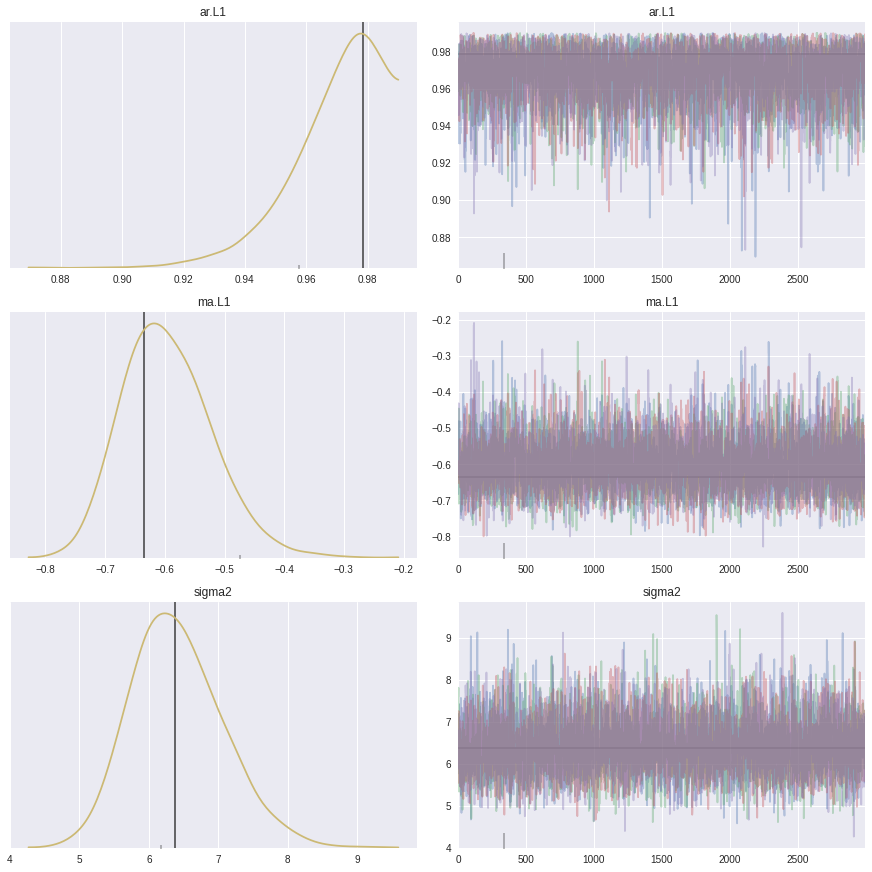

In [9]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.traceplot(trace,
                 lines=[(k, {}, [v]) for k, v in dict(res_mle.params).items()],
                 combined=True,
                 figsize=(12, 12))

The estimated posteriors clearly peak close to the parameters found by MLE. We can also see a summary of the estimated values:

In [10]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ar.L1,0.969,0.015,0.943,0.990,0.000,0.000,4750.0,4743.0,4111.0,3382.0,1.0
ma.L1,-0.597,0.075,-0.730,-0.459,0.001,0.001,5669.0,5669.0,6048.0,5139.0,1.0
sigma2,6.402,0.658,5.279,7.721,0.008,0.006,6328.0,6238.0,6426.0,6404.0,1.0


Here $\hat{R}$ is the Gelman-Rubin statistic. It tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. If $\hat{R}<1.2$ for all model parameters, we can have some confidence that convergence has been reached.

Additionally, the highest posterior density interval (the gap between the two values of HPD in the table) is small for each of the variables.

### 6. Application of Bayesian estimates of parameters

We'll now re-instigate a version of the model but using the parameters from the Bayesian estimation, and again plot the one-step-ahead forecasts.

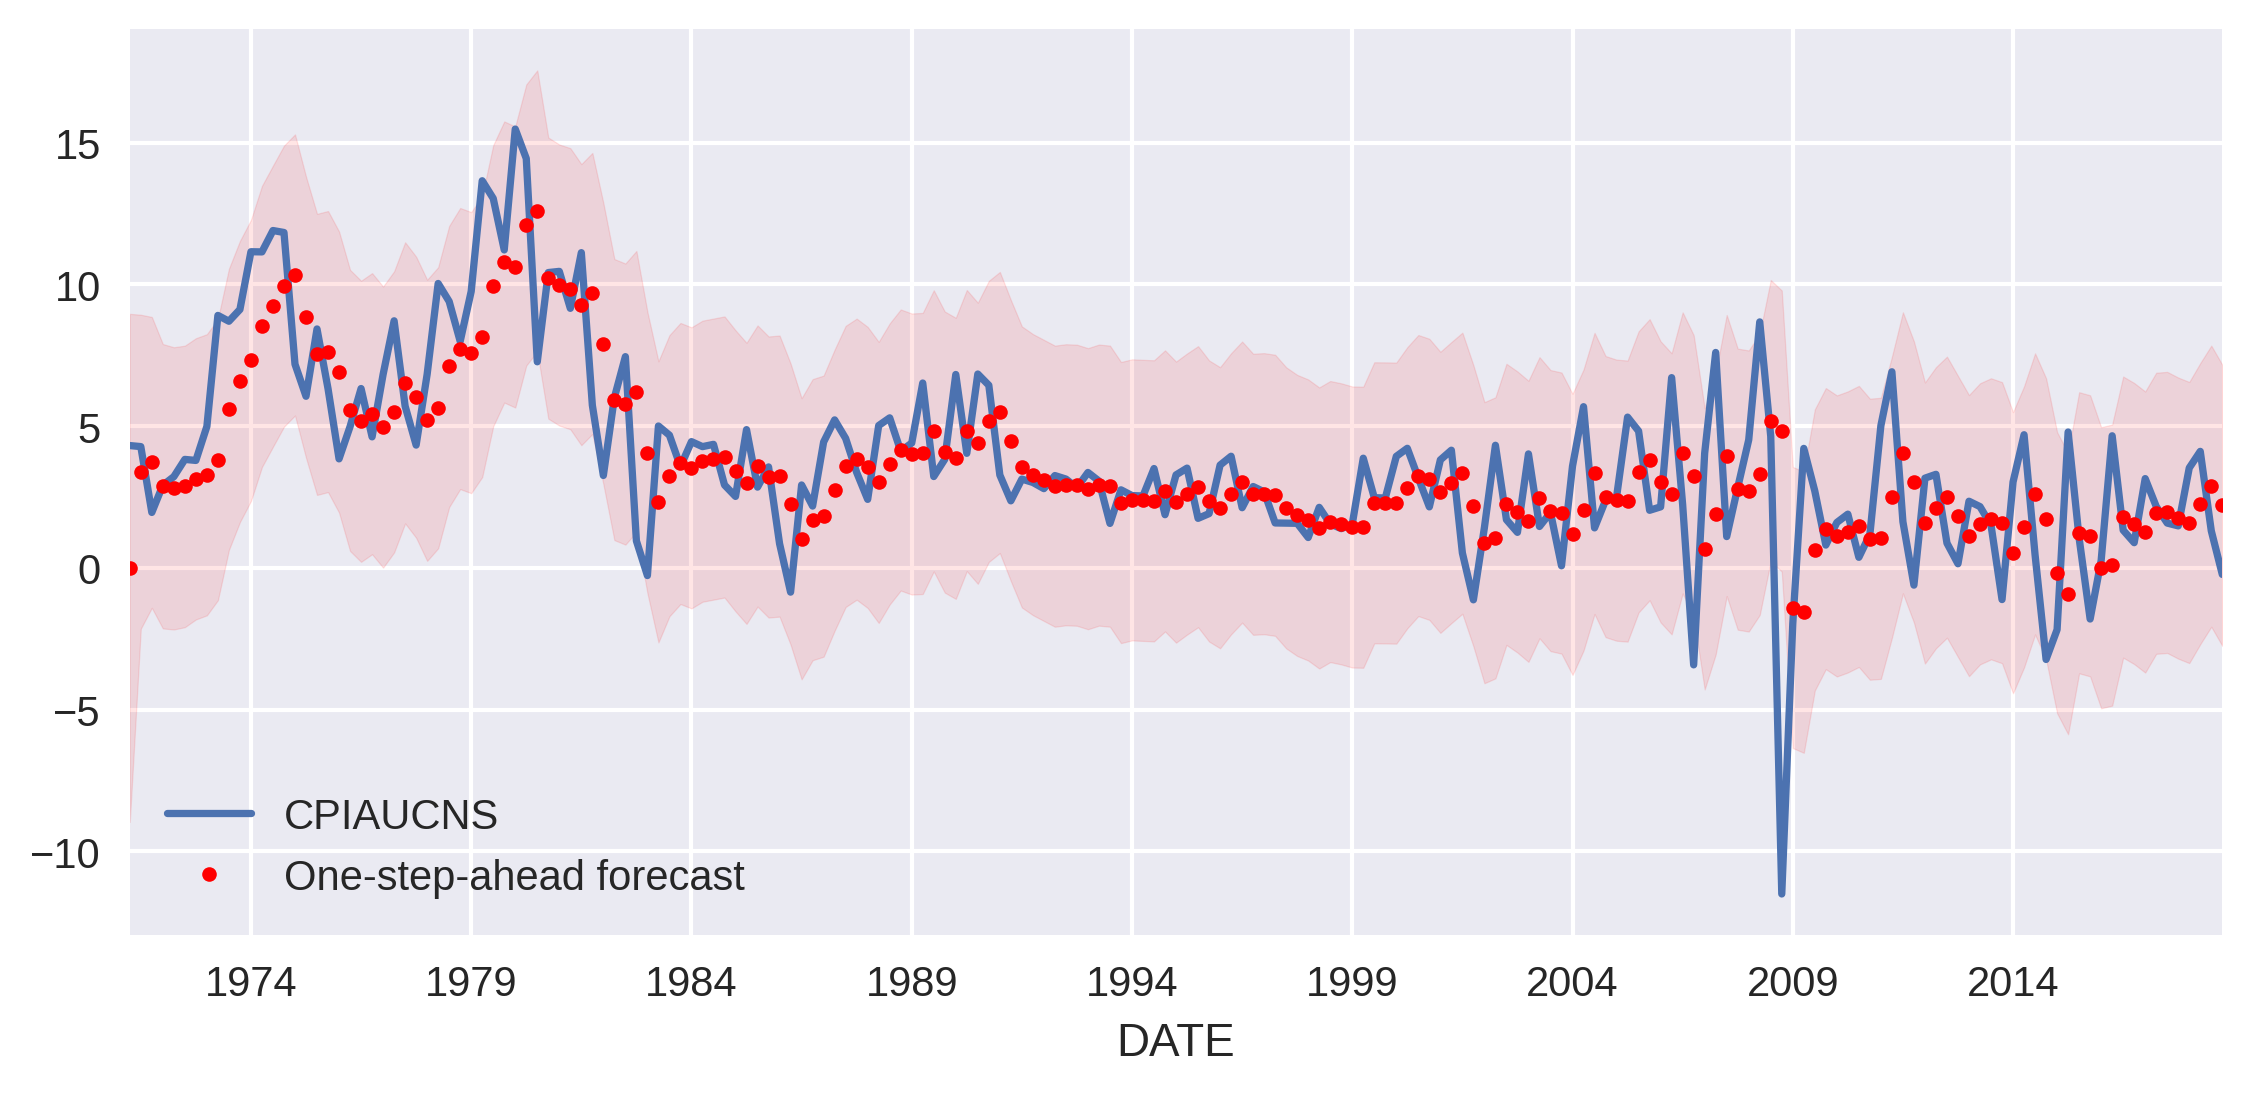

In [11]:
# Retrieve the posterior means
params = pm.summary(trace)['mean'].values

# Construct results using these posterior means as parameter values
res_bayes = mod.smooth(params)

predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci['lower CPIAUCNS']
upper = predict_bayes_ci['upper CPIAUCNS']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
inf.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_bayes_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
plt.show()

## Appendix A. Application to `UnobservedComponents` models

We can reuse the `Loglike` and `Score` wrappers defined above to consider a different state space model. For example, we might want to model inflation as the combination of a random walk trend and autoregressive error term:

$$
\begin{aligned}
y_t & = \mu_t + \varepsilon_t \\
\mu_t & = \mu_{t-1} + \eta_t \\
\varepsilon_t &= \phi \varepsilon_t + \zeta_t
\end{aligned}
$$

This model can be constructed in Statsmodels with the `UnobservedComponents` class using the `rwalk` and `autoregressive` specifications. As before, we can fit the model using maximum likelihood via the `fit` method.

In [12]:
# Construct the model instance
mod_uc = sm.tsa.UnobservedComponents(inf, 'rwalk', autoregressive=1)

# Fit the model via maximum likelihood
res_uc_mle = mod_uc.fit()
print(res_uc_mle.summary())

                        Unobserved Components Results                         
Dep. Variable:               CPIAUCNS   No. Observations:                  191
Model:                    random walk   Log Likelihood                -440.855
                              + AR(1)   AIC                            887.709
Date:                Tue, 02 Feb 2021   BIC                            897.450
Time:                        07:01:53   HQIC                           891.655
Sample:                    04-01-1971                                         
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level     0.2037      0.156      1.310      0.190      -0.101       0.508
sigma2.ar        5.2920      0.338     15.665 

As noted earlier, the Theano wrappers (`Loglike` and `Score`) that we created above are generic, so we can re-use essentially the same code to explore the model with Bayesian methods.

In [13]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600   # number of "burn-in points" (which will be discarded)

In [14]:
# Here we follow the same procedure as above, but now we instantiate the
# Theano wrapper `Loglike` with the UC model instance instead of the
# SARIMAX model instance
loglike_uc = Loglike(mod_uc)

with pm.Model():
    # Priors
    sigma2level = pm.InverseGamma('sigma2.level', 1, 1)
    sigma2ar = pm.InverseGamma('sigma2.ar', 1, 1)
    arL1 = pm.Uniform('ar.L1', -0.99, 0.99)

    # convert variables to tensor vectors
    theta_uc = tt.as_tensor_variable([sigma2level, sigma2ar, arL1])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: loglike_uc(v), observed={'v': theta_uc})
    
    # Draw samples
    trace_uc = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True, cores=4)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [ar.L1, sigma2.ar, sigma2.level]


Sampling 4 chains, 0 divergences:   0%|          | 0/14400 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 7/14400 [00:00<04:01, 59.67draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 13/14400 [00:00<04:41, 51.02draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 19/14400 [00:00<04:26, 54.06draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/14400 [00:00<05:09, 46.45draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 32/14400 [00:00<05:23, 44.40draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/14400 [00:00<05:44, 41.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 42/14400 [00:01<06:54, 34.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 48/14400 [00:01<05:58, 40.00draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 53/14400 [00:01<06:29, 36.85draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 57/14400 [00:01<07:11, 33.20draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 63/14400 [00:01<06:45, 35.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/14400 [00:01<05:16, 45.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 77/14400 [00:01<06:57, 34.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 81/14400 [00:02<09:14, 25.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 85/14400 [00:02<08:56, 26.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 89/14400 [00:02<12:08, 19.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 94/14400 [00:02<10:42, 22.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 98/14400 [00:03<09:33, 24.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 102/14400 [00:03<08:52, 26.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 106/14400 [00:03<11:07, 21.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 109/14400 [00:03<11:44, 20.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 114/14400 [00:03<09:38, 24.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 119/14400 [00:03<08:23, 28.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 123/14400 [00:04<12:53, 18.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 126/14400 [00:04<12:00, 19.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 129/14400 [00:04<12:42, 18.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/14400 [00:04<12:21, 19.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 136/14400 [00:04<10:17, 23.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 139/14400 [00:04<11:12, 21.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/14400 [00:05<11:06, 21.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/14400 [00:05<10:37, 22.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 152/14400 [00:05<08:31, 27.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/14400 [00:05<08:10, 29.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/14400 [00:05<07:32, 31.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/14400 [00:05<08:32, 27.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 169/14400 [00:05<08:13, 28.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/14400 [00:06<07:51, 30.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 177/14400 [00:06<11:15, 21.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 180/14400 [00:06<12:21, 19.18draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 185/14400 [00:06<10:39, 22.22draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 188/14400 [00:06<10:00, 23.65draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 192/14400 [00:07<09:04, 26.11draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 195/14400 [00:07<14:46, 16.03draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 198/14400 [00:07<14:27, 16.37draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 202/14400 [00:07<11:37, 20.36draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 207/14400 [00:07<09:31, 24.85draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 211/14400 [00:07<08:58, 26.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 215/14400 [00:08<08:39, 27.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 221/14400 [00:08<07:01, 33.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 225/14400 [00:08<07:25, 31.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 229/14400 [00:08<07:30, 31.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 234/14400 [00:08<06:37, 35.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 238/14400 [00:08<07:10, 32.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 242/14400 [00:08<06:54, 34.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 246/14400 [00:09<08:42, 27.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 250/14400 [00:09<07:58, 29.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 254/14400 [00:09<08:50, 26.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 257/14400 [00:09<09:54, 23.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 262/14400 [00:09<08:25, 27.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 268/14400 [00:09<07:01, 33.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 272/14400 [00:09<07:42, 30.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 276/14400 [00:10<07:13, 32.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 280/14400 [00:10<08:30, 27.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 284/14400 [00:10<07:49, 30.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 288/14400 [00:10<07:55, 29.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 292/14400 [00:10<08:12, 28.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 295/14400 [00:10<09:00, 26.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 301/14400 [00:10<07:13, 32.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 305/14400 [00:11<07:24, 31.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 310/14400 [00:11<06:36, 35.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 314/14400 [00:11<06:38, 35.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 321/14400 [00:11<05:59, 39.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 325/14400 [00:11<06:44, 34.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 330/14400 [00:11<06:11, 37.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 334/14400 [00:11<06:50, 34.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 340/14400 [00:11<06:05, 38.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 346/14400 [00:12<05:32, 42.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 351/14400 [00:12<06:13, 37.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 355/14400 [00:12<06:16, 37.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 361/14400 [00:12<05:30, 42.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 367/14400 [00:12<05:48, 40.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 372/14400 [00:12<06:08, 38.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 376/14400 [00:12<06:23, 36.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 381/14400 [00:12<05:56, 39.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 387/14400 [00:13<05:22, 43.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 394/14400 [00:13<04:42, 49.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 400/14400 [00:13<05:29, 42.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 405/14400 [00:13<05:21, 43.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 410/14400 [00:13<06:10, 37.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 415/14400 [00:13<05:57, 39.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 420/14400 [00:13<05:39, 41.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 425/14400 [00:13<05:23, 43.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 430/14400 [00:14<08:38, 26.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 434/14400 [00:14<08:01, 29.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 438/14400 [00:14<08:18, 27.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 442/14400 [00:14<10:18, 22.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 446/14400 [00:14<09:28, 24.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 451/14400 [00:15<07:56, 29.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 456/14400 [00:15<07:07, 32.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 462/14400 [00:15<06:05, 38.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 467/14400 [00:15<06:19, 36.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 472/14400 [00:15<06:10, 37.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 478/14400 [00:15<05:45, 40.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 483/14400 [00:15<05:30, 42.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 488/14400 [00:15<05:36, 41.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 494/14400 [00:16<05:02, 45.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 499/14400 [00:16<05:11, 44.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 505/14400 [00:16<05:22, 43.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 512/14400 [00:16<05:32, 41.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 517/14400 [00:16<07:06, 32.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 523/14400 [00:16<06:30, 35.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 530/14400 [00:16<05:31, 41.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 537/14400 [00:17<04:53, 47.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 543/14400 [00:17<05:07, 45.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 548/14400 [00:17<05:38, 40.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 556/14400 [00:17<04:40, 49.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 562/14400 [00:17<04:44, 48.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 568/14400 [00:17<04:52, 47.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 577/14400 [00:17<03:59, 57.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 584/14400 [00:18<04:40, 49.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 593/14400 [00:18<03:59, 57.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 600/14400 [00:18<04:22, 52.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 606/14400 [00:18<04:40, 49.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 612/14400 [00:18<04:52, 47.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 617/14400 [00:18<04:53, 46.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 622/14400 [00:18<05:26, 42.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 628/14400 [00:19<05:24, 42.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 635/14400 [00:19<04:54, 46.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 640/14400 [00:19<05:11, 44.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 646/14400 [00:19<04:53, 46.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 652/14400 [00:19<04:47, 47.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 657/14400 [00:19<05:00, 45.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 664/14400 [00:19<04:27, 51.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 671/14400 [00:19<04:11, 54.54draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 677/14400 [00:19<04:14, 53.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 685/14400 [00:20<04:03, 56.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 691/14400 [00:20<04:23, 52.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 697/14400 [00:20<04:16, 53.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 703/14400 [00:20<04:15, 53.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 709/14400 [00:20<04:23, 51.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 715/14400 [00:20<04:19, 52.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 721/14400 [00:20<04:13, 53.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 728/14400 [00:20<03:54, 58.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 734/14400 [00:20<03:54, 58.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 740/14400 [00:21<03:53, 58.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 747/14400 [00:21<03:45, 60.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 755/14400 [00:21<03:41, 61.62draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 762/14400 [00:21<03:34, 63.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 769/14400 [00:21<03:29, 65.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 776/14400 [00:21<03:33, 63.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 783/14400 [00:21<03:39, 62.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 790/14400 [00:21<03:43, 60.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 797/14400 [00:21<03:41, 61.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 804/14400 [00:22<04:20, 52.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 810/14400 [00:22<04:31, 50.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 816/14400 [00:22<04:22, 51.70draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 823/14400 [00:22<04:02, 56.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 829/14400 [00:22<04:03, 55.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 835/14400 [00:22<04:03, 55.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 841/14400 [00:22<04:32, 49.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 847/14400 [00:23<04:36, 49.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 856/14400 [00:23<04:04, 55.28draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 862/14400 [00:23<04:09, 54.37draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 868/14400 [00:23<04:32, 49.70draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 874/14400 [00:23<04:48, 46.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 881/14400 [00:23<04:43, 47.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 888/14400 [00:23<04:33, 49.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 893/14400 [00:23<04:42, 47.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 899/14400 [00:24<04:39, 48.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 904/14400 [00:24<04:49, 46.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 909/14400 [00:24<04:55, 45.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 915/14400 [00:24<04:51, 46.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 921/14400 [00:24<04:36, 48.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 926/14400 [00:24<04:50, 46.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 931/14400 [00:24<04:48, 46.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 938/14400 [00:24<04:35, 48.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 943/14400 [00:24<04:47, 46.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 950/14400 [00:25<04:15, 52.70draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 956/14400 [00:25<04:08, 54.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 962/14400 [00:25<04:08, 54.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 968/14400 [00:25<04:04, 55.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 977/14400 [00:25<03:30, 63.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 986/14400 [00:25<03:08, 71.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 996/14400 [00:25<02:54, 76.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1004/14400 [00:25<03:07, 71.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1012/14400 [00:26<03:35, 62.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1021/14400 [00:26<03:14, 68.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1029/14400 [00:26<03:17, 67.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1037/14400 [00:26<04:16, 52.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1043/14400 [00:26<04:25, 50.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1049/14400 [00:26<04:26, 50.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1055/14400 [00:26<04:50, 45.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1062/14400 [00:27<04:32, 49.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1070/14400 [00:27<04:05, 54.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1076/14400 [00:27<04:03, 54.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1082/14400 [00:27<04:00, 55.33draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1091/14400 [00:27<03:32, 62.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1101/14400 [00:27<03:13, 68.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1112/14400 [00:27<02:47, 79.41draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1121/14400 [00:27<02:54, 75.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1131/14400 [00:27<02:42, 81.57draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1140/14400 [00:28<02:50, 77.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1148/14400 [00:28<03:05, 71.33draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1156/14400 [00:28<03:03, 72.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1164/14400 [00:28<03:12, 68.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1172/14400 [00:28<03:22, 65.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1179/14400 [00:28<03:53, 56.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1186/14400 [00:28<03:45, 58.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1193/14400 [00:28<03:57, 55.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1199/14400 [00:29<04:01, 54.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1206/14400 [00:29<03:48, 57.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1212/14400 [00:29<03:48, 57.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1218/14400 [00:29<03:49, 57.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1225/14400 [00:29<03:49, 57.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1233/14400 [00:29<03:33, 61.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1243/14400 [00:29<03:08, 69.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1251/14400 [00:29<03:26, 63.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1258/14400 [00:30<03:22, 64.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1268/14400 [00:30<03:08, 69.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1276/14400 [00:30<03:23, 64.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1283/14400 [00:30<03:31, 62.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1290/14400 [00:30<03:32, 61.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1298/14400 [00:30<03:20, 65.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1305/14400 [00:30<03:52, 56.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1313/14400 [00:30<03:49, 57.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1320/14400 [00:31<03:37, 60.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1329/14400 [00:31<03:18, 65.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1336/14400 [00:31<03:22, 64.41draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1343/14400 [00:31<03:45, 57.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1351/14400 [00:31<03:31, 61.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1359/14400 [00:31<03:28, 62.46draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1367/14400 [00:31<03:21, 64.74draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1377/14400 [00:31<03:04, 70.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1385/14400 [00:32<03:19, 65.09draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1392/14400 [00:32<03:30, 61.69draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1399/14400 [00:32<03:48, 56.99draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1407/14400 [00:32<03:29, 62.03draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1414/14400 [00:32<03:46, 57.44draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1420/14400 [00:32<03:45, 57.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1426/14400 [00:32<03:49, 56.45draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1433/14400 [00:32<03:37, 59.61draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1440/14400 [00:32<03:33, 60.70draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1448/14400 [00:33<03:29, 61.87draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1456/14400 [00:33<03:24, 63.44draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1467/14400 [00:33<02:51, 75.30draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1476/14400 [00:33<02:50, 75.64draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1484/14400 [00:33<03:02, 70.75draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1495/14400 [00:33<02:39, 80.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1507/14400 [00:33<02:28, 86.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1516/14400 [00:33<02:31, 85.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1525/14400 [00:34<02:34, 83.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1534/14400 [00:34<02:31, 84.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1543/14400 [00:34<02:42, 78.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1552/14400 [00:34<02:53, 73.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1562/14400 [00:34<02:45, 77.62draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1570/14400 [00:34<02:48, 75.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1578/14400 [00:34<03:04, 69.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1586/14400 [00:34<03:02, 70.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1594/14400 [00:34<02:59, 71.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1603/14400 [00:35<02:54, 73.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1611/14400 [00:35<03:06, 68.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1619/14400 [00:35<03:00, 70.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1628/14400 [00:35<02:49, 75.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1636/14400 [00:35<02:48, 75.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1644/14400 [00:35<02:52, 73.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1652/14400 [00:35<02:53, 73.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1660/14400 [00:35<02:53, 73.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1668/14400 [00:36<03:04, 69.03draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1676/14400 [00:36<03:02, 69.81draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1684/14400 [00:36<03:16, 64.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1692/14400 [00:36<03:08, 67.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1699/14400 [00:36<03:07, 67.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1706/14400 [00:36<03:44, 56.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1712/14400 [00:36<03:50, 55.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1718/14400 [00:36<04:06, 51.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1724/14400 [00:37<04:10, 50.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1730/14400 [00:37<04:15, 49.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1736/14400 [00:37<04:10, 50.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1742/14400 [00:37<04:20, 48.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1750/14400 [00:37<03:50, 54.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1756/14400 [00:37<03:54, 54.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1762/14400 [00:37<03:55, 53.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1768/14400 [00:37<03:50, 54.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1777/14400 [00:37<03:28, 60.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1786/14400 [00:38<03:26, 60.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1795/14400 [00:38<03:11, 65.70draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1803/14400 [00:38<03:06, 67.47draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1811/14400 [00:38<03:00, 69.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1819/14400 [00:38<02:57, 71.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1829/14400 [00:38<02:52, 72.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1837/14400 [00:38<02:49, 74.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1845/14400 [00:38<02:49, 74.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1853/14400 [00:39<02:54, 71.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1861/14400 [00:39<03:11, 65.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1868/14400 [00:39<03:23, 61.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1876/14400 [00:39<03:19, 62.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1883/14400 [00:39<03:17, 63.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1890/14400 [00:39<03:20, 62.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1897/14400 [00:39<03:38, 57.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1903/14400 [00:39<03:43, 55.91draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1910/14400 [00:40<03:36, 57.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1919/14400 [00:40<03:09, 65.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1926/14400 [00:40<03:19, 62.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1934/14400 [00:40<03:14, 64.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1942/14400 [00:40<03:11, 65.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1950/14400 [00:40<03:04, 67.59draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1958/14400 [00:40<02:58, 69.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1968/14400 [00:40<02:43, 75.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1976/14400 [00:40<02:51, 72.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1984/14400 [00:41<02:51, 72.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1993/14400 [00:41<02:46, 74.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2002/14400 [00:41<02:38, 78.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2011/14400 [00:41<02:33, 80.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2020/14400 [00:41<02:29, 82.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2030/14400 [00:41<02:24, 85.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2039/14400 [00:41<02:40, 76.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2047/14400 [00:41<02:49, 73.05draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2055/14400 [00:42<03:09, 64.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2062/14400 [00:42<03:10, 64.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2071/14400 [00:42<02:55, 70.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2079/14400 [00:42<03:00, 68.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2089/14400 [00:42<02:45, 74.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2097/14400 [00:42<02:42, 75.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2105/14400 [00:42<02:47, 73.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2114/14400 [00:42<02:40, 76.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2124/14400 [00:42<02:29, 82.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2133/14400 [00:43<02:32, 80.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2142/14400 [00:43<02:48, 72.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2150/14400 [00:43<03:03, 66.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2160/14400 [00:43<02:45, 74.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2168/14400 [00:43<02:51, 71.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2176/14400 [00:43<02:54, 69.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2184/14400 [00:43<02:49, 72.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2192/14400 [00:43<02:55, 69.41draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2200/14400 [00:44<03:11, 63.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2207/14400 [00:44<03:34, 56.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2214/14400 [00:44<03:23, 59.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2223/14400 [00:44<03:04, 65.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2231/14400 [00:44<03:02, 66.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2240/14400 [00:44<02:56, 69.03draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2248/14400 [00:44<02:55, 69.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2257/14400 [00:44<02:45, 73.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2266/14400 [00:44<02:39, 76.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2274/14400 [00:45<02:41, 74.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2282/14400 [00:45<02:49, 71.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2291/14400 [00:45<02:40, 75.64draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2299/14400 [00:45<02:40, 75.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2307/14400 [00:45<02:51, 70.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2316/14400 [00:45<02:48, 71.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2325/14400 [00:45<02:38, 76.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2333/14400 [00:45<02:43, 73.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2342/14400 [00:45<02:37, 76.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2350/14400 [00:46<02:57, 68.03draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2357/14400 [00:46<02:56, 68.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2365/14400 [00:46<02:55, 68.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2375/14400 [00:46<02:46, 72.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2385/14400 [00:46<02:32, 78.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2394/14400 [00:46<02:32, 78.55draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2404/14400 [00:46<02:22, 84.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2413/14400 [00:46<02:20, 85.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2422/14400 [00:47<02:34, 77.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2430/14400 [00:47<02:44, 72.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2438/14400 [00:47<02:50, 70.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2446/14400 [00:47<02:51, 69.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2454/14400 [00:47<02:52, 69.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2461/14400 [00:47<02:56, 67.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2468/14400 [00:47<03:05, 64.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2475/14400 [00:47<03:23, 58.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2482/14400 [00:48<03:22, 58.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2489/14400 [00:48<03:21, 59.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2496/14400 [00:48<03:14, 61.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2503/14400 [00:48<03:24, 58.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2510/14400 [00:48<03:27, 57.38draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2516/14400 [00:48<03:27, 57.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2523/14400 [00:48<03:26, 57.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2530/14400 [00:48<03:27, 57.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2536/14400 [00:48<03:41, 53.65draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2546/14400 [00:49<03:12, 61.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2557/14400 [00:49<02:41, 73.21draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2565/14400 [00:49<02:43, 72.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2573/14400 [00:49<03:03, 64.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2582/14400 [00:49<02:48, 70.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2591/14400 [00:49<02:41, 73.03draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2602/14400 [00:49<02:25, 81.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2611/14400 [00:49<02:32, 77.12draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2619/14400 [00:50<02:36, 75.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2627/14400 [00:50<02:37, 74.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2635/14400 [00:50<02:42, 72.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2643/14400 [00:50<02:40, 73.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2651/14400 [00:50<02:44, 71.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2659/14400 [00:50<02:54, 67.48draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2666/14400 [00:50<02:59, 65.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2673/14400 [00:50<03:11, 61.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2681/14400 [00:51<03:09, 61.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2691/14400 [00:51<02:46, 70.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2699/14400 [00:51<03:01, 64.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2706/14400 [00:51<03:10, 61.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2713/14400 [00:51<03:08, 62.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2720/14400 [00:51<03:10, 61.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2727/14400 [00:51<03:05, 62.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2735/14400 [00:51<02:53, 67.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2742/14400 [00:51<03:15, 59.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2749/14400 [00:52<03:19, 58.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2756/14400 [00:52<03:11, 60.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2763/14400 [00:52<03:12, 60.40draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2770/14400 [00:52<03:08, 61.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2780/14400 [00:52<02:56, 65.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2788/14400 [00:52<02:59, 64.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2795/14400 [00:52<03:01, 63.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 2803/14400 [00:52<03:00, 64.33draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2811/14400 [00:53<02:52, 67.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2819/14400 [00:53<02:46, 69.71draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2827/14400 [00:53<02:42, 71.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2835/14400 [00:53<02:56, 65.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2843/14400 [00:53<02:47, 68.97draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2851/14400 [00:53<02:44, 70.17draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2859/14400 [00:53<02:47, 68.87draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2870/14400 [00:53<02:31, 76.31draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 2879/14400 [00:53<02:25, 79.13draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2887/14400 [00:54<02:26, 78.37draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2895/14400 [00:54<02:34, 74.30draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2905/14400 [00:54<02:25, 78.88draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2913/14400 [00:54<02:29, 76.73draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2923/14400 [00:54<02:18, 82.93draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2932/14400 [00:54<02:18, 82.53draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2941/14400 [00:54<02:25, 78.69draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 2949/14400 [00:54<02:37, 72.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2960/14400 [00:55<02:29, 76.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2969/14400 [00:55<02:27, 77.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2980/14400 [00:55<02:13, 85.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2989/14400 [00:55<02:14, 84.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 2998/14400 [00:55<02:14, 84.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3007/14400 [00:55<02:16, 83.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3018/14400 [00:55<02:10, 87.35draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3031/14400 [00:55<01:56, 97.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3041/14400 [00:55<02:08, 88.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3052/14400 [00:56<02:04, 91.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3062/14400 [00:56<02:16, 83.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3071/14400 [00:56<02:31, 74.92draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3079/14400 [00:56<02:34, 73.06draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3087/14400 [00:56<02:45, 68.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3096/14400 [00:56<02:38, 71.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3104/14400 [00:56<02:37, 71.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3112/14400 [00:56<02:56, 64.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3122/14400 [00:57<02:44, 68.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3130/14400 [00:57<02:46, 67.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3137/14400 [00:57<02:53, 65.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3144/14400 [00:57<02:55, 64.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3151/14400 [00:57<02:54, 64.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3158/14400 [00:57<02:51, 65.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3165/14400 [00:57<03:01, 61.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3172/14400 [00:57<03:05, 60.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3181/14400 [00:58<02:49, 66.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3191/14400 [00:58<02:35, 72.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3199/14400 [00:58<02:41, 69.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3206/14400 [00:58<02:43, 68.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3216/14400 [00:58<02:28, 75.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3224/14400 [00:58<02:32, 73.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3233/14400 [00:58<02:23, 77.79draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3241/14400 [00:58<02:29, 74.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3249/14400 [00:58<02:32, 73.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3257/14400 [00:59<02:44, 67.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3266/14400 [00:59<02:34, 71.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3274/14400 [00:59<02:35, 71.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3283/14400 [00:59<02:29, 74.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3292/14400 [00:59<02:23, 77.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3301/14400 [00:59<02:17, 80.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3310/14400 [00:59<02:19, 79.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3320/14400 [00:59<02:10, 84.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3329/14400 [00:59<02:12, 83.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3338/14400 [01:00<02:17, 80.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3347/14400 [01:00<02:30, 73.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3355/14400 [01:00<02:39, 69.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3363/14400 [01:00<02:46, 66.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3370/14400 [01:00<03:09, 58.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3377/14400 [01:00<03:20, 54.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3383/14400 [01:00<03:30, 52.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3389/14400 [01:01<03:29, 52.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3397/14400 [01:01<03:08, 58.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3406/14400 [01:01<02:46, 66.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3414/14400 [01:01<02:40, 68.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3423/14400 [01:01<02:27, 74.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3432/14400 [01:01<02:26, 74.96draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3443/14400 [01:01<02:11, 83.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3452/14400 [01:01<02:14, 81.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3461/14400 [01:01<02:24, 75.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3472/14400 [01:02<02:17, 79.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3481/14400 [01:02<02:24, 75.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3489/14400 [01:02<02:23, 76.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3497/14400 [01:02<02:36, 69.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3506/14400 [01:02<02:33, 70.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3515/14400 [01:02<02:25, 74.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3524/14400 [01:02<02:23, 75.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3532/14400 [01:02<02:31, 71.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3541/14400 [01:03<02:29, 72.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3549/14400 [01:03<02:33, 70.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3557/14400 [01:03<02:28, 72.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3565/14400 [01:03<02:29, 72.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3573/14400 [01:03<02:27, 73.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3581/14400 [01:03<02:25, 74.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3589/14400 [01:03<02:29, 72.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3597/14400 [01:03<02:26, 73.56draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 3607/14400 [01:03<02:13, 80.88draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 3616/14400 [01:03<02:13, 80.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 3625/14400 [01:04<02:13, 80.73draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 3634/14400 [01:04<02:41, 66.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 3642/14400 [01:04<02:39, 67.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 3650/14400 [01:04<02:33, 70.24draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 3658/14400 [01:04<02:39, 67.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 3665/14400 [01:04<02:46, 64.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3673/14400 [01:04<02:38, 67.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3681/14400 [01:04<02:32, 70.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3691/14400 [01:05<02:19, 76.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3699/14400 [01:05<02:21, 75.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3707/14400 [01:05<02:41, 66.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3714/14400 [01:05<02:48, 63.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3721/14400 [01:05<03:10, 56.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3727/14400 [01:05<03:16, 54.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3734/14400 [01:05<03:13, 55.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3741/14400 [01:05<03:06, 57.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3749/14400 [01:06<02:48, 63.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3757/14400 [01:06<02:48, 63.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3766/14400 [01:06<02:33, 69.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 3774/14400 [01:06<02:36, 67.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 3781/14400 [01:06<02:44, 64.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 3789/14400 [01:06<02:34, 68.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 3797/14400 [01:06<02:31, 70.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 3805/14400 [01:06<02:48, 62.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 3812/14400 [01:07<02:46, 63.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3821/14400 [01:07<02:33, 69.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3829/14400 [01:07<02:37, 67.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3836/14400 [01:07<02:51, 61.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3844/14400 [01:07<02:48, 62.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3852/14400 [01:07<02:49, 62.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3859/14400 [01:07<03:00, 58.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3865/14400 [01:07<03:11, 54.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3871/14400 [01:08<03:19, 52.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3877/14400 [01:08<03:22, 51.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3883/14400 [01:08<03:19, 52.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3891/14400 [01:08<02:57, 59.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3898/14400 [01:08<02:53, 60.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3905/14400 [01:08<02:53, 60.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3912/14400 [01:08<02:55, 59.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3919/14400 [01:08<03:00, 58.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3927/14400 [01:08<02:44, 63.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3934/14400 [01:09<02:43, 64.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3943/14400 [01:09<02:35, 67.45draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 3952/14400 [01:09<02:25, 71.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 3961/14400 [01:09<02:17, 76.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 3970/14400 [01:09<02:13, 78.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 3978/14400 [01:09<02:27, 70.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 3987/14400 [01:09<02:20, 74.18draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 3996/14400 [01:09<02:22, 72.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4005/14400 [01:09<02:17, 75.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4017/14400 [01:10<02:01, 85.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4026/14400 [01:10<02:03, 83.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4035/14400 [01:10<02:08, 80.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4045/14400 [01:10<02:01, 84.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4054/14400 [01:10<02:03, 83.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4063/14400 [01:10<02:10, 79.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4073/14400 [01:10<02:07, 80.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4082/14400 [01:10<02:14, 76.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4091/14400 [01:11<02:10, 79.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4101/14400 [01:11<02:03, 83.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4110/14400 [01:11<02:06, 81.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4119/14400 [01:11<02:04, 82.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4129/14400 [01:11<01:59, 85.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4139/14400 [01:11<02:03, 83.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4148/14400 [01:11<02:02, 83.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4157/14400 [01:11<02:07, 80.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4166/14400 [01:11<02:04, 82.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4175/14400 [01:12<02:08, 79.59draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4185/14400 [01:12<02:02, 83.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4194/14400 [01:12<02:05, 81.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4203/14400 [01:12<02:24, 70.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4211/14400 [01:12<02:25, 69.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4219/14400 [01:12<02:30, 67.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4226/14400 [01:12<02:36, 64.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4233/14400 [01:12<02:41, 62.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4240/14400 [01:13<02:39, 63.72draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4247/14400 [01:13<02:44, 61.55draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4254/14400 [01:13<02:46, 61.00draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4262/14400 [01:13<02:34, 65.52draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4269/14400 [01:13<02:43, 62.14draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4276/14400 [01:13<02:43, 61.98draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4283/14400 [01:13<02:41, 62.74draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4290/14400 [01:13<02:43, 61.75draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4297/14400 [01:13<02:44, 61.34draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4304/14400 [01:14<02:47, 60.19draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4312/14400 [01:14<02:43, 61.83draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4320/14400 [01:14<02:39, 63.39draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4328/14400 [01:14<02:28, 67.64draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4336/14400 [01:14<02:26, 68.57draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4343/14400 [01:14<02:28, 67.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4351/14400 [01:14<02:22, 70.68draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4359/14400 [01:14<02:21, 70.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4368/14400 [01:14<02:15, 74.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4377/14400 [01:15<02:12, 75.85draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4387/14400 [01:15<02:07, 78.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4396/14400 [01:15<02:04, 80.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4405/14400 [01:15<02:07, 78.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4413/14400 [01:15<02:14, 74.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4421/14400 [01:15<02:12, 75.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4431/14400 [01:15<02:06, 79.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4440/14400 [01:15<02:01, 81.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4449/14400 [01:16<02:07, 78.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4457/14400 [01:16<02:27, 67.62draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4465/14400 [01:16<02:29, 66.31draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4472/14400 [01:16<02:33, 64.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4479/14400 [01:16<02:39, 62.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4486/14400 [01:16<02:52, 57.62draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4492/14400 [01:16<02:50, 58.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4499/14400 [01:16<02:47, 59.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 4508/14400 [01:16<02:31, 65.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 4515/14400 [01:17<02:32, 64.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 4523/14400 [01:17<02:23, 68.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 4530/14400 [01:17<02:29, 65.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4537/14400 [01:17<02:32, 64.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4544/14400 [01:17<02:40, 61.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4551/14400 [01:17<02:38, 62.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4558/14400 [01:17<02:37, 62.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4565/14400 [01:17<02:43, 60.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4572/14400 [01:18<02:51, 57.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4578/14400 [01:18<02:53, 56.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4587/14400 [01:18<02:38, 61.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4595/14400 [01:18<02:33, 63.98draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4604/14400 [01:18<02:19, 70.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4613/14400 [01:18<02:11, 74.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4621/14400 [01:18<02:16, 71.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4630/14400 [01:18<02:12, 73.48draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4639/14400 [01:18<02:07, 76.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4647/14400 [01:19<02:06, 77.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4655/14400 [01:19<02:19, 69.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4665/14400 [01:19<02:05, 77.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 4673/14400 [01:19<02:12, 73.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4682/14400 [01:19<02:05, 77.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4691/14400 [01:19<02:03, 78.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4700/14400 [01:19<02:05, 77.47draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4708/14400 [01:19<02:04, 77.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4719/14400 [01:19<01:56, 83.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4728/14400 [01:20<01:54, 84.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4737/14400 [01:20<02:01, 79.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4747/14400 [01:20<01:55, 83.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4756/14400 [01:20<01:54, 84.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4765/14400 [01:20<01:59, 80.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4774/14400 [01:20<02:05, 76.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4782/14400 [01:20<02:05, 76.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4790/14400 [01:20<02:06, 75.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4800/14400 [01:20<02:00, 80.00draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4809/14400 [01:21<02:04, 77.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 4818/14400 [01:21<02:07, 75.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 4826/14400 [01:21<02:07, 75.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 4834/14400 [01:21<02:10, 73.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 4842/14400 [01:21<02:09, 73.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 4851/14400 [01:21<02:04, 76.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 4859/14400 [01:21<02:03, 77.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4868/14400 [01:21<02:00, 78.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4876/14400 [01:22<02:04, 76.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4884/14400 [01:22<02:06, 75.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4893/14400 [01:22<02:03, 77.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4903/14400 [01:22<02:01, 78.10draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4912/14400 [01:22<02:00, 78.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4920/14400 [01:22<02:06, 74.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4929/14400 [01:22<02:03, 76.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4937/14400 [01:22<02:03, 76.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4945/14400 [01:22<02:03, 76.79draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4955/14400 [01:23<01:59, 78.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 4963/14400 [01:23<02:07, 73.92draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 4971/14400 [01:23<02:13, 70.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 4979/14400 [01:23<02:19, 67.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 4986/14400 [01:23<02:29, 63.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 4993/14400 [01:23<02:31, 61.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5000/14400 [01:23<02:35, 60.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5007/14400 [01:23<02:29, 62.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5014/14400 [01:23<02:25, 64.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5024/14400 [01:24<02:10, 72.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5032/14400 [01:24<02:10, 71.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5042/14400 [01:24<02:01, 77.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5051/14400 [01:24<01:59, 78.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5061/14400 [01:24<01:51, 84.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5070/14400 [01:24<01:59, 77.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5078/14400 [01:24<02:04, 74.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5088/14400 [01:24<01:55, 80.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5097/14400 [01:24<01:54, 81.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5106/14400 [01:25<01:57, 79.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5115/14400 [01:25<01:58, 78.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5124/14400 [01:25<01:56, 79.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5133/14400 [01:25<01:57, 78.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5143/14400 [01:25<01:55, 80.29draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5152/14400 [01:25<02:12, 69.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5160/14400 [01:25<02:15, 68.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5168/14400 [01:25<02:13, 69.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5177/14400 [01:26<02:08, 71.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5185/14400 [01:26<02:24, 63.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5193/14400 [01:26<02:19, 66.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5203/14400 [01:26<02:03, 74.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5211/14400 [01:26<02:10, 70.55draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5221/14400 [01:26<01:59, 76.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5230/14400 [01:26<01:57, 78.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5238/14400 [01:26<02:01, 75.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5246/14400 [01:27<02:09, 70.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5254/14400 [01:27<02:15, 67.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5264/14400 [01:27<02:07, 71.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5272/14400 [01:27<02:08, 70.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5281/14400 [01:27<02:09, 70.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5290/14400 [01:27<02:01, 75.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5298/14400 [01:27<02:05, 72.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5307/14400 [01:27<01:58, 76.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5315/14400 [01:28<02:02, 74.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5323/14400 [01:28<02:01, 75.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5332/14400 [01:28<02:00, 75.51draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5342/14400 [01:28<01:52, 80.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5351/14400 [01:28<01:58, 76.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5359/14400 [01:28<02:15, 66.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5369/14400 [01:28<02:01, 74.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5377/14400 [01:28<02:00, 74.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5385/14400 [01:28<02:05, 71.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5393/14400 [01:29<02:02, 73.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5401/14400 [01:29<02:09, 69.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5409/14400 [01:29<02:11, 68.13draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5416/14400 [01:29<02:18, 64.85draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5424/14400 [01:29<02:15, 66.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5432/14400 [01:29<02:11, 67.94draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5439/14400 [01:29<02:20, 63.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5447/14400 [01:29<02:20, 63.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5454/14400 [01:30<02:17, 65.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5461/14400 [01:30<02:33, 58.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5467/14400 [01:30<02:37, 56.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5473/14400 [01:30<02:35, 57.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5480/14400 [01:30<02:27, 60.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5489/14400 [01:30<02:11, 67.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5496/14400 [01:30<02:13, 66.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5504/14400 [01:30<02:06, 70.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5512/14400 [01:30<02:16, 65.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5521/14400 [01:31<02:05, 70.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5529/14400 [01:31<02:12, 66.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5537/14400 [01:31<02:11, 67.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 5544/14400 [01:31<02:13, 66.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 5551/14400 [01:31<02:16, 64.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 5559/14400 [01:31<02:18, 63.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 5566/14400 [01:31<02:31, 58.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 5573/14400 [01:31<02:25, 60.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5580/14400 [01:32<02:29, 59.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5586/14400 [01:32<02:42, 54.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5595/14400 [01:32<02:20, 62.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5602/14400 [01:32<02:17, 64.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5611/14400 [01:32<02:06, 69.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5619/14400 [01:32<02:03, 71.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5629/14400 [01:32<01:55, 76.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5637/14400 [01:32<01:58, 73.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5646/14400 [01:32<01:55, 75.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5654/14400 [01:33<01:56, 74.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5662/14400 [01:33<01:59, 73.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5672/14400 [01:33<01:50, 78.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 5681/14400 [01:33<01:47, 81.15draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 5691/14400 [01:33<01:50, 78.90draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 5701/14400 [01:33<01:44, 83.25draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 5710/14400 [01:33<01:52, 77.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 5721/14400 [01:33<01:41, 85.09draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 5730/14400 [01:33<01:48, 79.86draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 5739/14400 [01:34<02:04, 69.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 5747/14400 [01:34<02:06, 68.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 5755/14400 [01:34<02:24, 59.74draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 5762/14400 [01:34<02:20, 61.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 5769/14400 [01:34<02:18, 62.39draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 5776/14400 [01:34<02:33, 56.20draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 5785/14400 [01:34<02:18, 62.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 5792/14400 [01:35<02:15, 63.32draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 5802/14400 [01:35<02:03, 69.83draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 5810/14400 [01:35<02:00, 71.27draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 5818/14400 [01:35<02:05, 68.54draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 5825/14400 [01:35<02:05, 68.11draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 5832/14400 [01:35<02:12, 64.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5839/14400 [01:35<02:18, 61.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5846/14400 [01:35<02:15, 63.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5853/14400 [01:35<02:21, 60.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5860/14400 [01:36<02:21, 60.50draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5867/14400 [01:36<02:16, 62.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5876/14400 [01:36<02:04, 68.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5884/14400 [01:36<02:02, 69.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5895/14400 [01:36<01:46, 79.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5904/14400 [01:36<01:56, 72.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5912/14400 [01:36<02:02, 69.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5920/14400 [01:36<02:09, 65.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5929/14400 [01:37<02:00, 70.56draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 5937/14400 [01:37<01:59, 70.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 5945/14400 [01:37<02:14, 63.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 5953/14400 [01:37<02:09, 65.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 5960/14400 [01:37<02:07, 66.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 5967/14400 [01:37<02:09, 65.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 5974/14400 [01:37<02:10, 64.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 5981/14400 [01:37<02:08, 65.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 5988/14400 [01:37<02:16, 61.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 5995/14400 [01:38<02:14, 62.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6004/14400 [01:38<02:07, 65.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6011/14400 [01:38<02:06, 66.11draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6018/14400 [01:38<02:12, 63.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6025/14400 [01:38<02:15, 61.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6034/14400 [01:38<02:18, 60.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6041/14400 [01:38<02:17, 60.86draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6048/14400 [01:38<02:30, 55.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6058/14400 [01:39<02:08, 64.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6067/14400 [01:39<02:05, 66.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6076/14400 [01:39<01:55, 71.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6086/14400 [01:39<01:50, 75.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6094/14400 [01:39<01:48, 76.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6103/14400 [01:39<01:46, 78.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6112/14400 [01:39<01:43, 79.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6121/14400 [01:39<01:46, 77.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6130/14400 [01:40<01:47, 76.64draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6138/14400 [01:40<01:54, 72.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6146/14400 [01:40<01:55, 71.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6154/14400 [01:40<02:02, 67.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6161/14400 [01:40<02:01, 67.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6168/14400 [01:40<02:06, 64.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6175/14400 [01:40<02:08, 64.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6182/14400 [01:40<02:08, 64.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6190/14400 [01:40<02:01, 67.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6197/14400 [01:41<02:07, 64.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6206/14400 [01:41<01:58, 68.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6214/14400 [01:41<01:55, 71.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6223/14400 [01:41<01:51, 73.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6231/14400 [01:41<01:51, 73.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6239/14400 [01:41<01:49, 74.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6249/14400 [01:41<01:41, 80.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6259/14400 [01:41<01:35, 85.37draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6268/14400 [01:41<01:34, 85.96draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6277/14400 [01:42<01:52, 72.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6285/14400 [01:42<02:02, 65.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6294/14400 [01:42<01:59, 67.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6304/14400 [01:42<01:50, 73.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6316/14400 [01:42<01:37, 82.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6325/14400 [01:42<01:40, 80.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6336/14400 [01:42<01:33, 86.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6345/14400 [01:42<01:37, 82.64draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6354/14400 [01:43<01:37, 82.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6363/14400 [01:43<01:45, 75.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6371/14400 [01:43<01:54, 69.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6379/14400 [01:43<01:53, 70.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6387/14400 [01:43<02:01, 66.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6394/14400 [01:43<02:01, 66.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 6401/14400 [01:43<02:05, 63.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 6409/14400 [01:43<02:03, 64.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 6416/14400 [01:44<02:10, 61.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 6423/14400 [01:44<02:08, 62.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 6432/14400 [01:44<01:56, 68.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 6441/14400 [01:44<01:49, 72.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 6450/14400 [01:44<01:46, 74.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 6458/14400 [01:44<01:45, 75.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 6467/14400 [01:44<01:40, 79.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 6477/14400 [01:44<01:33, 84.81draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 6486/14400 [01:44<01:38, 80.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 6496/14400 [01:45<01:35, 82.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 6505/14400 [01:45<01:36, 81.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 6514/14400 [01:45<01:40, 78.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 6523/14400 [01:45<01:37, 80.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 6532/14400 [01:45<01:37, 80.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 6541/14400 [01:45<01:34, 82.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 6550/14400 [01:45<01:33, 84.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 6560/14400 [01:45<01:32, 85.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 6571/14400 [01:45<01:25, 91.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 6582/14400 [01:46<01:21, 95.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 6592/14400 [01:46<01:25, 91.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 6602/14400 [01:46<01:29, 87.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 6612/14400 [01:46<01:27, 89.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 6623/14400 [01:46<01:24, 92.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 6635/14400 [01:46<01:18, 98.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 6646/14400 [01:46<01:17, 100.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 6657/14400 [01:46<01:16, 101.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 6668/14400 [01:46<01:15, 103.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 6680/14400 [01:47<01:13, 104.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 6691/14400 [01:47<01:12, 105.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6702/14400 [01:47<01:18, 98.43draws/s] 

Sampling 4 chains, 0 divergences:  47%|████▋     | 6712/14400 [01:47<01:21, 93.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6722/14400 [01:47<01:29, 86.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6731/14400 [01:47<01:30, 84.47draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6740/14400 [01:47<01:36, 79.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6749/14400 [01:47<01:41, 75.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6757/14400 [01:47<01:44, 72.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6767/14400 [01:48<01:37, 78.39draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6775/14400 [01:48<01:38, 77.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6785/14400 [01:48<01:37, 78.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6793/14400 [01:48<01:38, 77.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6801/14400 [01:48<01:38, 77.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6809/14400 [01:48<01:43, 73.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6817/14400 [01:48<01:48, 69.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6825/14400 [01:48<01:47, 70.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 6836/14400 [01:49<01:34, 80.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6845/14400 [01:49<01:38, 76.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6855/14400 [01:49<01:30, 82.92draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6864/14400 [01:49<01:42, 73.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6872/14400 [01:49<01:46, 70.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6880/14400 [01:49<01:49, 68.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6888/14400 [01:49<01:46, 70.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6896/14400 [01:49<01:50, 68.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6903/14400 [01:50<02:00, 62.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6910/14400 [01:50<02:01, 61.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6917/14400 [01:50<02:05, 59.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6924/14400 [01:50<02:06, 59.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6930/14400 [01:50<02:12, 56.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6937/14400 [01:50<02:10, 57.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6945/14400 [01:50<02:02, 60.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6952/14400 [01:50<02:02, 60.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6959/14400 [01:50<02:09, 57.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6968/14400 [01:51<01:56, 63.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6975/14400 [01:51<01:57, 63.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 6982/14400 [01:51<01:58, 62.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 6990/14400 [01:51<01:52, 65.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 6997/14400 [01:51<02:08, 57.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7003/14400 [01:51<02:11, 56.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7010/14400 [01:51<02:04, 59.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7017/14400 [01:51<02:07, 58.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7023/14400 [01:52<02:10, 56.59draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7030/14400 [01:52<02:08, 57.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7041/14400 [01:52<01:44, 70.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7050/14400 [01:52<01:42, 71.86draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7060/14400 [01:52<01:35, 76.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7068/14400 [01:52<01:40, 72.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7077/14400 [01:52<01:35, 76.86draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7088/14400 [01:52<01:27, 83.96draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7097/14400 [01:52<01:36, 75.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7106/14400 [01:53<01:34, 77.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7114/14400 [01:53<01:38, 73.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7122/14400 [01:53<01:46, 68.53draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7129/14400 [01:53<01:49, 66.46draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7136/14400 [01:53<01:57, 61.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7143/14400 [01:53<01:58, 61.10draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7151/14400 [01:53<01:59, 60.72draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7160/14400 [01:53<01:51, 65.19draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7169/14400 [01:54<01:41, 71.08draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7177/14400 [01:54<01:44, 69.32draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7185/14400 [01:54<01:45, 68.33draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7194/14400 [01:54<01:41, 71.07draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 7204/14400 [01:54<01:32, 77.45draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 7214/14400 [01:54<01:31, 78.41draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 7225/14400 [01:54<01:23, 85.91draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 7234/14400 [01:54<01:25, 83.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 7243/14400 [01:55<01:28, 80.92draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 7252/14400 [01:55<01:28, 81.22draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 7261/14400 [01:55<01:39, 71.60draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 7270/14400 [01:55<01:35, 74.86draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7278/14400 [01:55<01:41, 70.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7286/14400 [01:55<01:39, 71.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7294/14400 [01:55<01:37, 72.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7303/14400 [01:55<01:37, 73.00draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7311/14400 [01:55<01:37, 73.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7320/14400 [01:56<01:31, 77.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7330/14400 [01:56<01:24, 83.44draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7340/14400 [01:56<01:23, 84.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7351/14400 [01:56<01:20, 87.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7360/14400 [01:56<01:26, 81.46draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7369/14400 [01:56<01:29, 78.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 7377/14400 [01:56<01:36, 72.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 7385/14400 [01:56<01:45, 66.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 7393/14400 [01:57<01:40, 69.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 7402/14400 [01:57<01:37, 71.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 7410/14400 [01:57<01:37, 71.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7418/14400 [01:57<01:46, 65.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7425/14400 [01:57<01:51, 62.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7433/14400 [01:57<01:45, 65.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7440/14400 [01:57<01:47, 64.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7447/14400 [01:57<01:50, 63.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7454/14400 [01:58<01:53, 61.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7461/14400 [01:58<01:52, 61.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7468/14400 [01:58<01:49, 63.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7475/14400 [01:58<01:58, 58.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7482/14400 [01:58<01:57, 59.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7488/14400 [01:58<02:08, 53.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7494/14400 [01:58<02:09, 53.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7500/14400 [01:58<02:08, 53.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7507/14400 [01:58<02:01, 56.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7514/14400 [01:59<01:54, 60.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7521/14400 [01:59<01:52, 61.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7529/14400 [01:59<01:47, 63.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7536/14400 [01:59<01:52, 60.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7543/14400 [01:59<01:59, 57.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7549/14400 [01:59<02:10, 52.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 7556/14400 [01:59<02:03, 55.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7564/14400 [01:59<01:57, 58.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7570/14400 [02:00<01:59, 57.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7576/14400 [02:00<01:58, 57.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7582/14400 [02:00<02:01, 56.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7589/14400 [02:00<02:06, 53.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7597/14400 [02:00<01:55, 58.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7605/14400 [02:00<01:47, 63.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7612/14400 [02:00<02:03, 54.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7619/14400 [02:00<01:56, 58.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7627/14400 [02:00<01:50, 61.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7635/14400 [02:01<01:44, 64.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7642/14400 [02:01<01:42, 65.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7651/14400 [02:01<01:33, 72.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7659/14400 [02:01<01:32, 72.75draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7669/14400 [02:01<01:24, 79.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7678/14400 [02:01<01:23, 80.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7687/14400 [02:01<01:26, 77.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 7695/14400 [02:01<01:29, 75.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 7704/14400 [02:01<01:29, 74.57draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 7715/14400 [02:02<01:26, 77.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 7724/14400 [02:02<01:24, 78.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 7734/14400 [02:02<01:21, 81.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7745/14400 [02:02<01:14, 88.96draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7754/14400 [02:02<01:26, 76.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7765/14400 [02:02<01:22, 80.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7774/14400 [02:02<01:20, 82.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7783/14400 [02:02<01:19, 83.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7792/14400 [02:03<01:25, 77.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7800/14400 [02:03<01:30, 72.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7810/14400 [02:03<01:23, 78.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7820/14400 [02:03<01:21, 81.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7829/14400 [02:03<01:25, 76.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7837/14400 [02:03<01:27, 74.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 7845/14400 [02:03<01:28, 74.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 7855/14400 [02:03<01:21, 80.48draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 7864/14400 [02:03<01:19, 82.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 7873/14400 [02:04<01:24, 77.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 7882/14400 [02:04<01:22, 78.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 7890/14400 [02:04<01:32, 70.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 7898/14400 [02:04<01:34, 68.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 7906/14400 [02:04<01:37, 66.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 7913/14400 [02:04<01:36, 67.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 7920/14400 [02:04<01:53, 56.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 7928/14400 [02:05<01:49, 59.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 7935/14400 [02:05<01:46, 60.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 7942/14400 [02:05<01:43, 62.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 7949/14400 [02:05<01:43, 62.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 7956/14400 [02:05<01:47, 60.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 7963/14400 [02:05<01:50, 58.00draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 7971/14400 [02:05<01:45, 60.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 7978/14400 [02:05<01:49, 58.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 7985/14400 [02:05<01:46, 60.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 7992/14400 [02:06<01:48, 59.33draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8000/14400 [02:06<01:40, 63.57draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8007/14400 [02:06<01:39, 64.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8014/14400 [02:06<01:43, 61.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8021/14400 [02:06<01:39, 63.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8028/14400 [02:06<01:43, 61.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8035/14400 [02:06<01:45, 60.36draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8042/14400 [02:06<01:41, 62.39draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8049/14400 [02:06<01:38, 64.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8056/14400 [02:07<01:52, 56.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8062/14400 [02:07<01:54, 55.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8070/14400 [02:07<01:44, 60.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8078/14400 [02:07<01:39, 63.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8088/14400 [02:07<01:27, 72.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8097/14400 [02:07<01:25, 73.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 8106/14400 [02:07<01:21, 77.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 8116/14400 [02:07<01:19, 78.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 8124/14400 [02:08<01:24, 74.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 8132/14400 [02:08<01:29, 70.32draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8140/14400 [02:08<01:27, 71.60draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8149/14400 [02:08<01:23, 74.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8161/14400 [02:08<01:19, 78.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8170/14400 [02:08<01:18, 79.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8179/14400 [02:08<01:17, 79.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8187/14400 [02:08<01:23, 74.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8198/14400 [02:08<01:16, 80.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8207/14400 [02:09<01:16, 80.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8216/14400 [02:09<01:20, 76.63draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8224/14400 [02:09<01:35, 64.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8232/14400 [02:09<01:30, 68.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8240/14400 [02:09<01:35, 64.72draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8247/14400 [02:09<01:40, 61.37draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8254/14400 [02:09<01:38, 62.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8263/14400 [02:10<01:37, 63.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 8276/14400 [02:10<01:17, 78.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8286/14400 [02:10<01:15, 81.28draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8298/14400 [02:10<01:08, 89.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8309/14400 [02:10<01:05, 92.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8320/14400 [02:10<01:02, 96.61draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8330/14400 [02:10<01:07, 89.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8340/14400 [02:10<01:11, 85.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8349/14400 [02:10<01:17, 78.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8358/14400 [02:11<01:23, 72.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8366/14400 [02:11<01:22, 73.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8375/14400 [02:11<01:19, 76.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8383/14400 [02:11<01:21, 74.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8391/14400 [02:11<01:20, 74.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8399/14400 [02:11<01:20, 74.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8407/14400 [02:11<01:20, 74.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 8415/14400 [02:11<01:21, 73.02draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 8426/14400 [02:11<01:15, 78.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 8435/14400 [02:12<01:17, 76.90draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 8443/14400 [02:12<01:27, 67.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 8451/14400 [02:12<01:24, 70.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 8459/14400 [02:12<01:25, 69.44draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8467/14400 [02:12<01:30, 65.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8475/14400 [02:12<01:25, 69.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8483/14400 [02:12<01:28, 66.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8490/14400 [02:12<01:29, 65.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8497/14400 [02:13<01:34, 62.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8506/14400 [02:13<01:28, 66.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8514/14400 [02:13<01:23, 70.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8522/14400 [02:13<01:23, 70.66draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8532/14400 [02:13<01:20, 72.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8543/14400 [02:13<01:17, 75.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8552/14400 [02:13<01:14, 78.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 8560/14400 [02:13<01:17, 75.67draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 8569/14400 [02:14<01:15, 77.68draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 8577/14400 [02:14<01:25, 68.36draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 8585/14400 [02:14<01:26, 67.23draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 8592/14400 [02:14<01:30, 63.83draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 8599/14400 [02:14<01:31, 63.33draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 8606/14400 [02:14<01:33, 61.87draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 8613/14400 [02:14<01:34, 61.34draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 8620/14400 [02:14<01:41, 57.01draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 8629/14400 [02:15<01:30, 64.05draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 8636/14400 [02:15<01:31, 63.05draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 8643/14400 [02:15<01:28, 64.81draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 8652/14400 [02:15<01:24, 67.92draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 8661/14400 [02:15<01:17, 73.61draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 8669/14400 [02:15<01:17, 74.41draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 8677/14400 [02:15<01:16, 74.79draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 8685/14400 [02:15<01:15, 75.64draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 8694/14400 [02:15<01:13, 77.34draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 8703/14400 [02:16<01:13, 77.03draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 8711/14400 [02:16<01:16, 74.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8719/14400 [02:16<01:20, 70.67draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8730/14400 [02:16<01:12, 78.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8740/14400 [02:16<01:08, 83.00draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8750/14400 [02:16<01:04, 87.27draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8759/14400 [02:16<01:13, 76.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8767/14400 [02:16<01:16, 73.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8776/14400 [02:16<01:17, 72.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8784/14400 [02:17<01:16, 73.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8793/14400 [02:17<01:14, 75.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8803/14400 [02:17<01:08, 81.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 8812/14400 [02:17<01:07, 82.21draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 8822/14400 [02:17<01:06, 84.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 8831/14400 [02:17<01:07, 82.47draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 8840/14400 [02:17<01:08, 80.69draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 8849/14400 [02:17<01:07, 81.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8859/14400 [02:17<01:06, 82.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8868/14400 [02:18<01:09, 79.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8879/14400 [02:18<01:04, 86.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8891/14400 [02:18<00:58, 94.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8902/14400 [02:18<00:55, 98.53draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8912/14400 [02:18<00:56, 97.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8922/14400 [02:18<00:59, 92.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8932/14400 [02:18<01:02, 86.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8942/14400 [02:18<01:00, 90.34draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8952/14400 [02:18<01:04, 84.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8961/14400 [02:19<01:05, 82.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8971/14400 [02:19<01:03, 85.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8980/14400 [02:19<01:14, 72.38draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8988/14400 [02:19<01:24, 64.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 8995/14400 [02:19<01:22, 65.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9002/14400 [02:19<01:22, 65.65draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9009/14400 [02:19<01:24, 63.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9016/14400 [02:20<01:28, 60.56draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9023/14400 [02:20<01:35, 56.32draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9030/14400 [02:20<01:32, 57.96draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9039/14400 [02:20<01:24, 63.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9048/14400 [02:20<01:16, 69.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9057/14400 [02:20<01:18, 67.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9064/14400 [02:20<01:21, 65.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9071/14400 [02:20<01:20, 66.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9078/14400 [02:20<01:22, 64.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9087/14400 [02:21<01:14, 71.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9095/14400 [02:21<01:18, 67.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9102/14400 [02:21<01:25, 62.08draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9110/14400 [02:21<01:24, 62.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9117/14400 [02:21<01:23, 63.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9125/14400 [02:21<01:23, 63.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9133/14400 [02:21<01:18, 67.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 9140/14400 [02:21<01:20, 65.47draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 9147/14400 [02:22<01:21, 64.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 9154/14400 [02:22<01:21, 64.47draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 9161/14400 [02:22<01:24, 61.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 9169/14400 [02:22<01:20, 64.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 9176/14400 [02:22<01:21, 64.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9184/14400 [02:22<01:24, 61.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9192/14400 [02:22<01:21, 63.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9200/14400 [02:22<01:21, 63.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9209/14400 [02:22<01:14, 69.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9217/14400 [02:23<01:15, 68.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9224/14400 [02:23<01:15, 68.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9234/14400 [02:23<01:08, 74.89draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9243/14400 [02:23<01:05, 78.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9251/14400 [02:23<01:06, 77.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9259/14400 [02:23<01:07, 75.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9268/14400 [02:23<01:06, 77.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9276/14400 [02:23<01:06, 77.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 9284/14400 [02:23<01:08, 74.56draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 9292/14400 [02:24<01:14, 68.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 9299/14400 [02:24<01:17, 65.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 9306/14400 [02:24<01:16, 66.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 9317/14400 [02:24<01:08, 74.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 9327/14400 [02:24<01:04, 78.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 9338/14400 [02:24<00:59, 85.29draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 9351/14400 [02:24<00:52, 95.63draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 9361/14400 [02:24<00:56, 89.22draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 9371/14400 [02:24<00:55, 90.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 9381/14400 [02:25<00:58, 86.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 9390/14400 [02:25<01:00, 83.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 9399/14400 [02:25<00:59, 83.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 9408/14400 [02:25<01:00, 82.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 9417/14400 [02:25<01:01, 81.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 9426/14400 [02:25<01:06, 75.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9434/14400 [02:25<01:08, 72.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9442/14400 [02:25<01:07, 73.13draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9450/14400 [02:26<01:10, 70.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9460/14400 [02:26<01:04, 76.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9468/14400 [02:26<01:08, 72.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9476/14400 [02:26<01:09, 71.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9486/14400 [02:26<01:04, 76.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9494/14400 [02:26<01:03, 77.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9502/14400 [02:26<01:04, 76.24draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9512/14400 [02:26<01:00, 80.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9521/14400 [02:26<01:01, 78.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 9531/14400 [02:27<00:59, 82.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 9540/14400 [02:27<00:59, 81.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 9549/14400 [02:27<01:00, 80.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 9558/14400 [02:27<01:00, 79.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 9567/14400 [02:27<00:59, 81.19draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 9576/14400 [02:27<01:08, 70.60draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9584/14400 [02:27<01:07, 70.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9594/14400 [02:27<01:01, 77.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9603/14400 [02:28<00:59, 80.56draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9612/14400 [02:28<01:03, 75.19draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9620/14400 [02:28<01:03, 75.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9629/14400 [02:28<01:00, 78.80draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9638/14400 [02:28<00:59, 79.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9648/14400 [02:28<00:57, 82.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9659/14400 [02:28<00:52, 89.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9669/14400 [02:28<00:52, 89.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9679/14400 [02:28<00:55, 85.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9689/14400 [02:29<00:53, 87.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9698/14400 [02:29<00:53, 87.37draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9707/14400 [02:29<00:54, 85.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 9716/14400 [02:29<00:58, 79.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9726/14400 [02:29<00:55, 84.84draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9735/14400 [02:29<00:57, 80.70draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9745/14400 [02:29<00:54, 85.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9754/14400 [02:29<00:58, 79.86draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9763/14400 [02:29<00:59, 78.49draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9771/14400 [02:30<01:00, 76.61draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9779/14400 [02:30<01:01, 74.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9788/14400 [02:30<00:59, 77.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9796/14400 [02:30<01:00, 76.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9804/14400 [02:30<01:00, 75.60draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9812/14400 [02:30<01:00, 76.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9821/14400 [02:30<00:58, 78.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9830/14400 [02:30<00:56, 80.55draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9839/14400 [02:30<00:55, 82.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9848/14400 [02:31<00:58, 77.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9856/14400 [02:31<00:59, 75.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 9864/14400 [02:31<01:00, 75.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 9872/14400 [02:31<00:59, 75.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 9880/14400 [02:31<01:01, 73.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 9888/14400 [02:31<01:00, 74.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 9897/14400 [02:31<00:58, 76.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9905/14400 [02:31<01:01, 73.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9915/14400 [02:31<00:58, 76.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9923/14400 [02:32<01:00, 74.14draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9931/14400 [02:32<01:05, 67.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9941/14400 [02:32<00:58, 76.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9949/14400 [02:32<01:05, 67.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9960/14400 [02:32<00:57, 77.44draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9969/14400 [02:32<00:56, 78.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9978/14400 [02:32<00:55, 80.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9988/14400 [02:32<00:51, 85.42draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 9997/14400 [02:33<00:53, 81.55draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 10006/14400 [02:33<00:54, 80.15draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 10015/14400 [02:33<00:53, 81.76draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 10024/14400 [02:33<00:54, 80.19draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 10033/14400 [02:33<00:55, 79.10draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 10041/14400 [02:33<00:58, 74.67draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 10050/14400 [02:33<00:57, 75.32draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 10060/14400 [02:33<00:53, 81.03draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 10069/14400 [02:33<00:52, 83.22draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 10078/14400 [02:34<00:54, 78.75draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 10086/14400 [02:34<00:54, 78.87draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 10094/14400 [02:34<01:00, 71.46draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 10102/14400 [02:34<01:01, 69.68draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 10110/14400 [02:34<01:03, 67.67draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 10117/14400 [02:34<01:03, 66.94draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 10124/14400 [02:34<01:04, 66.74draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 10131/14400 [02:34<01:04, 66.41draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 10139/14400 [02:34<01:02, 68.41draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 10147/14400 [02:35<01:05, 64.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10156/14400 [02:35<01:01, 68.47draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10165/14400 [02:35<00:57, 73.55draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10174/14400 [02:35<00:57, 73.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10184/14400 [02:35<00:53, 78.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10196/14400 [02:35<00:47, 87.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10206/14400 [02:35<00:49, 84.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10215/14400 [02:35<00:50, 82.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10224/14400 [02:36<00:51, 81.54draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10233/14400 [02:36<00:53, 77.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10241/14400 [02:36<00:55, 74.31draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10249/14400 [02:36<00:56, 73.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 10259/14400 [02:36<00:53, 77.48draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 10268/14400 [02:36<00:51, 79.56draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 10277/14400 [02:36<00:50, 81.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 10286/14400 [02:36<00:55, 74.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 10294/14400 [02:37<01:01, 66.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10301/14400 [02:37<01:02, 65.79draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10310/14400 [02:37<01:02, 65.93draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10317/14400 [02:37<01:04, 63.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10324/14400 [02:37<01:06, 61.59draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10331/14400 [02:37<01:06, 61.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10338/14400 [02:37<01:04, 62.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10345/14400 [02:37<01:04, 63.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10354/14400 [02:37<00:58, 69.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10362/14400 [02:38<01:02, 64.74draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10369/14400 [02:38<01:01, 66.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10376/14400 [02:38<01:00, 66.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10383/14400 [02:38<01:00, 66.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10390/14400 [02:38<01:06, 60.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10400/14400 [02:38<00:56, 70.45draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10408/14400 [02:38<00:58, 68.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10415/14400 [02:38<00:59, 66.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10425/14400 [02:38<00:56, 70.93draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 10433/14400 [02:39<00:54, 72.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10441/14400 [02:39<00:53, 73.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10449/14400 [02:39<00:54, 72.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10457/14400 [02:39<00:59, 66.44draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10466/14400 [02:39<01:01, 63.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10473/14400 [02:39<01:06, 58.68draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10480/14400 [02:39<01:08, 56.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10487/14400 [02:40<01:09, 56.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10493/14400 [02:40<01:09, 56.10draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10499/14400 [02:40<01:09, 56.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10507/14400 [02:40<01:03, 61.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10514/14400 [02:40<01:01, 63.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10521/14400 [02:40<01:11, 54.09draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10528/14400 [02:40<01:07, 57.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10535/14400 [02:40<01:07, 56.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10542/14400 [02:40<01:07, 57.42draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10549/14400 [02:41<01:06, 57.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10555/14400 [02:41<01:06, 57.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10561/14400 [02:41<01:12, 53.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10569/14400 [02:41<01:03, 60.10draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 10577/14400 [02:41<00:59, 63.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 10584/14400 [02:41<01:00, 63.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 10591/14400 [02:41<01:05, 57.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 10598/14400 [02:41<01:02, 61.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 10607/14400 [02:41<00:56, 67.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 10615/14400 [02:42<00:56, 67.35draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10623/14400 [02:42<00:56, 67.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10630/14400 [02:42<00:57, 65.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10637/14400 [02:42<00:57, 65.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10644/14400 [02:42<00:59, 63.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10652/14400 [02:42<00:58, 64.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10660/14400 [02:42<00:55, 66.85draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10667/14400 [02:42<00:57, 65.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10677/14400 [02:43<00:50, 74.10draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10686/14400 [02:43<00:50, 74.11draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10696/14400 [02:43<00:46, 80.24draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10705/14400 [02:43<00:46, 79.26draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10713/14400 [02:43<00:48, 76.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 10721/14400 [02:43<00:48, 76.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 10729/14400 [02:43<00:52, 70.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 10737/14400 [02:43<00:52, 69.54draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 10746/14400 [02:43<00:51, 70.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 10754/14400 [02:44<00:51, 70.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 10762/14400 [02:44<00:58, 62.23draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 10771/14400 [02:44<00:55, 65.50draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 10778/14400 [02:44<00:59, 60.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 10786/14400 [02:44<00:57, 63.28draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 10795/14400 [02:44<00:54, 66.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 10803/14400 [02:44<00:52, 68.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 10810/14400 [02:44<00:55, 64.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 10819/14400 [02:45<00:53, 66.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 10828/14400 [02:45<00:52, 68.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 10836/14400 [02:45<00:53, 66.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 10845/14400 [02:45<00:50, 70.62draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 10854/14400 [02:45<00:46, 75.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 10862/14400 [02:45<00:46, 75.40draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 10870/14400 [02:45<00:50, 70.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10880/14400 [02:45<00:47, 74.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10888/14400 [02:46<00:47, 73.77draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10896/14400 [02:46<00:48, 72.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10905/14400 [02:46<00:46, 74.67draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10914/14400 [02:46<00:48, 71.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10925/14400 [02:46<00:44, 78.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10935/14400 [02:46<00:42, 81.33draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10944/14400 [02:46<00:41, 82.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10953/14400 [02:46<00:44, 77.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10962/14400 [02:46<00:43, 79.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 10971/14400 [02:47<00:42, 80.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 10980/14400 [02:47<00:46, 73.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 10989/14400 [02:47<00:45, 75.26draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 10999/14400 [02:47<00:42, 80.57draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 11008/14400 [02:47<00:41, 81.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11017/14400 [02:47<00:42, 80.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11026/14400 [02:47<00:42, 79.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11035/14400 [02:47<00:43, 78.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11045/14400 [02:48<00:42, 79.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11054/14400 [02:48<00:42, 78.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11062/14400 [02:48<00:43, 76.68draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11070/14400 [02:48<00:45, 73.27draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11078/14400 [02:48<00:48, 68.42draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11085/14400 [02:48<00:49, 66.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11092/14400 [02:48<00:50, 65.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11101/14400 [02:48<00:48, 67.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11108/14400 [02:48<00:48, 67.43draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11119/14400 [02:49<00:41, 78.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11127/14400 [02:49<00:42, 77.12draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11135/14400 [02:49<00:42, 76.50draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11143/14400 [02:49<00:42, 76.69draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 11151/14400 [02:49<00:46, 69.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11160/14400 [02:49<00:44, 72.04draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11170/14400 [02:49<00:41, 77.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11178/14400 [02:49<00:43, 74.71draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11186/14400 [02:49<00:44, 71.98draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11196/14400 [02:50<00:42, 75.41draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11204/14400 [02:50<00:46, 68.97draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11212/14400 [02:50<00:45, 70.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11220/14400 [02:50<00:45, 70.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11228/14400 [02:50<00:49, 64.70draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11238/14400 [02:50<00:43, 72.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11246/14400 [02:50<00:43, 71.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11254/14400 [02:50<00:45, 68.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11262/14400 [02:51<00:44, 70.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11270/14400 [02:51<00:44, 70.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11278/14400 [02:51<00:43, 72.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11286/14400 [02:51<00:45, 67.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11293/14400 [02:51<00:46, 66.97draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 11300/14400 [02:51<00:48, 64.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 11307/14400 [02:51<00:49, 62.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 11314/14400 [02:51<00:52, 58.97draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 11320/14400 [02:52<00:56, 54.74draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 11327/14400 [02:52<00:52, 58.04draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 11333/14400 [02:52<00:52, 58.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 11339/14400 [02:52<00:53, 57.13draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11345/14400 [02:52<00:53, 57.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11351/14400 [02:52<00:53, 56.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11358/14400 [02:52<00:50, 59.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11365/14400 [02:52<00:49, 61.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11372/14400 [02:52<00:49, 61.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11379/14400 [02:53<00:49, 60.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11388/14400 [02:53<00:45, 66.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11395/14400 [02:53<00:44, 67.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11402/14400 [02:53<00:47, 62.72draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11409/14400 [02:53<00:47, 63.56draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11416/14400 [02:53<00:47, 62.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11423/14400 [02:53<00:46, 64.47draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11431/14400 [02:53<00:45, 64.55draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11438/14400 [02:53<00:45, 64.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 11445/14400 [02:54<00:47, 62.52draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 11453/14400 [02:54<00:45, 64.99draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 11462/14400 [02:54<00:42, 69.58draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 11470/14400 [02:54<00:43, 67.10draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 11477/14400 [02:54<00:45, 63.68draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 11485/14400 [02:54<00:46, 63.06draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 11492/14400 [02:54<00:45, 63.97draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 11499/14400 [02:54<00:48, 59.51draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 11506/14400 [02:55<00:48, 59.62draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 11514/14400 [02:55<00:44, 64.76draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 11523/14400 [02:55<00:42, 67.25draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 11533/14400 [02:55<00:37, 75.54draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 11541/14400 [02:55<00:37, 75.76draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 11550/14400 [02:55<00:36, 78.74draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 11558/14400 [02:55<00:38, 74.39draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 11567/14400 [02:55<00:36, 78.20draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 11577/14400 [02:55<00:35, 80.55draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 11586/14400 [02:56<00:36, 78.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11594/14400 [02:56<00:36, 76.16draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11602/14400 [02:56<00:36, 75.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11610/14400 [02:56<00:37, 73.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11619/14400 [02:56<00:39, 71.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11628/14400 [02:56<00:38, 72.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11636/14400 [02:56<00:39, 69.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11644/14400 [02:56<00:40, 68.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11651/14400 [02:56<00:41, 66.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11658/14400 [02:57<00:41, 66.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11666/14400 [02:57<00:39, 69.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11675/14400 [02:57<00:37, 73.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11683/14400 [02:57<00:36, 74.86draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 11692/14400 [02:57<00:35, 76.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 11701/14400 [02:57<00:34, 77.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 11709/14400 [02:57<00:37, 72.15draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 11718/14400 [02:57<00:34, 76.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 11726/14400 [02:57<00:36, 73.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 11734/14400 [02:58<00:38, 69.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11742/14400 [02:58<00:38, 68.73draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11751/14400 [02:58<00:36, 73.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11760/14400 [02:58<00:35, 75.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11768/14400 [02:58<00:35, 74.75draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11776/14400 [02:58<00:34, 75.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11786/14400 [02:58<00:32, 79.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11797/14400 [02:58<00:30, 85.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11806/14400 [02:58<00:32, 80.88draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11815/14400 [02:59<00:31, 81.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11824/14400 [02:59<00:33, 77.13draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11832/14400 [02:59<00:36, 70.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11840/14400 [02:59<00:40, 63.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11847/14400 [02:59<00:39, 65.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11854/14400 [02:59<00:41, 60.88draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11862/14400 [02:59<00:43, 58.27draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11870/14400 [03:00<00:41, 60.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 11877/14400 [03:00<00:43, 58.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11883/14400 [03:00<00:44, 56.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11889/14400 [03:00<00:43, 57.10draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11897/14400 [03:00<00:42, 59.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11904/14400 [03:00<00:42, 58.27draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11912/14400 [03:00<00:40, 60.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11919/14400 [03:00<00:44, 55.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11928/14400 [03:01<00:39, 62.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11937/14400 [03:01<00:36, 67.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11945/14400 [03:01<00:37, 65.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11955/14400 [03:01<00:35, 69.54draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11963/14400 [03:01<00:34, 70.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11972/14400 [03:01<00:33, 72.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11980/14400 [03:01<00:32, 73.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11988/14400 [03:01<00:32, 74.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 11997/14400 [03:01<00:31, 77.44draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 12005/14400 [03:02<00:33, 72.10draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 12013/14400 [03:02<00:33, 71.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 12021/14400 [03:02<00:32, 72.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 12029/14400 [03:02<00:31, 74.22draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 12037/14400 [03:02<00:31, 74.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 12045/14400 [03:02<00:31, 75.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 12053/14400 [03:02<00:31, 74.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12061/14400 [03:02<00:32, 72.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12070/14400 [03:02<00:31, 75.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12079/14400 [03:03<00:31, 73.70draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12088/14400 [03:03<00:29, 77.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12096/14400 [03:03<00:31, 72.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12104/14400 [03:03<00:32, 71.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12112/14400 [03:03<00:31, 73.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12121/14400 [03:03<00:29, 76.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12130/14400 [03:03<00:29, 76.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12139/14400 [03:03<00:28, 79.22draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12148/14400 [03:03<00:28, 78.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12156/14400 [03:04<00:29, 75.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 12164/14400 [03:04<00:30, 72.64draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 12172/14400 [03:04<00:31, 71.36draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 12180/14400 [03:04<00:35, 62.43draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 12187/14400 [03:04<00:35, 62.46draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 12195/14400 [03:04<00:35, 61.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 12204/14400 [03:04<00:33, 65.98draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 12211/14400 [03:04<00:32, 66.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 12218/14400 [03:05<00:35, 61.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 12225/14400 [03:05<00:34, 62.91draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 12232/14400 [03:05<00:34, 62.95draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 12239/14400 [03:05<00:34, 62.95draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 12250/14400 [03:05<00:28, 75.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 12258/14400 [03:05<00:29, 73.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 12268/14400 [03:05<00:27, 78.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 12277/14400 [03:05<00:26, 79.37draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 12288/14400 [03:05<00:24, 85.50draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 12297/14400 [03:06<00:25, 83.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 12306/14400 [03:06<00:31, 67.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12317/14400 [03:06<00:26, 77.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12326/14400 [03:06<00:29, 69.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12336/14400 [03:06<00:27, 74.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12344/14400 [03:06<00:27, 74.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12352/14400 [03:06<00:28, 71.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12360/14400 [03:06<00:28, 71.05draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12368/14400 [03:07<00:28, 72.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12378/14400 [03:07<00:28, 72.11draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12387/14400 [03:07<00:27, 72.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12395/14400 [03:07<00:27, 73.72draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12403/14400 [03:07<00:31, 64.02draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12410/14400 [03:07<00:32, 61.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 12417/14400 [03:07<00:31, 63.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 12425/14400 [03:07<00:30, 64.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 12432/14400 [03:08<00:30, 64.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 12441/14400 [03:08<00:28, 69.14draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 12450/14400 [03:08<00:27, 72.12draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12458/14400 [03:08<00:26, 73.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12466/14400 [03:08<00:28, 67.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12476/14400 [03:08<00:25, 75.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12485/14400 [03:08<00:24, 78.18draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12493/14400 [03:08<00:26, 71.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12502/14400 [03:08<00:25, 74.03draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12510/14400 [03:09<00:28, 67.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12520/14400 [03:09<00:25, 73.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12530/14400 [03:09<00:24, 75.08draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12538/14400 [03:09<00:24, 75.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12548/14400 [03:09<00:23, 77.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12559/14400 [03:09<00:22, 82.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12571/14400 [03:09<00:20, 89.13draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12580/14400 [03:09<00:21, 86.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 12589/14400 [03:10<00:22, 80.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12600/14400 [03:10<00:21, 84.79draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12611/14400 [03:10<00:21, 82.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12620/14400 [03:10<00:22, 78.73draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12629/14400 [03:10<00:22, 80.39draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12638/14400 [03:10<00:23, 73.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12646/14400 [03:10<00:25, 69.18draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12654/14400 [03:10<00:24, 71.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12662/14400 [03:11<00:24, 72.06draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12670/14400 [03:11<00:23, 72.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12678/14400 [03:11<00:23, 71.76draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12686/14400 [03:11<00:25, 67.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12693/14400 [03:11<00:26, 63.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12700/14400 [03:11<00:26, 64.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12707/14400 [03:11<00:26, 62.71draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12714/14400 [03:11<00:27, 62.20draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12721/14400 [03:12<00:28, 59.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12727/14400 [03:12<00:28, 59.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 12737/14400 [03:12<00:23, 69.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 12745/14400 [03:12<00:23, 71.21draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 12753/14400 [03:12<00:25, 63.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 12761/14400 [03:12<00:24, 67.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 12769/14400 [03:12<00:23, 70.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 12779/14400 [03:12<00:20, 77.66draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12787/14400 [03:12<00:21, 75.62draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12795/14400 [03:13<00:21, 76.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12804/14400 [03:13<00:20, 77.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12812/14400 [03:13<00:20, 78.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12820/14400 [03:13<00:20, 76.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12829/14400 [03:13<00:19, 79.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12839/14400 [03:13<00:18, 82.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12848/14400 [03:13<00:18, 82.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12857/14400 [03:13<00:19, 77.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12865/14400 [03:13<00:21, 71.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12874/14400 [03:14<00:21, 71.43draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 12883/14400 [03:14<00:20, 75.55draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 12891/14400 [03:14<00:20, 73.21draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 12899/14400 [03:14<00:20, 74.20draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 12907/14400 [03:14<00:19, 75.64draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 12915/14400 [03:14<00:19, 74.92draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 12923/14400 [03:14<00:19, 74.96draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 12932/14400 [03:14<00:18, 77.28draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 12942/14400 [03:14<00:18, 80.15draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 12951/14400 [03:15<00:17, 80.88draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 12960/14400 [03:15<00:18, 77.58draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 12968/14400 [03:15<00:19, 73.52draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 12976/14400 [03:15<00:19, 72.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 12984/14400 [03:15<00:19, 70.93draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 12994/14400 [03:15<00:18, 77.59draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 13002/14400 [03:15<00:19, 72.14draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 13010/14400 [03:15<00:18, 73.26draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 13019/14400 [03:15<00:18, 76.71draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 13028/14400 [03:16<00:18, 74.74draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13036/14400 [03:16<00:19, 71.56draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13044/14400 [03:16<00:19, 70.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13052/14400 [03:16<00:20, 66.33draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13061/14400 [03:16<00:19, 68.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13071/14400 [03:16<00:17, 76.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13079/14400 [03:16<00:17, 76.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13087/14400 [03:16<00:17, 74.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13095/14400 [03:17<00:17, 73.97draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13103/14400 [03:17<00:17, 74.11draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13112/14400 [03:17<00:16, 77.50draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13120/14400 [03:17<00:19, 66.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13127/14400 [03:17<00:20, 63.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 13136/14400 [03:17<00:19, 64.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 13143/14400 [03:17<00:19, 63.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 13150/14400 [03:17<00:20, 60.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 13157/14400 [03:18<00:20, 61.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 13164/14400 [03:18<00:19, 62.30draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 13171/14400 [03:18<00:19, 63.91draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13178/14400 [03:18<00:18, 64.93draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13185/14400 [03:18<00:19, 60.80draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13192/14400 [03:18<00:21, 56.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13199/14400 [03:18<00:20, 58.78draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13207/14400 [03:18<00:18, 63.91draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13214/14400 [03:18<00:18, 64.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13221/14400 [03:19<00:19, 59.38draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13228/14400 [03:19<00:20, 58.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13234/14400 [03:19<00:20, 58.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13240/14400 [03:19<00:20, 56.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13247/14400 [03:19<00:20, 56.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13255/14400 [03:19<00:18, 60.61draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13262/14400 [03:19<00:18, 60.01draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13269/14400 [03:19<00:18, 61.97draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13276/14400 [03:19<00:18, 60.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13283/14400 [03:20<00:18, 60.70draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13293/14400 [03:20<00:15, 69.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13302/14400 [03:20<00:15, 72.22draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 13312/14400 [03:20<00:13, 79.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13321/14400 [03:20<00:13, 81.88draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13330/14400 [03:20<00:12, 82.50draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13339/14400 [03:20<00:13, 76.49draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13348/14400 [03:20<00:13, 79.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13357/14400 [03:20<00:13, 76.08draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13367/14400 [03:21<00:12, 80.16draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13376/14400 [03:21<00:12, 79.35draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13387/14400 [03:21<00:11, 86.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13396/14400 [03:21<00:11, 85.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13406/14400 [03:21<00:11, 87.90draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13415/14400 [03:21<00:12, 81.45draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13424/14400 [03:21<00:12, 81.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13433/14400 [03:21<00:11, 82.30draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13442/14400 [03:22<00:12, 74.30draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13450/14400 [03:22<00:13, 70.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 13458/14400 [03:22<00:14, 63.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 13466/14400 [03:22<00:14, 65.57draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 13473/14400 [03:22<00:14, 63.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 13480/14400 [03:22<00:14, 63.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 13488/14400 [03:22<00:13, 67.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 13495/14400 [03:22<00:15, 58.95draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13502/14400 [03:23<00:15, 56.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13510/14400 [03:23<00:14, 61.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13518/14400 [03:23<00:13, 66.07draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13529/14400 [03:23<00:11, 76.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13538/14400 [03:23<00:10, 78.91draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13550/14400 [03:23<00:09, 89.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13560/14400 [03:23<00:09, 90.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13570/14400 [03:23<00:09, 89.14draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13580/14400 [03:23<00:09, 90.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13590/14400 [03:24<00:09, 87.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13599/14400 [03:24<00:09, 81.07draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 13608/14400 [03:24<00:09, 79.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 13617/14400 [03:24<00:09, 80.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 13626/14400 [03:24<00:10, 74.71draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 13635/14400 [03:24<00:10, 76.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 13645/14400 [03:24<00:09, 78.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 13653/14400 [03:24<00:10, 72.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 13662/14400 [03:25<00:09, 75.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 13670/14400 [03:25<00:09, 75.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 13678/14400 [03:25<00:09, 72.75draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 13686/14400 [03:25<00:09, 71.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 13694/14400 [03:25<00:10, 65.33draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 13701/14400 [03:25<00:10, 66.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 13709/14400 [03:25<00:10, 66.71draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 13717/14400 [03:25<00:10, 66.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 13725/14400 [03:25<00:09, 68.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 13732/14400 [03:26<00:10, 63.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 13739/14400 [03:26<00:10, 62.77draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 13746/14400 [03:26<00:10, 61.47draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13753/14400 [03:26<00:10, 63.02draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13760/14400 [03:26<00:10, 62.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13767/14400 [03:26<00:10, 62.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13774/14400 [03:26<00:10, 59.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13781/14400 [03:26<00:10, 59.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13788/14400 [03:27<00:09, 61.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13795/14400 [03:27<00:09, 61.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13806/14400 [03:27<00:08, 70.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13814/14400 [03:27<00:08, 71.86draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13822/14400 [03:27<00:07, 72.81draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13832/14400 [03:27<00:07, 79.65draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13841/14400 [03:27<00:06, 80.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13850/14400 [03:27<00:07, 74.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 13859/14400 [03:27<00:06, 77.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 13867/14400 [03:28<00:07, 76.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 13875/14400 [03:28<00:07, 70.89draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 13886/14400 [03:28<00:06, 80.59draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 13895/14400 [03:28<00:06, 79.17draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13904/14400 [03:28<00:06, 80.02draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13913/14400 [03:28<00:06, 76.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13921/14400 [03:28<00:06, 76.91draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13930/14400 [03:28<00:05, 78.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13939/14400 [03:28<00:05, 79.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13949/14400 [03:29<00:05, 81.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13958/14400 [03:29<00:05, 78.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13966/14400 [03:29<00:05, 77.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13974/14400 [03:29<00:05, 75.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13982/14400 [03:29<00:05, 74.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 13992/14400 [03:29<00:05, 80.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 14002/14400 [03:29<00:04, 85.61draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 14011/14400 [03:29<00:04, 79.64draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 14020/14400 [03:29<00:04, 76.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 14028/14400 [03:30<00:05, 67.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 14037/14400 [03:30<00:04, 72.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14045/14400 [03:30<00:04, 73.87draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14053/14400 [03:30<00:04, 74.63draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14062/14400 [03:30<00:04, 78.53draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14070/14400 [03:30<00:04, 76.85draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14078/14400 [03:30<00:04, 73.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14086/14400 [03:30<00:04, 73.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14094/14400 [03:30<00:04, 73.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14102/14400 [03:31<00:04, 74.15draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14110/14400 [03:31<00:04, 66.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14117/14400 [03:31<00:04, 64.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14124/14400 [03:31<00:04, 64.08draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14131/14400 [03:31<00:04, 61.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14138/14400 [03:31<00:04, 55.98draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14145/14400 [03:31<00:04, 56.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14151/14400 [03:32<00:04, 51.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14157/14400 [03:32<00:05, 47.67draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14164/14400 [03:32<00:04, 50.90draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14170/14400 [03:32<00:04, 49.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14176/14400 [03:32<00:04, 48.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 14181/14400 [03:32<00:04, 44.75draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 14186/14400 [03:32<00:05, 40.92draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 14192/14400 [03:32<00:04, 42.47draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 14199/14400 [03:33<00:04, 47.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 14206/14400 [03:33<00:03, 51.44draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 14214/14400 [03:33<00:03, 57.67draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14220/14400 [03:33<00:03, 57.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14228/14400 [03:33<00:02, 62.85draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14235/14400 [03:33<00:02, 61.43draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14242/14400 [03:33<00:02, 60.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14250/14400 [03:33<00:02, 64.84draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14257/14400 [03:33<00:02, 62.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14265/14400 [03:34<00:02, 65.13draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14272/14400 [03:34<00:02, 61.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14280/14400 [03:34<00:01, 65.61draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14287/14400 [03:34<00:01, 58.28draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14295/14400 [03:34<00:01, 63.49draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14302/14400 [03:34<00:01, 59.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14309/14400 [03:34<00:01, 55.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14319/14400 [03:34<00:01, 65.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 14326/14400 [03:35<00:01, 64.78draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14334/14400 [03:35<00:01, 65.53draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14341/14400 [03:35<00:00, 60.76draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14348/14400 [03:35<00:00, 62.33draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14355/14400 [03:35<00:00, 57.56draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14361/14400 [03:35<00:00, 52.02draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14367/14400 [03:35<00:00, 49.83draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14374/14400 [03:35<00:00, 54.50draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14380/14400 [03:36<00:00, 49.71draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14386/14400 [03:36<00:00, 46.75draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14391/14400 [03:36<00:00, 41.89draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 14396/14400 [03:36<00:00, 40.27draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 14400/14400 [03:36<00:00, 66.46draws/s]

And as before we can plot the marginal posteriors. In contrast to the SARIMAX example, here the posterior modes are somewhat different from the MLE estimates.

/home/travis/miniconda/envs/statsmodels-test/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/travis/miniconda/envs/statsmodels-test/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/travis/miniconda/envs/statsmodels-test/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


<Figure size 576x396 with 0 Axes>

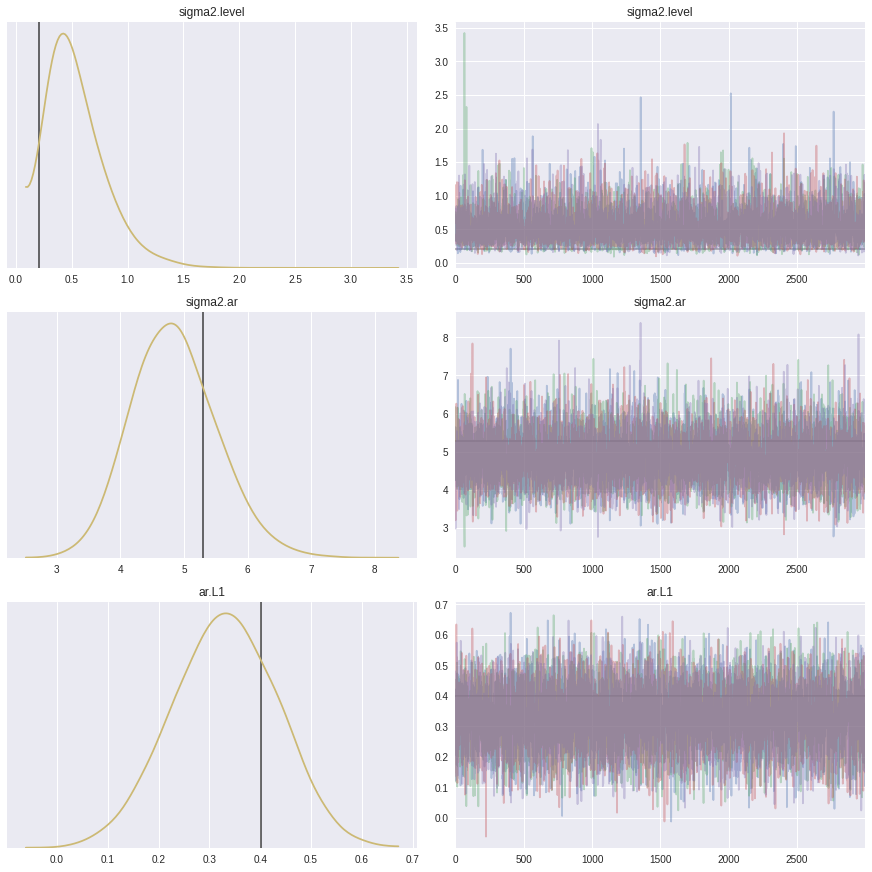

In [15]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.traceplot(trace_uc,
                 lines=[(k, {}, [v]) for k, v in dict(res_uc_mle.params).items()],
                 combined=True,
                 figsize=(12, 12))

In [16]:
pm.summary(trace_uc)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma2.level,0.538,0.255,0.155,1.001,0.003,0.002,7713.0,7704.0,7737.0,8234.0,1.0
sigma2.ar,4.840,0.666,3.600,6.071,0.008,0.006,7253.0,7253.0,7199.0,7191.0,1.0
ar.L1,0.329,0.102,0.141,0.522,0.001,0.001,8441.0,8363.0,8444.0,8854.0,1.0


In [17]:
# Retrieve the posterior means
params = pm.summary(trace_uc)['mean'].values

# Construct results using these posterior means as parameter values
res_uc_bayes = mod_uc.smooth(params)

One benefit of this model is that it gives us an estimate of the underling "level" of inflation, using the smoothed estimate of $\mu_t$, which we can access as the "level" column in the results objects' `states.smoothed` attribute. In this case, because the Bayesian posterior mean of the level's variance is larger than the MLE estimate, its estimated level is a little more volatile.

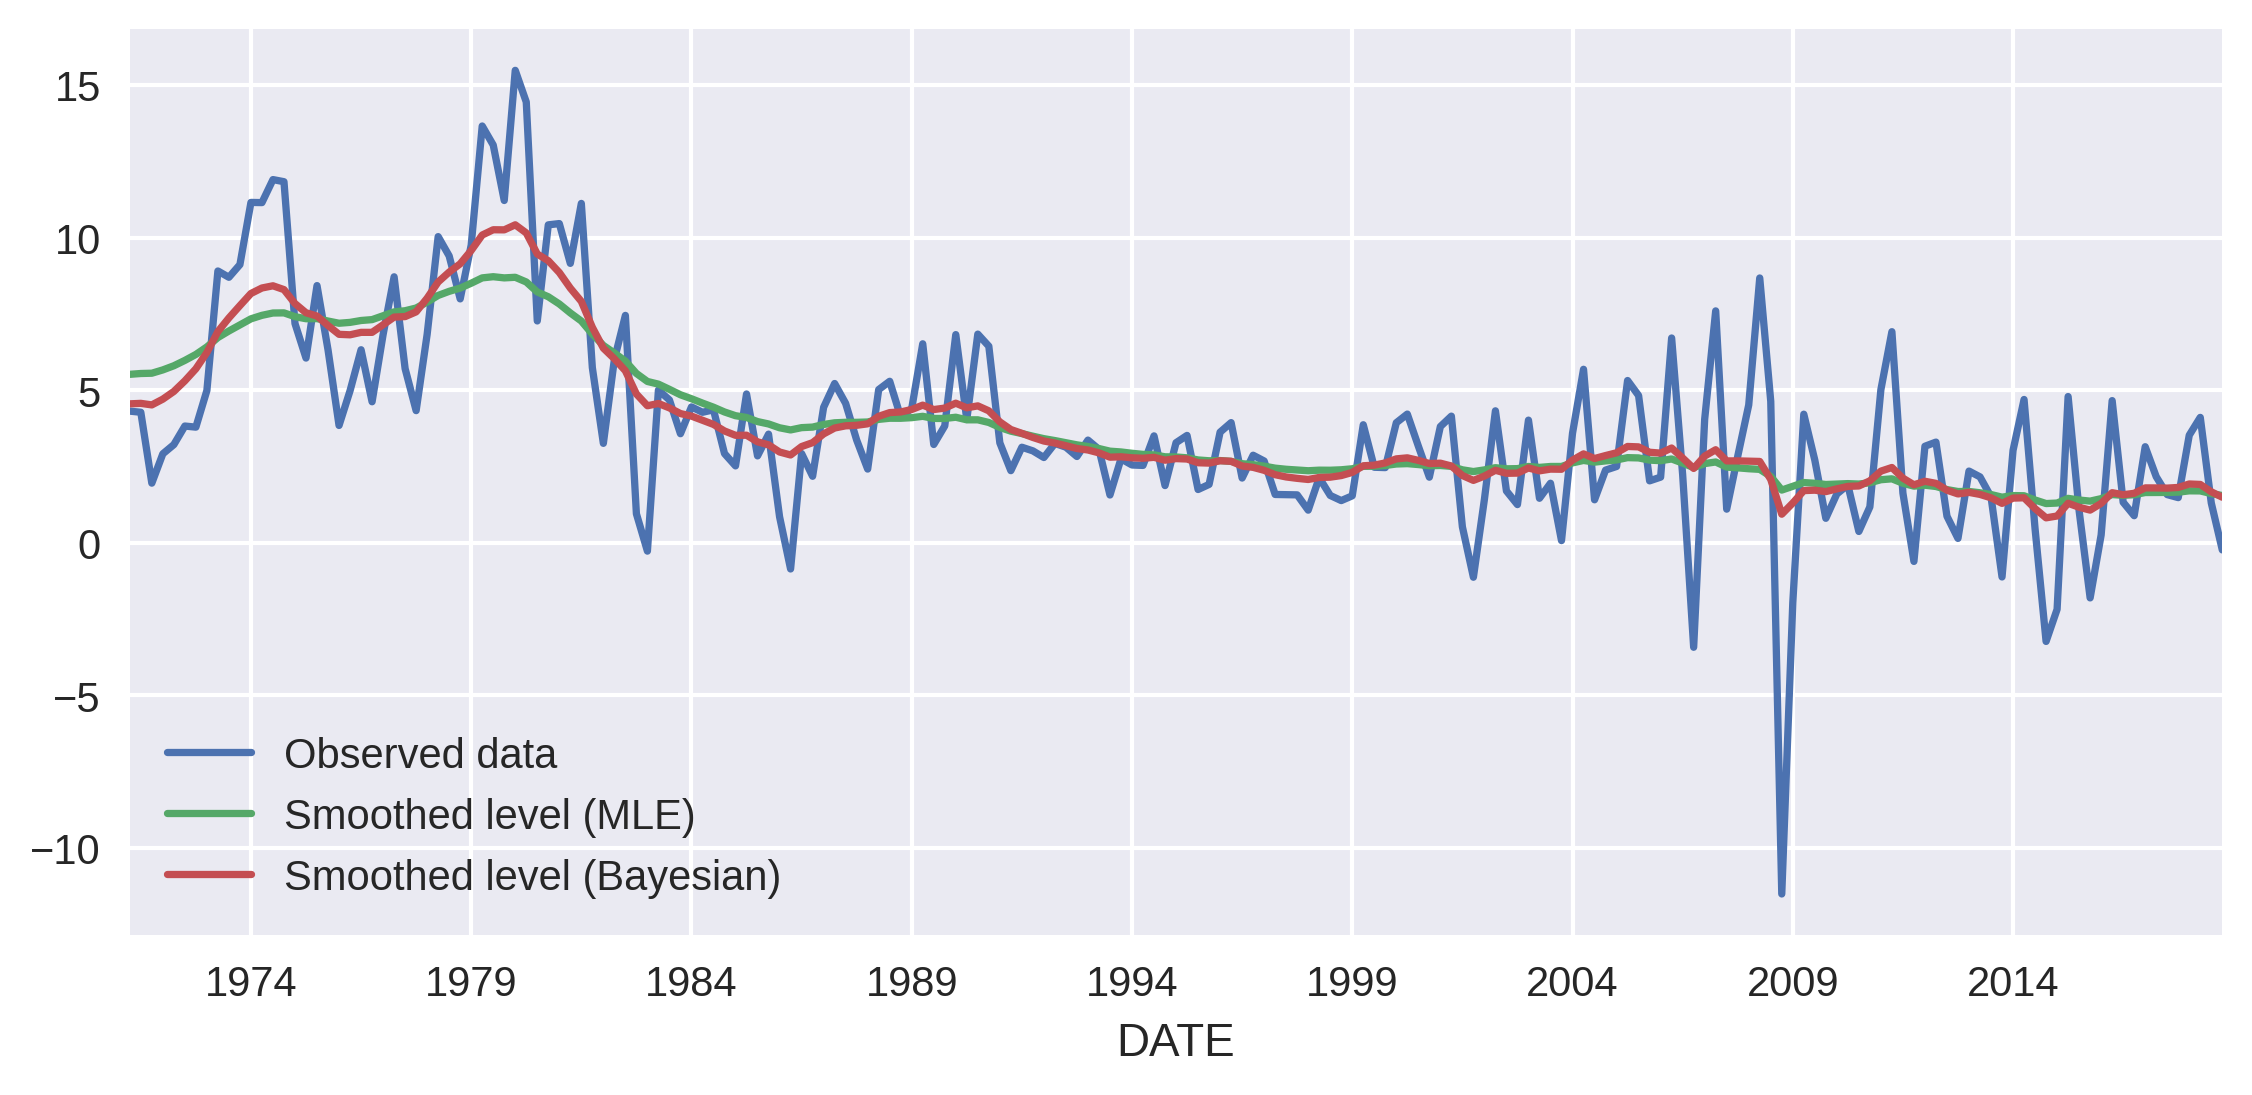

In [18]:
# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
inf['CPIAUCNS'].plot(ax=ax, style='-', label='Observed data')

# Plot estimate of the level term
res_uc_mle.states.smoothed['level'].plot(ax=ax, label='Smoothed level (MLE)')
res_uc_bayes.states.smoothed['level'].plot(ax=ax, label='Smoothed level (Bayesian)')

ax.legend(loc='lower left');